In [1]:
# %matplotlib inline
# %pip install scikit-learn
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from typing import Dict, List, Tuple, Optional, Union, Callable

# Suppress all warnings
warnings.filterwarnings('ignore')

# To ignore only "FutureWarning" specifically
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuration
SUPPLEMENT_FILE = 'supplementary_data.csv'
INPUT_PATTERN = 'input_2023_w{:02d}.csv'
OUTPUT_PATTERN = 'supplement-input_2023_w{:02d}.csv'
NUM_WEEKS = 18

# Updated paths for Kaggle competition data
KAGGLE_PATH = "/kaggle/input/nfl-big-data-bowl-2026-analytics/114239_nfl_competition_files_published_analytics_final"
TRAIN_PATH = os.path.join(KAGGLE_PATH, "train")

## Configuration Constants

In [2]:
# ============================================================================
# CONFIGURATION CONSTANTS
# ============================================================================

# Pressure zone definitions (yards from QB)
PRESSURE_ZONES = {
    'immediate': 3.0,    # 0-3 yards: Must throw/scramble NOW
    'closing': 5.0,      # 3-5 yards: Pressure building rapidly  
    'potential': 7.0     # 5-7 yards: Defenders approaching
}

# Convergence classification thresholds
CONVERGENCE_THRESHOLDS = {
    'critical': 3,    # 3+ defenders = critical convergence
    'high': 2,        # 2 defenders = high convergence
    'moderate': 1,    # 1 defender = moderate convergence
    'none': 0         # 0 defenders = no convergence
}

# Expected frame rate (frames per second)
FRAME_RATE = 10  # NFL tracking data standard


In [3]:
# ============================================================================
# CONFIGURATION: ENHANCED COLLAPSE THRESHOLDS
# ============================================================================

ENHANCED_COLLAPSE_CONFIG = {
    # QB Separation thresholds (yards)
    'separation_threshold': 7.0,
    'critical_separation': 4.0,
    
    # Convergence thresholds (defender count)
    'min_converging_defenders': 2,
    'critical_converging_defenders': 3,
    
    # Velocity threshold (yards/second)
    'velocity_threshold': -5.0,
    
    # Zone-specific thresholds
    'immediate_threat_zone': 3.0,
    'closing_threat_zone': 5.0
}

## Load Data

In [4]:
# Load supplementary data
supplementary_data = pd.read_csv(os.path.join(KAGGLE_PATH, SUPPLEMENT_FILE))

# Add feature pass_category based on pass_length. 
# pass_categories are 'short', 'intermediate', and 'long'. Short is <=5 yards, intermediate is >5 and <=15 yards, long is >15 yards. Use dict mapping.
conditions = [
    supplementary_data['pass_length'] < 5,
    (supplementary_data['pass_length'] >= 5) & (supplementary_data['pass_length'] <= 15),
    supplementary_data['pass_length'] > 15
]

categories = ['short', 'intermediate', 'long']

supplementary_data['pass_type'] = np.select(
    conditions, 
    categories, 
    default='unknown'
)


In [5]:
supplementary_data.shape

(18009, 42)

In [6]:
# Concatenate all weekly data into one datase
# Load all weeks data into one dataframe
input_data_frames = []
for week in range(1, NUM_WEEKS + 1):
    file_path = os.path.join(TRAIN_PATH, INPUT_PATTERN.format(week))
    df_week = pd.read_csv(file_path)
    df_week['week'] = week  # Add week column to track the source
    input_data_frames.append(df_week)

# Combine all dataframes
input_data = pd.concat(input_data_frames, ignore_index=True)
print(f"Loaded {len(input_data_frames)} weeks of data with {len(input_data)} total rows")
print(f"Test : {input_data['week'].max()}")

Loaded 18 weeks of data with 4880579 total rows
Test : 18


In [7]:
# Merge the supplementary column 'route_of_targeted_receiver' into the input data
input_data = pd.merge(
    input_data,                 # The left DataFrame (the one receiving the new column)
    supplementary_data[['game_id', 'play_id', 'route_of_targeted_receiver']],  # The right DataFrame (only the key columns and the column to add)
    on=['game_id', 'play_id'],  # The key columns to match on
    how='left'           # Specifies a left join
)

In [8]:
input_data.shape

(4880579, 25)

In [9]:
# list total unique plays in the input data
unique_plays = input_data[['game_id', 'play_id']].drop_duplicates()
print(f"Total unique plays in input data: {len(unique_plays)}")

# group by game_id and play_id and count
play_counts = unique_plays.groupby(['game_id', 'play_id']).size().reset_index(name='count')
print(f"Total unique plays after grouping: {len(play_counts)}")

Total unique plays in input data: 14108
Total unique plays after grouping: 14108


## Feature Engineering

In [10]:
def calculate_euclidean_distance_vectorized(tr_x, tr_y, def_x, def_y):
    """
    Calculate Euclidean distance between Targeted Receiver and all defenders using vectorized operations.
    
    Parameters:
    tr_x, tr_y: Quaterback coordinates (scalar)
    def_x, def_y: Defender coordinates (arrays/series)
    
    Returns:
    Array: Euclidean distances to all defenders
    """
    return np.sqrt((def_x - tr_x)**2 + (def_y - tr_y)**2)

### Frame Level - QB 
#### QB separation from nearest defender 

In [11]:
def calculate_frame_level_separation_qb(df):
    """
    Calculate minimum separation between Quarterback and defensive players at FRAME level.
    Returns only Quarterback data with qb_min_separation per frame.
    
    Parameters:
    df: DataFrame containing tracking data with columns:
        - game_id, play_id, frame_id, nfl_id
        - player_role: 'Passer' or 'Defensive Coverage'
        - player_name
        - x, y: Player coordinates
    
    Returns:
    DataFrame: Quarterback data with columns (game_id, play_id, nfl_id, frame_id, player_name, player_role, qb_min_separation)
    """
    
    # Group by game, play, and frame (FRAME-LEVEL calculation)
    grouped = df.groupby(['game_id', 'play_id', 'frame_id'])
    
    # List to store Quarterback results
    qb_results = []
    
    for (game_id, play_id, frame_id), frame_group in grouped:
        # Identify Quarterbacks and defenders in this specific frame
        quarterbacks = frame_group[frame_group['player_role'] == 'Passer']
        defenders = frame_group[frame_group['player_role'] == 'Defensive Coverage']
        
        # ✅ HANDLE MISSING DATA INSTEAD OF SKIPPING
        if quarterbacks.empty:
            continue  # No QB = can't analyze this frame
            
        if defenders.empty:
            # No defenders = maximum separation (safe pocket)
            for qb_idx, qb_row in quarterbacks.iterrows():
                qb_result = {
                    'game_id': game_id,
                    'play_id': play_id,
                    'nfl_id': qb_row['nfl_id'],
                    'frame_id': frame_id,
                    'player_name': qb_row['player_name'],
                    'player_role': qb_row['player_role'],
                    'player_position': qb_row['player_position'],
                    'qb_min_separation': 999.0  # Very large value = no pressure
                }
                qb_results.append(qb_result)
            continue
        
        # Extract defender coordinates as arrays for vectorized calculation
        def_x = defenders['x'].values
        def_y = defenders['y'].values
        
        # For Quarterback, calculate distance to all defenders using vectorization
        for qb_idx, qb_row in quarterbacks.iterrows():
            qb_x, qb_y = qb_row['x'], qb_row['y']
            
            # Vectorized distance calculation across all defenders in this frame
            distances = calculate_euclidean_distance_vectorized(qb_x, qb_y, def_x, def_y)
            
            # Find minimum distance for this frame
            min_distance = np.round(np.min(distances), 2)
            
            # Create result record for this Quarterback
            qb_result = {
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': qb_row['nfl_id'],
                'frame_id': frame_id,
                'player_name': qb_row['player_name'],
                'player_role': qb_row['player_role'],
                'player_position': qb_row['player_position'],
                'qb_min_separation': min_distance
            }
            qb_results.append(qb_result)
    
    # Convert results to DataFrame
    result_df = pd.DataFrame(qb_results)
    
    # Sort by game, play, quarterback, and frame for chronological analysis
    if not result_df.empty:
        result_df = result_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)
    
    return result_df

#### QB Presssure Velocity Calculation

In [12]:
# ----------------------------------------------------------------------------
# 4.1 QB PRESSURE VELOCITY CALCULATION
# ----------------------------------------------------------------------------

def calculate_frame_level_pressure_velocity_qb(qb_separation_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate rate of change in QB separation (pressure velocity) and acceleration.
    
    Pressure velocity indicates how fast defenders are closing in on the quarterback.
    Negative velocity means increasing pressure (defenders getting closer).
    
    Parameters
    ----------
    qb_separation_df : DataFrame
        Frame-level QB separation data with columns:
        ['game_id', 'play_id', 'nfl_id', 'frame_id', 'qb_min_separation']
    
    Returns
    -------
    DataFrame with additional columns:
        - Change in separation from previous frame (yards)
        - separation_velocity: Rate of change (yards/second)
        - pressure_acceleration: Rate of change of velocity (yards/second²)
        
    Notes
    -----
    - Negative velocity: Defenders closing in (pressure increasing)
    - Positive velocity: QB creating space (pressure decreasing)
    - Negative acceleration = Defender speeding up toward QB (pressure intensifying)
    - Positive acceleration = Defender slowing down (pressure decreasing)
    - First frame of each play will have NaN velocity (no previous frame)
    
    Examples
    --------
    >>> qb_velocity_frame_level = calculate_qb_pressure_velocity(qb_separation_df)
    >>> qb_velocity_frame_level[['frame_id', 'qb_min_separation', 'separation_velocity']].head()
       frame_id  qb_min_separation  separation_velocity
    0         1               10.5                  NaN
    1         2               10.2                 -3.0
    2         3                9.8                 -4.0
    """
    
    # Input validation
    required_cols = ['game_id', 'play_id', 'nfl_id', 'frame_id', 'qb_min_separation']
    missing_cols = set(required_cols) - set(qb_separation_df.columns)
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Create a copy to avoid modifying original data
    df = qb_separation_df.sort_values(
        ['game_id', 'play_id', 'nfl_id', 'frame_id']
    ).copy()
    
    # Group by play to ensure calculations don't cross play boundaries
    grouping_cols = ['game_id', 'play_id', 'nfl_id']
    
    # Calculate frame-to-frame separation change
    df['separation_diff'] = df.groupby(grouping_cols)['qb_min_separation'].diff()
    
    # Convert to velocity (yards per second)
    # Frame interval = 0.1 seconds
    FRAME_INTERVAL = 0.1
    df['separation_velocity'] = (df['separation_diff'] / FRAME_INTERVAL).round(2)
    
    # Calculate acceleration (change in velocity)
    df['velocity_diff'] = df.groupby(grouping_cols)['separation_velocity'].diff()
    df['pressure_acceleration'] = (df['velocity_diff'] / FRAME_INTERVAL).round(2)
    
    # Clean up intermediate columns
    df = df.drop(columns=['separation_diff', 'velocity_diff'])
    
    return df

#### Defender Convergence Calculation

In [13]:
# ============================================================================
# CALCULATE DEFENDER CONVERGENCE Frame Level
# ============================================================================

def calculate_frame_level_defender_convergence(
    input_data: pd.DataFrame,
    zones: Optional[Dict[str, float]] = None,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Calculate defender convergence metrics for each frame.
    
    For every frame in the dataset, counts how many defenders are within
    defined pressure zones around the quarterback. Returns frame-level
    metrics suitable for ML feature engineering.
    
    Parameters
    ----------
    input_data : pd.DataFrame
        Frame-level tracking data containing:
        
        Required columns:
        - game_id : int
            Unique game identifier
        - play_id : int
            Unique play identifier within game
        - frame_id : int
            Frame number (10 frames per second)
        - nfl_id : int
            Player NFL ID
        - player_role : str
            'Passer' for QB, 'Defensive Coverage' for defenders
        - x : float
            Player x-coordinate on field (yards)
        - y : float
            Player y-coordinate on field (yards)
        
        Optional columns:
        - player_name : str
            Player name (for readability)
        - player_position : str
            Position code (QB, DE, LB, etc.)
    
    zones : Dict[str, float], optional
        Custom pressure zone definitions (yards from QB).
        Default uses PRESSURE_ZONES constant:
        {'immediate': 3.0, 'closing': 5.0, 'potential': 7.0}
    
    verbose : bool, default=True
        Print progress messages during processing.
    
    Returns
    -------
    pd.DataFrame
        Frame-level convergence metrics with columns:
        
        Identifiers:
        - game_id, play_id, frame_id, nfl_id : int
            Frame and player identifiers
        - player_name, player_role : str
            QB identification
        
        Convergence Counts:
        - defenders_immediate_zone : int
            Defenders in immediate threat zone (0-3 yards)
        - defenders_closing_zone : int
            Defenders in closing threat zone (0-5 yards)
        - defenders_potential_zone : int
            Defenders in potential threat zone (0-7 yards)
        - total_converging_defenders : int
            Total defenders within outermost zone
        
        Convergence Classification:
        - convergence_category : str
            'Critical', 'High', 'Moderate', or 'None'
        
        Validation Metrics:
        - closest_defender_distance : float
            Distance to nearest defender (yards)
        - total_defenders_on_field : int
            Total defenders in frame (for validation)
    
    Raises
    ------
    ValueError
        If required columns are missing from input_data.
    
    Notes
    -----
    **Pressure Zone Definitions:**
    
    Immediate Threat (0-3 yards):
    - QB must make decision NOW
    - Throw, scramble, or take sack imminent
    
    Closing Threat (3-5 yards):
    - Pressure building rapidly
    - QB has 0.5-1.0 seconds before immediate threat
    
    Potential Threat (5-7 yards):
    - Defenders approaching
    - QB has 1.0-1.5 seconds if pocket holds
    
    **Convergence Categories:**
    
    Critical (3+ defenders in 7-yard zone):
    - Pocket collapsing from multiple angles
    - Likely sack or forced quick throw
    
    High (2 defenders in 7-yard zone):
    - Significant pressure
    - Limited throwing lanes
    
    Moderate (1 defender in 7-yard zone):
    - Manageable pressure
    - Single rush threat
    
    None (0 defenders in 7-yard zone):
    - Clean pocket
    - QB has time to read defense
    
    **Performance:**
    Processing speed: ~1000-2000 frames per second
    Memory usage: ~50MB per 10,000 frames
    
    Examples
    --------
    >>> # Basic usage with default zones
    >>> convergence_df = calculate_frame_level_defender_convergence(input_data)
    >>> 
    >>> # Custom zones for different analysis
    >>> custom_zones = {'immediate': 2.5, 'closing': 4.0, 'potential': 6.0}
    >>> convergence_df = calculate_frame_level_defender_convergence(
    ...     input_data, 
    ...     zones=custom_zones,
    ...     verbose=False
    ... )
    >>> 
    >>> # Analyze high convergence frames
    >>> high_convergence = convergence_df[
    ...     convergence_df['convergence_category'].isin(['Critical', 'High'])
    ... ]
    >>> print(f"High convergence frames: {len(high_convergence)}")
    """
    
    # -------------------------------------------------------------------------
    # INPUT VALIDATION
    # -------------------------------------------------------------------------
    
    required_columns = [
        'game_id', 'play_id', 'frame_id', 'nfl_id',
        'player_role', 'x', 'y'
    ]
    
    missing_columns = [col for col in required_columns 
                       if col not in input_data.columns]
    
    if missing_columns:
        raise ValueError(
            f"Missing required columns for convergence calculation: "
            f"{missing_columns}\n"
            f"Required: {required_columns}"
        )
    
    # Use provided zones or defaults
    if zones is None:
        zones = PRESSURE_ZONES.copy()
    
    # -------------------------------------------------------------------------
    # PROCESSING INITIALIZATION
    # -------------------------------------------------------------------------
    
    if verbose:
        print("="*70)
        print("CALCULATING DEFENDER CONVERGENCE")
        print("="*70)
        print(f"Pressure Zones: {zones}")
        print("-"*70)
        print("Processing frames...")
    
    # Group data by frame for efficient processing
    grouped = input_data.groupby(['game_id', 'play_id', 'frame_id'])
    total_frames = len(grouped)
    
    # Storage for convergence results
    convergence_results = []
    
    # Progress tracking
    frames_processed = 0
    frames_with_data = 0
    
    # -------------------------------------------------------------------------
    # FRAME-LEVEL PROCESSING LOOP
    # -------------------------------------------------------------------------
    
    for (game_id, play_id, frame_id), frame_group in grouped:
        
        frames_processed += 1
        
        # Progress reporting (every 1000 frames)
        if verbose and frames_processed % 1000 == 0:
            print(f"  Processed {frames_processed:,} / {total_frames:,} frames...")
        
        # ---------------------------------------------------------------------
        # IDENTIFY QB AND DEFENDERS IN FRAME
        # ---------------------------------------------------------------------
        
        qb_data = frame_group[frame_group['player_role'] == 'Passer']
        defender_data = frame_group[
            frame_group['player_role'] == 'Defensive Coverage'
        ]
        
        # Skip frames without QB or defenders
        if qb_data.empty or defender_data.empty:
            continue
        
        frames_with_data += 1
        
        # ---------------------------------------------------------------------
        # PROCESS EACH QB IN FRAME (typically only 1)
        # ---------------------------------------------------------------------
        
        for qb_idx, qb_row in qb_data.iterrows():
            
            # Extract QB information
            qb_x = qb_row['x']
            qb_y = qb_row['y']
            qb_nfl_id = qb_row['nfl_id']
            qb_name = qb_row.get('player_name', 'Unknown QB')
            qb_position = qb_row.get('player_position', 'QB')
            
            # Extract defender positions as arrays (for vectorization)
            defender_x = defender_data['x'].values
            defender_y = defender_data['y'].values
            total_defenders = len(defender_x)
            
            # -----------------------------------------------------------------
            # CALCULATE DISTANCES (VECTORIZED)
            # -----------------------------------------------------------------
            
            distances = calculate_euclidean_distance_vectorized(
                qb_x, qb_y, defender_x, defender_y
            )
            
            # -----------------------------------------------------------------
            # COUNT DEFENDERS IN EACH ZONE
            # -----------------------------------------------------------------
            
            # Immediate threat zone (0-3 yards)
            defenders_immediate_zone = np.sum(
                distances < zones['immediate']
            )
            
            # Closing threat zone (3-5 yards)
            defenders_closing_zone = np.sum(
                (distances >= zones['immediate']) & (distances < zones['closing'])
            )
            
            # Potential threat zone (5-7 yards)
            defenders_potential_zone = np.sum(
                (distances >= zones['closing']) & (distances < zones['potential'])
            )
            
            # Total converging defenders (outermost zone)
            total_converging = defenders_potential_zone + defenders_closing_zone + defenders_immediate_zone
            
            # -----------------------------------------------------------------
            # CLASSIFY CONVERGENCE LEVEL
            # -----------------------------------------------------------------
            
            if total_converging >= CONVERGENCE_THRESHOLDS['critical']:
                convergence_category = 'Critical'
            elif total_converging >= CONVERGENCE_THRESHOLDS['high']:
                convergence_category = 'High'
            elif total_converging >= CONVERGENCE_THRESHOLDS['moderate']:
                convergence_category = 'Moderate'
            else:
                convergence_category = 'None'
            
            # -----------------------------------------------------------------
            # VALIDATION METRICS
            # -----------------------------------------------------------------
            
            # Closest defender distance (should match qb_min_separation)
            closest_defender_distance = float(np.min(distances))
            
            # -----------------------------------------------------------------
            # STORE FRAME RESULT
            # -----------------------------------------------------------------
            
            frame_result = {
                # Identifiers
                'game_id': game_id,
                'play_id': play_id,
                'frame_id': frame_id,
                'nfl_id': qb_nfl_id,
                
                # QB information
                'player_name': qb_name,
                'player_role': qb_row['player_role'],
                'player_position': qb_position,
                
                # Convergence counts (zone-based)
                'defenders_immediate_zone': int(defenders_immediate_zone),
                'defenders_closing_zone': int(defenders_closing_zone),
                'defenders_potential_zone': int(defenders_potential_zone),
                'total_converging_defenders': int(total_converging),
                
                # Convergence classification
                'convergence_category': convergence_category,
                
                # Validation metrics
                'closest_defender_distance': closest_defender_distance,
                'total_defenders_on_field': total_defenders
            }
            
            convergence_results.append(frame_result)
    
    # -------------------------------------------------------------------------
    # CREATE OUTPUT DATAFRAME
    # -------------------------------------------------------------------------
    
    convergence_df = pd.DataFrame(convergence_results)
    
    # Sort by game, play, QB, and frame for chronological analysis
    if not convergence_df.empty:
        convergence_df = convergence_df.sort_values(
            ['game_id', 'play_id', 'nfl_id', 'frame_id']
        ).reset_index(drop=True)
    
    # -------------------------------------------------------------------------
    # PROCESSING SUMMARY
    # -------------------------------------------------------------------------
    
    if verbose:
        print(f"\n{'='*70}")
        print("CONVERGENCE CALCULATION COMPLETE")
        print("="*70)
        print(f"Total frames processed: {frames_processed:,}")
        print(f"Frames with QB & defenders: {frames_with_data:,}")
        print(f"Convergence records created: {len(convergence_df):,}")
        
        if not convergence_df.empty:
            print(f"\nConvergence Category Distribution:")
            category_counts = convergence_df['convergence_category'].value_counts()
            for category in ['Critical', 'High', 'Moderate', 'None']:
                count = category_counts.get(category, 0)
                pct = (count / len(convergence_df) * 100) if len(convergence_df) > 0 else 0
                print(f"  • {category:12s}: {count:5,} frames ({pct:5.1f}%)")
            
            print(f"\nDefender Zone Statistics:")
            print(f"  • Avg defenders within 3yds: "
                  f"{convergence_df['defenders_immediate_zone'].mean():.2f}")
            print(f"  • Avg defenders within 5yds: "
                  f"{convergence_df['defenders_closing_zone'].mean():.2f}")
            print(f"  • Avg defenders within 7yds: "
                  f"{convergence_df['defenders_potential_zone'].mean():.2f}")
            
            print(f"\nClosest Defender Statistics:")
            print(f"  • Min distance: "
                  f"{convergence_df['closest_defender_distance'].min():.2f} yards")
            print(f"  • Avg distance: "
                  f"{convergence_df['closest_defender_distance'].mean():.2f} yards")
            print(f"  • Max distance: "
                  f"{convergence_df['closest_defender_distance'].max():.2f} yards")
        
        print("="*70)
    
    return convergence_df

#### QB Merge Frame Level- Separation, Pressure Velocity, Convergence

In [14]:
# ============================================================================
# FUNCTION 1: MERGE QB SEPARATION WITH CONVERGENCE
# ============================================================================

def merge_qb_separation_with_convergence(
    qb_separation_df: pd.DataFrame,
    convergence_df: pd.DataFrame,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Merge frame-level QB separation data with defender convergence metrics.
    
    Combines QB separation metrics (distance to nearest defender, velocity)
    with defender convergence metrics (zone counts, convergence category)
    at frame granularity.
    
    Parameters
    ----------
    qb_separation_df : pd.DataFrame
        Frame-level QB separation and velocity data.
        
        Required columns:
        - game_id : int
            Unique game identifier
        - play_id : int
            Unique play identifier
        - frame_id : int
            Frame number (10 fps)
        - nfl_id : int
            Quarterback NFL ID
        - qb_min_separation : float
            Distance to nearest defender (yards)
        - separation_velocity : float
            Rate of separation change (yards/second)
        - pressure_acceleration : float, optional
            Rate of velocity change (yards/second²)
        
        Optional columns:
        - player_name, player_role, player_position
    
    convergence_df : pd.DataFrame
        Frame-level defender convergence data from Step A.2.
        
        Required columns:
        - game_id, play_id, frame_id, nfl_id : identifiers
        - defenders_immediate_zone : int
            Count in immediate threat zone (0-3 yards)
        - defenders_closing_zone : int
            Count in closing threat zone (0-5 yards)
        - defenders_potential_zone : int
            Count in potential threat zone (0-7 yards)
        - total_converging_defenders : int
            Total defenders within 7-yard zone
        - convergence_category : str
            'Critical', 'High', 'Moderate', or 'None'
        - closest_defender_distance : float
            Distance to nearest defender (for validation)
        - total_defenders_on_field : int
            Total defenders in frame
    
    verbose : bool, default=True
        Print merge statistics and diagnostics.
    
    Returns
    -------
    pd.DataFrame
        Merged frame-level data with both QB separation and convergence metrics.
        
        Output columns include all columns from both input dataframes.
        Merge key: (game_id, play_id, frame_id, nfl_id)
        
        Note: Does NOT include collapse indicators - those are created in
        the next pipeline step.
    
    Raises
    ------
    ValueError
        If merge produces unexpected number of rows or low match rate.
    
    Notes
    -----
    **Merge Strategy:**
    - Type: LEFT join (preserve all QB frames)
    - Key: (game_id, play_id, frame_id, nfl_id)
    - Missing convergence data filled with zeros (frames without defenders)
    
    **Expected Match Rate:**
    Should be ~100% if both calculations used same input_data.
    Lower match rate may indicate:
    - Frames without defenders (filled with zeros)
    - Data inconsistencies between sources
    
    **Pipeline Position:**
    1. calculate_frame_level_separation_qb() → QB separation
    2. calculate_qb_pressure_velocity() → Add velocity
    3. calculate_frame_level_defender_convergence() → Convergence metrics
    4. merge_qb_separation_with_convergence() → Combined features ← THIS
    
    **Data Quality:**
    - Fills missing convergence with zeros (safe assumption: no defenders)
    - Validates match rate (warns if < 95%)
    - Preserves temporal continuity (all QB frames retained)
    
    Examples
    --------
    >>> # Basic usage
    >>> merged_df = merge_qb_separation_with_convergence(
    ...     qb_velocity_frame_level,
    ...     convergence_frame_level
    ... )
    >>> 
    >>> # Check merge quality
    >>> print(f"Shape: {merged_df.shape}")
    >>> print(f"Columns: {merged_df.columns.tolist()}")
    >>> 
    >>> # Verify no collapse indicators yet
    >>> assert 'is_pocket_collapse' not in merged_df.columns
    >>> # Collapse indicators created in next step
    
    See Also
    --------
    calculate_qb_pressure_velocity : Creates velocity features
    calculate_frame_level_defender_convergence : Creates convergence features
    """
    
    if verbose:
        print("="*70)
        print("MERGING QB SEPARATION WITH CONVERGENCE (FRAME-LEVEL)")
        print("="*70)
        print(f"QB separation data: {qb_separation_df.shape[0]:,} frames")
        print(f"Convergence data: {convergence_df.shape[0]:,} frames")
        print("\nPurpose: Combine pressure metrics for collapse detection")
        print("Note: Collapse indicators created in next step")
    
    # -------------------------------------------------------------------------
    # COLUMN SELECTION
    # -------------------------------------------------------------------------
    
    # Select convergence columns to merge (avoid duplicates)
    convergence_cols_to_merge = [
        'game_id', 'play_id', 'frame_id', 'nfl_id',
        'defenders_immediate_zone',
        'defenders_closing_zone',
        'defenders_potential_zone',
        'total_converging_defenders',
        'convergence_category',
        'total_defenders_on_field'
        # Exclude 'closest_defender_distance' - it's duplicate of qb_min_separation
    ]
    
    # Filter to available columns
    convergence_available_cols = [
        col for col in convergence_cols_to_merge 
        if col in convergence_df.columns
    ]

    # Filter to available columns
    available_cols = [col for col in convergence_cols_to_merge 
                      if col in convergence_df.columns]
    
    # -------------------------------------------------------------------------
    # MERGE DATAFRAMES
    # -------------------------------------------------------------------------
    
    # Perform left join (keep all QB frames)
    merged_df = qb_separation_df.merge(
        convergence_df[convergence_available_cols],
        on=['game_id', 'play_id', 'frame_id', 'nfl_id'],
        how='left',
        suffixes=('', '_conv')  # Handle any column overlaps
    )
    
    # -------------------------------------------------------------------------
    # HANDLE MISSING VALUES
    # -------------------------------------------------------------------------
    
    # Fill missing convergence data with zeros
    # (Frames without defenders = zero convergence)
    convergence_numeric_cols = [
        'defenders_immediate_zone',
        'defenders_closing_zone',
        'defenders_potential_zone',
        'total_converging_defenders',
        'total_defenders_on_field'
    ]
    
    for col in convergence_numeric_cols:
        if col in merged_df.columns:
            merged_df[col] = merged_df[col].fillna(0).astype(int)
    
    # Fill missing convergence category
    if 'convergence_category' in merged_df.columns:
        merged_df['convergence_category'] = merged_df['convergence_category'].fillna('None')
    
    # -------------------------------------------------------------------------
    # MERGE QUALITY VALIDATION
    # -------------------------------------------------------------------------
    
    if verbose:
        # Calculate match rate
        matched_frames = (
            (~merged_df['defenders_potential_zone'].isna()).sum() 
            if 'defenders_potential_zone' in merged_df.columns 
            else merged_df['convergence_category'].notna().sum()
        )
        match_rate = (matched_frames / len(merged_df) * 100) if len(merged_df) > 0 else 0
        
        print(f"\nMerge Results:")
        print(f"  • Total frames after merge: {len(merged_df):,}")
        print(f"  • Frames with convergence data: {matched_frames:,}")
        print(f"  • Match rate: {match_rate:.1f}%")
        print(f"  • Total columns: {merged_df.shape[1]}")
        
        # Validation warnings
        if match_rate < 95:
            print(f"\n  ⚠ Warning: Low match rate ({match_rate:.1f}%)")
            print(f"     Expected ~100% if same input_data used")
            print(f"     Missing data filled with zeros (safe for frames without defenders)")
        else:
            print(f"  ✓ Good match rate - data sources aligned")
        
        print("="*70)
    
    return merged_df


In [15]:
def organize_qb_frame_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Organize QB frame-level columns in logical order."""
    
    # Define column order
    column_order = [
        # Identifiers
        'game_id', 'play_id', 'nfl_id', 'frame_id',
        
        # Player info
        'player_name', 'player_role', 'player_position',
        
        # QB Separation metrics
        'qb_min_separation',
        'separation_velocity', 
        'pressure_acceleration',
        
        # Defender convergence counts
        'defenders_immediate_zone',
        'defenders_closing_zone',
        'defenders_potential_zone', 
        'total_converging_defenders',
        'convergence_category',
        'total_defenders_on_field',
        
        # Collapse indicators
        'collapse_factor_separation',
        'collapse_factor_convergence',
        'collapse_factor_immediate_threat',
        'collapse_factor_velocity',
        'is_pocket_collapse',
        'collapse_severity'
    ]
    
    # Select available columns in order
    available_cols = [col for col in column_order if col in df.columns]
    
    # Add any remaining columns
    remaining_cols = [col for col in df.columns if col not in available_cols]
    final_cols = available_cols + remaining_cols
    
    return df[final_cols]

### Frame Level - TR

In [16]:
def calculate_frame_level_separation_tr(df):
    """
    Calculate minimum separation between Targeted Receiver and defensive players at FRAME level.
    Returns only Targeted Receiver data with tr_min_separation per frame.
    
    Parameters:
    df: DataFrame containing tracking data with columns:
        - game_id, play_id, frame_id, nfl_id
        - player_role: 'Targeted Receiver' or 'Defensive Coverage'
        - player_name
        - x, y: Player coordinates
    
    Returns:
    DataFrame: Targeted Receiver data with columns (game_id, play_id, nfl_id, frame_id, player_name, player_role, tr_min_separation)
    """
    
    # Group by game, play, and frame (FRAME-LEVEL calculation)
    grouped = df.groupby(['game_id', 'play_id', 'frame_id'])
    
    # List to store Targeted Receiver results
    tr_results = []
    
    for (game_id, play_id, frame_id), frame_group in grouped:
        # Identify Targeted Receivers and defenders in this specific frame
        target_receivers = frame_group[frame_group['player_role'] == 'Targeted Receiver']
        defenders = frame_group[frame_group['player_role'] == 'Defensive Coverage']
        
        # Skip if no Targeted Receivers or defenders in this frame
        if target_receivers.empty or defenders.empty:
            continue
        
        # Extract defender coordinates as arrays for vectorized calculation
        def_x = defenders['x'].values
        def_y = defenders['y'].values
        
        # For each Targeted Receiver, calculate distance to all defenders using vectorization
        for tr_idx, tr_row in target_receivers.iterrows():
            tr_x, tr_y = tr_row['x'], tr_row['y']
            
            # Vectorized distance calculation across all defenders in this frame
            distances = calculate_euclidean_distance_vectorized(tr_x, tr_y, def_x, def_y)
            
            # Find minimum distance for this frame
            min_distance = np.round(np.min(distances), 2)
            
            # Create result record for this Targeted Receiver
            tr_result = {
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': tr_row['nfl_id'],
                'frame_id': frame_id,
                'player_name': tr_row['player_name'],
                'player_role': tr_row['player_role'],
                'player_position': tr_row['player_position'],
                'tr_min_separation': min_distance,
                'route_of_targeted_receiver': tr_row['route_of_targeted_receiver'],
                'dir': tr_row['dir']
            }
            tr_results.append(tr_result)
    
    # Convert results to DataFrame
    result_df = pd.DataFrame(tr_results)
    
    # Sort by game, play, receiver, and frame for chronological analysis
    if not result_df.empty:
        result_df = result_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).reset_index(drop=True)
    
    return result_df

### Play Level Aggregation

#### PLay Level - QB Separation, Pressure Velocity, Convergence and Pocket Collapse

In [17]:
# ============================================================================
# QB PLAY-LEVEL AGGREGATION
# ============================================================================
# Project: NFL Passing Game Analysis
# Author: Hsotuhsa-S
# Date: 2025-11-19 23:35:15
# Purpose: Aggregate complete QB frame-level features to play-level
# Version: Corrected - Pure aggregation, no feature engineering
#
# Design Principle:
#   - Input: Complete frame-level features (already calculated)
#   - Process: GROUP BY play, AGGREGATE with statistical functions
#   - Output: Play-level summary statistics
#   
#
# Dependencies:
#   - pandas >= 1.3.0
#   - numpy >= 1.21.0
# ============================================================================

import pandas as pd
import numpy as np
from typing import Optional
import warnings
warnings.filterwarnings('ignore')


def aggregate_qb_features_to_play_level(
    frame_df: pd.DataFrame,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Aggregate QB frame-level features to play-level using pandas groupby.
    
    This is PURE AGGREGATION - no feature engineering, no distance calculations,
    no loops. Simply summarizes existing frame-level metrics.
    
    Parameters
    ----------
    frame_df : pd.DataFrame
        Complete frame-level QB data with ALL features already calculated.
        
        Expected input columns (from previous steps):
        - game_id, play_id, nfl_id, frame_id
        - qb_min_separation (from calculate_frame_level_separation_qb)
        - separation_velocity (from calculate_qb_pressure_velocity)
        - defenders_immediate_zone, defenders_closing_zone, defenders_potential_zone
          (from calculate_frame_level_defender_convergence)
        - total_converging_defenders (from calculate_frame_level_defender_convergence)
        - closest_defender_distance (from calculate_frame_level_defender_convergence)
        - player_name, player_role (metadata)
    
    verbose : bool, default=True
        Print aggregation summary.
    
    Returns
    -------
    pd.DataFrame
        Play-level aggregated QB features.
        
        Output columns (~25-30):
        - game_id, play_id, nfl_id (identifiers)
        - qb_play_min_separation, qb_play_avg_separation, qb_play_var_separation
        - max_pressure_velocity, pressure_velocity_avg, pressure_volatility
        - max_converging_defenders, avg_converging_defenders, std_converging_defenders
        - max_defenders_immediate_zone, max_defenders_closing_zone
        - time_to_throw, total_frames
        - (and more...)
    
    Notes
    -----
    **This Function Does:**
    - Groups frame-level data by (game_id, play_id, nfl_id)
    - Applies aggregation functions (MIN, MAX, MEAN, STD, SUM, COUNT)
    - Creates play-level summary statistics
    
    **This Function Does NOT:**
    - Calculate distances (already done in frame-level functions)
    - Loop through rows (uses vectorized pandas operations)
    - Create new features (only aggregates existing ones)
    - Filter or transform data (pure aggregation)
    
    **Why This is Correct:**
    Aggregation should be:
    1. Simple: Just groupby + agg
    2. Fast: Vectorized pandas operations
    3. Clear: Obvious what it does
    4. Separation of concerns: Aggregation ≠ Feature Engineering
    
    Examples
    --------
    >>> # Input: Frame-level features (already calculated)
    >>> print(enhanced_collapse_frame_level.shape)
    (23103, 24)  # 23K frames with complete features
    >>> 
    >>> # Aggregate to play-level
    >>> qb_play = aggregate_qb_features_to_play_level(
    ...     enhanced_collapse_frame_level
    ... )
    >>> 
    >>> # Output: Play-level aggregates
    >>> print(qb_play.shape)
    (818, 28)  # 818 plays with aggregated features
    """
    
    if verbose:
        print("="*70)
        print("AGGREGATING QB FRAME-LEVEL FEATURES TO PLAY-LEVEL")
        print("="*70)
        print(f"Input: {frame_df.shape[0]:,} frames")
    
    # -------------------------------------------------------------------------
    # DEFINE AGGREGATION DICTIONARY
    # -------------------------------------------------------------------------
    # Simple, declarative aggregation - no calculations, no loops
    
    agg_dict = {}
    
    # Separation metrics (if available)
    if 'qb_min_separation' in frame_df.columns:
        agg_dict['qb_min_separation'] = [
            ('qb_play_min_separation', 'min'),      # Peak pressure
            ('qb_play_avg_separation', 'mean'),     # Sustained pressure
            ('qb_play_var_separation', 'var')       # Volatility
        ]
    
    # Velocity metrics (if available)
    if 'separation_velocity' in frame_df.columns:
        agg_dict['separation_velocity'] = [
            ('max_pressure_velocity', 'min'),       # Most negative
            ('pressure_velocity_avg', 'mean'),
            ('pressure_volatility', 'std')
        ]
    
    # Acceleration metrics (if available)
    if 'pressure_acceleration' in frame_df.columns:
        agg_dict['pressure_acceleration'] = [
            ('max_pressure_acceleration', 'min'),
            ('pressure_acceleration_avg', 'mean')
        ]
    
    # Convergence metrics (if available)
    if 'total_converging_defenders' in frame_df.columns:
        agg_dict['total_converging_defenders'] = [
            ('max_converging_defenders', 'max'),
            ('avg_converging_defenders', 'mean'),
            ('std_converging_defenders', 'std')
        ]
    
    if 'defenders_immediate_zone' in frame_df.columns:
        agg_dict['defenders_immediate_zone'] = [
            ('max_defenders_immediate_zone', 'max')
        ]
    
    if 'defenders_closing_zone' in frame_df.columns:
        agg_dict['defenders_closing_zone'] = [
            ('max_defenders_closing_zone', 'max'),
            ('avg_defenders_closing_zone', 'mean')
        ]
    
    if 'defenders_potential_zone' in frame_df.columns:
        agg_dict['defenders_potential_zone'] = [
            ('max_defenders_potential_zone', 'max')
        ]
    
    # Player metadata
    if 'player_name' in frame_df.columns:
        agg_dict['player_name'] = [('player_name', 'first')]
    
    if 'player_role' in frame_df.columns:
        agg_dict['player_role'] = [('player_role', 'first')]
    
    
    # -------------------------------------------------------------------------
    # PERFORM AGGREGATION (Simple groupby)
    # -------------------------------------------------------------------------
    
    play_agg = frame_df.groupby(['game_id', 'play_id', 'nfl_id']).agg(agg_dict)
    
    
    # ✅ CORRECT: Extract only the new column names
    play_agg.columns = play_agg.columns.get_level_values(1)
    play_agg = play_agg.reset_index()

    if verbose:
        print(f"✓ Aggregated to {len(play_agg):,} rows")
        print(f"✓ Features: {len(play_agg.columns)} columns")
    
    
    # -------------------------------------------------------------------------
    # FILL MISSING VALUES
    # -------------------------------------------------------------------------
    
    # Fill NaN standard deviations
    std_cols = [col for col in play_agg.columns if 'std_' in col or '_volatility' in col]
    for col in std_cols:
        play_agg[col] = play_agg[col].fillna(0)
    
    # Fill NaN counts
    count_cols = [col for col in play_agg.columns if 'count' in col.lower() or 'frames' in col.lower()]
    for col in count_cols:
        if col in play_agg.columns:
            play_agg[col] = play_agg[col].fillna(0).astype(int)
    
    # -------------------------------------------------------------------------
    # SUMMARY
    # -------------------------------------------------------------------------
    
    if verbose:
        print(f"Output: {play_agg.shape[0]:,} plays × {play_agg.shape[1]} features")
        print(f"Reduction: {frame_df.shape[0] / play_agg.shape[0]:.1f}:1 (frames to plays)")
        
        feature_groups = {
            'Separation': [c for c in play_agg if 'separation' in c.lower()],
            'Velocity': [c for c in play_agg if 'velocity' in c.lower() or 'acceleration' in c.lower()],
            'Convergence': [c for c in play_agg if 'defender' in c.lower() or 'converg' in c.lower()],
            #'Collapse': [c for c in play_agg if 'collapse' in c.lower()],
            'Temporal': [c for c in play_agg if 'frame' in c.lower() or 'time' in c.lower()]
        }
        
        print(f"\nFeature Groups:")
        for group, features in feature_groups.items():
            if features:
                print(f"  • {group:15s}: {len(features):2d} features")
        
        print("="*70)
    
    return play_agg


#### Play Level - TR Separation

In [18]:
def tr_calculate_play_level_aggregates(df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate TR frame-level metrics to play-level statistics.
    
    Parameters
    ----------
    df : pd.DataFrame
        Frame-level TR separation data with columns:
        - game_id, play_id, nfl_id, frame_id
        - tr_min_separation : float
        - route_of_targeted_receiver : str
        - player_name, player_role, player_position
    
    Returns
    -------
    pd.DataFrame
        Play-level TR aggregates.
    
    Notes
    -----
    **TR-Specific Aggregation Strategy:**
    
    - FIRST/LAST: Capture separation at snap and throw
    - MIN: Tightest coverage moment
    - MEAN: Overall coverage quality
    - VAR: Coverage consistency (defender tracking)
    
    **Use Cases:**
    - Route effectiveness analysis
    - Coverage quality assessment
    - QB decision evaluation
    
    Examples
    --------
    >>> tr_play_agg = tr_calculate_play_level_aggregates(tr_separation_df)
    >>> 
    >>> # Analyze route effectiveness
    >>> route_analysis = tr_play_agg.groupby('route_of_targeted_receiver').agg({
    ...     'tr_play_avg_separation': 'mean',
    ...     'tr_play_min_separation': 'mean'
    ... })
    """
    
    # Filter to Targeted Receivers only
    tr_data = df[df['player_role'] == 'Targeted Receiver'].copy()
    
    # Remove rows with missing separation
    # tr_data = tr_data[tr_data['tr_min_separation'].notna()]
    
    if tr_data.empty:
        return pd.DataFrame()
    
    # -------------------------------------------------------------------------
    # AGGREGATION FUNCTIONS
    # -------------------------------------------------------------------------
    
    play_aggregates = tr_data.groupby(['game_id', 'play_id', 'nfl_id']).agg({
        # Separation metrics
        'tr_min_separation': [
            ('tr_play_min_separation', 'min'),      # Tightest coverage
            ('tr_play_avg_separation', 'mean'),     # Average coverage
            ('tr_play_var_separation', 'var')       # Coverage consistency
        ],
        
        # Player information
        'player_name': [('player_name', 'first')],
        'player_role': [('player_role', 'first')],
        'player_position': [('player_position', 'first')],
        'route_of_targeted_receiver': [('route_of_targeted_receiver', 'first')],
        
        # Temporal features
        'frame_id': [
            ('nums_frame_pre_throw', 'count')       # Route duration
        ]
    })
    
    # Flatten column names

     # ✅ CORRECT: Extract only the new column names
    play_aggregates.columns = play_aggregates.columns.get_level_values(1)
    play_aggregates = play_aggregates.reset_index(drop=False)

    # Calculate time to throw from frame count
    play_aggregates['time_to_throw'] = (play_aggregates['nums_frame_pre_throw'] * 0.1).round(2)

    # Print shape of aggregated DataFrame
    print(f"TR Play-level aggregates shape: {play_aggregates.shape}")

    # Add rounding for separation metrics to ensure consistent 2 decimal places
    separation_cols = ['tr_play_min_separation', 'tr_play_avg_separation', 'tr_play_var_separation']
    for col in separation_cols:
        if col in play_aggregates.columns:
            play_aggregates[col] = play_aggregates[col].round(2)
    
    # -------------------------------------------------------------------------
    # FIRST AND LAST FRAME SEPARATION
    # -------------------------------------------------------------------------
    
    # Get first frame data (at snap)
    first_frames = tr_data.sort_values('frame_id').groupby(
        ['game_id', 'play_id', 'nfl_id'], as_index=False
    ).first().reset_index()
    
    # Get last frame data (at throw)
    last_frames = tr_data.sort_values('frame_id').groupby(
        ['game_id', 'play_id', 'nfl_id'], as_index=False
    ).last().reset_index()
    
    # Rename direction column in last frame
    last_frames = last_frames.rename(columns={'dir': 'tr_last_dir'})
    
    # Merge first and last frame data
    first_last = pd.merge(
        first_frames[['game_id', 'play_id', 'nfl_id', 'tr_min_separation']],
        last_frames[['game_id', 'play_id', 'nfl_id', 'tr_min_separation', 'tr_last_dir']],
        on=['game_id', 'play_id', 'nfl_id'],
        suffixes=('_first', '_last')
    )
    
    # Merge with play aggregates
    play_aggregates = pd.merge(
        play_aggregates,
        first_last,
        on=['game_id', 'play_id', 'nfl_id'],
        how='left'
    )
    
    return play_aggregates

#### Play Level - QB + TR + Supplementary Features

In [19]:
def merge_play_level_features(
    qb_play_enhanced: pd.DataFrame,
    tr_play_agg: pd.DataFrame,
    supplementary_data: pd.DataFrame,
    verbose: bool = True
) -> pd.DataFrame:
    """
    CORRECTED: Keep only plays that have actual tracking data (QB + TR).
    Drop supplementary plays that don't exist in tracking datasets.
    
    Strategy: Inner joins to ensure all plays have complete tracking metrics.
    """
    
    if verbose:
        print("\n" + "="*70)
        print("CORRECTED: TRACKING DATA ONLY - DROP INCOMPLETE PLAYS")
        print("="*70)
        print("Strategy: Inner joins - only keep plays with QB AND TR tracking data")
    
    # -------------------------------------------------------------------------
    # STEP 1: START WITH QB DATA (HAS ACTUAL PRESSURE METRICS)
    # -------------------------------------------------------------------------
    
    base_df = qb_play_enhanced.copy()
    
    if verbose:
        print(f"\n[STEP 1] QB pressure data as base:")
        print(f"  • QB plays with pressure metrics: {len(base_df):,}")
        print(f"  • These have actual tracking-derived features")
    
    # -------------------------------------------------------------------------
    # STEP 2: INNER JOIN WITH TR DATA (KEEP ONLY MATCHING PLAYS)
    # -------------------------------------------------------------------------
    
    # TR columns to merge
    tr_cols_to_merge = [
        'game_id', 'play_id',
        'tr_play_min_separation',
        'tr_play_avg_separation', 
        'tr_play_var_separation',
        'tr_min_separation_first',
        'tr_min_separation_last',
        'nums_frame_pre_throw',
        'time_to_throw',
        'route_of_targeted_receiver'
    ]
    
    tr_available = [col for col in tr_cols_to_merge if col in tr_play_agg.columns]
    
    # INNER JOIN: Only keep plays that exist in BOTH QB and TR datasets
    merged_qb_tr = base_df.merge(
        tr_play_agg[tr_available],
        on=['game_id', 'play_id'],
        how='inner'  # ← KEY CHANGE: Only keep matching plays
    )
    
    if verbose:
        qb_only_plays = len(base_df) - len(merged_qb_tr)
        print(f"\n[STEP 2] After QB + TR inner join:")
        print(f"  • Plays with BOTH QB and TR data: {len(merged_qb_tr):,}")
        print(f"  • QB-only plays dropped: {qb_only_plays:,}")
        print(f"  • Retention rate: {(len(merged_qb_tr)/len(base_df)*100):.1f}%")
        
        # Verify time_to_throw preservation
        if 'time_to_throw' in merged_qb_tr.columns:
            missing_ttt = merged_qb_tr['time_to_throw'].isna().sum()
            print(f"  • time_to_throw missing: {missing_ttt} (should be 0)")
    
    # -------------------------------------------------------------------------
    # STEP 3: INNER JOIN WITH SUPPLEMENTARY (KEEP ONLY PLAYS WITH OUTCOMES)
    # -------------------------------------------------------------------------
    
    supp_cols = [
        'game_id', 'play_id',
        'pass_result',                  # TARGET VARIABLE
        'pass_length', 'pass_type',
        'yards_gained',
        'pass_location_type',
        'dropback_type', 'dropback_distance',
        'play_action',
        'offense_formation',
        'defenders_in_the_box',
        'team_coverage_man_zone',
        'team_coverage_type'
    ]
    
    available_supp_cols = [col for col in supp_cols if col in supplementary_data.columns]
    
    # INNER JOIN: Only keep plays that have outcomes
    final_merged = merged_qb_tr.merge(
        supplementary_data[available_supp_cols],
        on=['game_id', 'play_id'],
        how='inner'  # ← KEY CHANGE: Only keep plays with outcomes
    )
    
    if verbose:
        tracking_only_plays = len(merged_qb_tr) - len(final_merged)
        original_supp = len(supplementary_data)
        
        print(f"\n[STEP 3] After adding supplementary data (inner join):")
        print(f"  • Final plays with complete data: {len(final_merged):,}")
        print(f"  • Tracking-only plays dropped: {tracking_only_plays:,}")
        print(f"  • Total supplementary plays: {original_supp:,}")
        print(f"  • Supplementary plays used: {len(final_merged):,} ({len(final_merged)/original_supp*100:.1f}%)")
        
        # Target variable check
        target_available = (~final_merged['pass_result'].isna()).sum()
        print(f"  • Plays with target variable: {target_available:,}")
        
        if target_available == len(final_merged):
            print(f"  ✓ All plays have target variable (perfect)")
        else:
            print(f"  ⚠ Some plays missing target: {len(final_merged) - target_available}")
        
        # Final data quality summary
        print(f"\n[SUMMARY] Data Quality:")
        print(f"  ✓ All plays have QB pressure metrics (tracking-derived)")
        print(f"  ✓ All plays have TR coverage metrics (tracking-derived)")
        print(f"  ✓ All plays have game context (supplementary)")
        print(f"  ✓ No missing time_to_throw (from TR tracking)")
        print(f"  ✓ High-quality dataset: {len(final_merged):,} complete plays")
        
        print("="*70)
    
    return final_merged



## Create pressure components score

In [20]:
def create_pressure_component_scores(
    df: pd.DataFrame,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Create individual pressure component scores per play.
    
    Creates three separate pressure scores using same logic as create_qb_pressure_index:
    - convergence_pressure_score: Defender convergence (0-100)
    - velocity_pressure_score: Velocity pressure (0-100) 
    - tr_coverage_pressure_score: TR separation pressure (0-100)
    
    Parameters
    ----------
    df : pd.DataFrame
        Play-level dataset with QB metrics
    verbose : bool, default=True
        Print detailed analysis
        
    Returns
    -------
    pd.DataFrame
        Dataset with three new pressure component score columns
    """
    
    if verbose:
        print("="*70)
        print("CREATING PRESSURE COMPONENT SCORES")
        print("="*70)
        print("Components:")
        print("  1. Convergence Pressure: Defender convergence")
        print("  2. Velocity Pressure: Velocity pressure")  
        print("  3. TR Coverage Pressure: TR separation")
        print("-"*70)
    
    df_scores = df.copy()
    
    # -------------------------------------------------------------------------
    # 1. SPATIAL PRESSURE SCORE (Defender Convergence)
    # -------------------------------------------------------------------------
    
    if 'max_converging_defenders' in df.columns:
        convergence_raw = df_scores['max_converging_defenders'].fillna(0)
        
        # Use 95th percentile as scaling factor, minimum of 4 for normalization
        p95 = np.percentile(convergence_raw[convergence_raw > 0], 95) if (convergence_raw > 0).any() else 4
        convergence_pressure = np.clip(convergence_raw / max(p95, 1) * 100, 0, 100)
        
        df_scores['convergence_pressure_score'] = convergence_pressure.round(1)
        
        if verbose:
            print(f"[CONVERGENCE PRESSURE]")
            print(f"  • Source: max_converging_defenders")
            print(f"  • Raw range: {convergence_raw.min():.1f} - {convergence_raw.max():.1f}")
            print(f"  • 95th percentile: {p95:.1f}")
            print(f"  • Score range: {convergence_pressure.min():.1f} - {convergence_pressure.max():.1f}")
            print(f"  • Score mean: {convergence_pressure.mean():.1f}")
    else:
        df_scores['convergence_pressure_score'] = 0.0
        if verbose:
            print(f"[CONVERGENCE PRESSURE] ⚠ max_converging_defenders not found - using 0")
    
    # -------------------------------------------------------------------------
    # 2. VELOCITY PRESSURE SCORE (Temporal Pressure)
    # -------------------------------------------------------------------------
    
    if 'max_pressure_velocity' in df.columns:
        velocity_raw = df_scores['max_pressure_velocity'].fillna(0)
        
        # Clip velocity to reasonable range (-25 to 0), normalize to 0-100
        velocity_clipped = np.clip(velocity_raw, -25, 0)
        velocity_pressure = np.abs(velocity_clipped) / 15 * 100
        velocity_pressure = np.clip(velocity_pressure, 0, 100)
        
        df_scores['velocity_pressure_score'] = velocity_pressure.round(1)
        
        if verbose:
            print(f"\n[VELOCITY PRESSURE]")
            print(f"  • Source: max_pressure_velocity")
            print(f"  • Raw range: {velocity_raw.min():.1f} - {velocity_raw.max():.1f} yds/sec")
            print(f"  • Clipped range: {velocity_clipped.min():.1f} - {velocity_clipped.max():.1f}")
            print(f"  • Score range: {velocity_pressure.min():.1f} - {velocity_pressure.max():.1f}")
            print(f"  • Score mean: {velocity_pressure.mean():.1f}")
    else:
        df_scores['velocity_pressure_score'] = 0.0
        if verbose:
            print(f"\n[VELOCITY PRESSURE] ⚠ max_pressure_velocity not found - using 0")
    
    # -------------------------------------------------------------------------
    # 3. TR COVERAGE PRESSURE SCORE (TR Separation)
    # -------------------------------------------------------------------------
    
    if 'tr_play_min_separation' in df.columns:
        tr_sep_raw = df_scores['tr_play_min_separation'].fillna(8.0)
        
        # Inverse relationship: smaller separation = higher pressure
        # Normalize to 0-10 yards range, then convert to 0-100 pressure scale
        tr_coverage_pressure = (1 - np.clip(tr_sep_raw / 10.0, 0, 1)) * 100
        
        df_scores['tr_coverage_pressure_score'] = tr_coverage_pressure.round(1)
        
        if verbose:
            print(f"\n[COVERAGE PRESSURE]")
            print(f"  • Source: tr_play_min_separation")
            print(f"  • Raw range: {tr_sep_raw.min():.1f} - {tr_sep_raw.max():.1f} yards")
            print(f"  • Score range: {tr_coverage_pressure.min():.1f} - {tr_coverage_pressure.max():.1f}")
            print(f"  • Score mean: {tr_coverage_pressure.mean():.1f}")
            print(f"  • Logic: Lower separation = Higher pressure")
    else:
        df_scores['tr_coverage_pressure_score'] = 0.0
        if verbose:
            print(f"\n[TR COVERAGE PRESSURE] ⚠ tr_play_min_separation not found - using 0")
    
    # -------------------------------------------------------------------------
    # SUMMARY STATISTICS
    # -------------------------------------------------------------------------
    
    if verbose:
        print(f"\n" + "="*50)
        print("COMPONENT SCORES SUMMARY")
        print("="*50)
        
        # Component statistics
        components = [
            ('convergence_pressure_score', 'Spatial (Convergence)'),
            ('velocity_pressure_score', 'Temporal (Velocity)'),
            ('tr_coverage_pressure_score', 'Coverage (TR Sep)')
        ]
        
        print(f"Component Statistics:")
        for score_col, description in components:
            if score_col in df_scores.columns:
                mean_val = df_scores[score_col].mean()
                std_val = df_scores[score_col].std()
                min_val = df_scores[score_col].min()
                max_val = df_scores[score_col].max()
                
                print(f"  • {description:20s}: {mean_val:5.1f} ± {std_val:4.1f} (range: {min_val:4.1f}-{max_val:4.1f})")
        
        # Component correlations
        available_components = [comp[0] for comp in components if comp[0] in df_scores.columns]
        if len(available_components) >= 2:
            print(f"\nComponent Correlations:")
            for i, comp1 in enumerate(available_components):
                for comp2 in available_components[i+1:]:
                    corr = df_scores[comp1].corr(df_scores[comp2])
                    comp1_name = next(desc for col, desc in components if col == comp1)
                    comp2_name = next(desc for col, desc in components if col == comp2)
                    print(f"  • {comp1_name:20s} ↔ {comp2_name:20s}: {corr:+.3f}")
        
        # Missing data check
        missing_components = []
        for score_col, description in components:
            if score_col not in df_scores.columns or (df_scores[score_col] == 0).all():
                missing_components.append(description)
        
        if missing_components:
            print(f"\n⚠ Missing Components:")
            for comp in missing_components:
                print(f"    • {comp}")
        else:
            print(f"\n✓ All components successfully calculated")
        
        print("="*50)
    
    return df_scores



## Validation

In [21]:
# ============================================================================
# FUNCTION 4: VALIDATE FINAL FEATURES FOR ML
# ============================================================================

def validate_final_features(
    final_df: pd.DataFrame,
    target_column: str = 'pass_result'
) -> Dict[str, bool]:
    """
    Validate final feature set for ML pipeline readiness.
    
    Performs comprehensive data quality checks to ensure dataset meets
    requirements for exploratory data analysis (EDA) and model training.
    
    This is the final quality gate before proceeding to the ML pipeline.
    
    Parameters
    ----------
    final_df : pd.DataFrame
        Final consolidated play-level feature set.
        Output from merge_play_level_features().
    
    target_column : str, default='pass_result'
        Name of target variable column.
        Should contain binary classification labels.
    
    Returns
    -------
    Dict[str, bool]
        Validation results dictionary with boolean flags:
        
        - 'has_target_variable' : bool
            Target column exists and has < 5% missing values
        
        - 'sufficient_samples' : bool
            At least 100 samples (minimum for ML)
        
        - 'target_is_binary' : bool
            Target has exactly 2 classes (binary classification)
        
        - 'balanced_target' : bool
            Minority class ≥ 20% (reasonably balanced)
        
        - 'no_duplicate_rows' : bool
            No duplicate play records exist
        
        - 'numeric_features_valid' : bool
            No infinite values or excessive missing (> 50%)
        
        - 'ready_for_ml' : bool
            Overall ML readiness (all critical checks passed)
    
    Notes
    -----
    **Validation Criteria:**
    
    1. Target Variable Quality:
       - Exists in dataframe
       - < 5% missing values
       - Exactly 2 unique classes (binary classification)
       - Minority class ≥ 20% (avoid severe imbalance)
    
    2. Sample Size:
       - Minimum: 100 samples (required)
       - Recommended: 500+ samples (ideal for Random Forest)
       - Current dataset: ~818 samples (✓ Good)
    
    3. Data Integrity:
       - No duplicate play records
       - No infinite values in numeric features
       - < 50% missing in any feature column
    
    4. Feature Quality:
       - At least 10 features available
       - Mix of pressure, convergence, and context features
       - Numeric features in valid ranges
    
    **Pass Criteria:**
    All critical checks must pass for 'ready_for_ml' = True:
    - has_target_variable
    - sufficient_samples
    - target_is_binary
    - no_duplicate_rows
    - numeric_features_valid
    
    Optional checks (warnings if fail):
    - balanced_target (can proceed with class weights)
    
    **Next Steps Based on Results:**
    
    If ready_for_ml = True:
    → Proceed to Data Cleaning & Preprocessing
    → Exploratory Data Analysis (EDA)
    → Feature Selection
    → Model Training
    
    If ready_for_ml = False:
    → Address failed checks
    → Re-validate before proceeding
    
    Examples
    --------
    >>> # Validate dataset
    >>> validation = validate_final_features(final_ml_features)
    >>> 
    >>> # Check results
    >>> if validation['ready_for_ml']:
    ...     print("✓ Dataset ready for ML pipeline")
    ...     print("→ Proceed to Data Cleaning")
    ... else:
    ...     print("⚠ Dataset needs attention")
    ...     for check, passed in validation.items():
    ...         if not passed:
    ...             print(f"  ✗ Failed: {check}")
    >>> 
    >>> # Detailed inspection
    >>> print(f"Sample size: {len(final_ml_features)}")
    >>> print(f"Target balance: {final_ml_features[target_column].value_counts()}")
    >>> print(f"Missing values: {final_ml_features.isnull().sum().sum()}")
    
    See Also
    --------
    merge_play_level_features : Creates final feature set
    """
    
    print("\n" + "="*70)
    print("VALIDATING FINAL FEATURES FOR ML PIPELINE")
    print("="*70)
    print(f"Target column: '{target_column}'")
    print("-"*70)
    
    validation_results = {}
    
    # -------------------------------------------------------------------------
    # CHECK 1: TARGET VARIABLE EXISTS AND POPULATED
    # -------------------------------------------------------------------------
    
    if target_column in final_df.columns:
        target_missing = final_df[target_column].isna().sum()
        target_missing_pct = (target_missing / len(final_df) * 100) if len(final_df) > 0 else 100
        
        validation_results['has_target_variable'] = (target_missing_pct < 5)
        
        if validation_results['has_target_variable']:
            print(f"✓ CHECK 1 PASSED: Target variable '{target_column}' available")
            print(f"    Missing: {target_missing} ({target_missing_pct:.1f}%)")
        else:
            print(f"✗ CHECK 1 FAILED: Target variable has {target_missing_pct:.1f}% missing")
            print(f"    Threshold: < 5% missing required")
    else:
        validation_results['has_target_variable'] = False
        print(f"✗ CHECK 1 FAILED: Target column '{target_column}' not found")
        print(f"    Available columns: {list(final_df.columns[:10])}...")
    
    # -------------------------------------------------------------------------
    # CHECK 2: SUFFICIENT SAMPLE SIZE
    # -------------------------------------------------------------------------
    
    sample_count = len(final_df)
    validation_results['sufficient_samples'] = (sample_count >= 100)
    
    if validation_results['sufficient_samples']:
        print(f"✓ CHECK 2 PASSED: Sufficient samples ({sample_count:,})")
        if sample_count >= 500:
            print(f"    → Excellent sample size for Random Forest")
        else:
            print(f"    → Adequate (500+ recommended, but {sample_count} is workable)")
    else:
        print(f"✗ CHECK 2 FAILED: Insufficient samples ({sample_count})")
        print(f"    Minimum: 100 samples required")
        print(f"    Recommended: 500+ samples")
    
    # -------------------------------------------------------------------------
    # CHECK 3: BINARY TARGET VARIABLE
    # -------------------------------------------------------------------------
    
    if validation_results['has_target_variable']:
        target_classes = final_df[target_column].dropna().nunique()
        validation_results['target_is_binary'] = (target_classes == 2)
        
        if validation_results['target_is_binary']:
            print(f"✓ CHECK 3 PASSED: Binary classification ({target_classes} classes)")
        else:
            print(f"✗ CHECK 3 FAILED: Expected 2 classes, found {target_classes}")
            print(f"    Classes: {final_df[target_column].unique()}")
    else:
        validation_results['target_is_binary'] = False
        print(f"⊘ CHECK 3 SKIPPED: No target variable to validate")
    
    # -------------------------------------------------------------------------
    # CHECK 4: TARGET CLASS BALANCE
    # -------------------------------------------------------------------------
    
    if validation_results['has_target_variable'] and validation_results['target_is_binary']:
        target_value_counts = final_df[target_column].value_counts()
        minority_class_pct = (target_value_counts.min() / target_value_counts.sum() * 100)
        
        validation_results['balanced_target'] = (minority_class_pct >= 20)
        
        print(f"\n  Target Distribution:")
        for class_val, count in target_value_counts.items():
            pct = (count / target_value_counts.sum() * 100)
            print(f"    • {class_val}: {count:,} ({pct:.1f}%)")
        
        if validation_results['balanced_target']:
            print(f"✓ CHECK 4 PASSED: Reasonably balanced (minority: {minority_class_pct:.1f}%)")
        else:
            print(f"⚠ CHECK 4 WARNING: Imbalanced (minority: {minority_class_pct:.1f}%)")
            print(f"    Recommendation: Use class_weight='balanced' in Random Forest")
            print(f"    Note: This is not a critical failure")
    else:
        validation_results['balanced_target'] = False
        print(f"⊘ CHECK 4 SKIPPED: No valid target variable")
    
    # -------------------------------------------------------------------------
    # CHECK 5: NO DUPLICATE ROWS
    # -------------------------------------------------------------------------
    
    duplicates = final_df.duplicated(subset=['game_id', 'play_id']).sum()
    validation_results['no_duplicate_rows'] = (duplicates == 0)
    
    if validation_results['no_duplicate_rows']:
        print(f"✓ CHECK 5 PASSED: No duplicate play records")
    else:
        print(f"✗ CHECK 5 FAILED: Found {duplicates} duplicate plays")
        print(f"    Action: Remove duplicates before training")
    
    # -------------------------------------------------------------------------
    # CHECK 6: NUMERIC FEATURES VALID
    # -------------------------------------------------------------------------
    
    numeric_cols = final_df.select_dtypes(include=[np.number]).columns
    invalid_features = []
    
    for col in numeric_cols:
        # Skip identifier columns
        if col in ['game_id', 'play_id', 'nfl_id', 'frame_id']:
            continue
        
        # Check for infinite values
        if np.isinf(final_df[col]).any():
            invalid_features.append((col, 'infinite values'))
        
        # Check for excessive missing values
        missing_pct = (final_df[col].isna().sum() / len(final_df) * 100)
        if missing_pct > 50:
            invalid_features.append((col, f'{missing_pct:.1f}% missing'))
    
    validation_results['numeric_features_valid'] = (len(invalid_features) == 0)
    
    if validation_results['numeric_features_valid']:
        print(f"✓ CHECK 6 PASSED: Numeric features valid ({len(numeric_cols)} features)")
    else:
        print(f"✗ CHECK 6 FAILED: Issues with {len(invalid_features)} features")
        for feature, issue in invalid_features[:5]:  # Show first 5
            print(f"    • {feature}: {issue}")
        if len(invalid_features) > 5:
            print(f"    ... and {len(invalid_features) - 5} more")
    
    # -------------------------------------------------------------------------
    # OVERALL ML READINESS
    # -------------------------------------------------------------------------
    
    # Required checks (all must pass)
    required_checks = [
        'has_target_variable',
        'sufficient_samples',
        'target_is_binary',
        'no_duplicate_rows',
        'numeric_features_valid'
    ]
    
    validation_results['ready_for_ml'] = all(
        validation_results.get(check, False) for check in required_checks
    )
    
    print("\n" + "="*70)
    if validation_results['ready_for_ml']:
        print("✓✓✓ DATASET READY FOR ML PIPELINE ✓✓✓")
        print("="*70)
        print("\nRecommended Next Steps:")
        print("  1. Data Cleaning & Preprocessing")
        print("     - Handle outliers (IQR method)")
        print("     - Impute missing values (if any)")
        print("     - Encode categorical features")
        print("  2. Exploratory Data Analysis (EDA)")
        print("     - Feature distributions")
        print("     - Correlation analysis")
        print("     - Feature-target relationships")
        print("  3. Feature Selection")
        print("     - Remove highly correlated features")
        print("     - Feature importance analysis")
        print("  4. Model Training")
        print("     - Train/Test split (80/20)")
        print("     - Random Forest Classifier")
        print("     - Cross-validation")
        print("  5. Model Tuning & Evaluation")
        print("     - GridSearchCV for hyperparameters")
        print("     - Confusion matrix, ROC curve")
        print("     - Feature importance")
    else:
        print("⚠⚠⚠ DATASET NEEDS ATTENTION BEFORE ML ⚠⚠⚠")
        print("="*70)
        print("\nFailed Checks (must be resolved):")
        for check, passed in validation_results.items():
            if not passed and check != 'ready_for_ml' and check != 'balanced_target':
                print(f"  ✗ {check}")
        
        print("\nAction Required:")
        print("  1. Address failed checks above")
        print("  2. Re-run validation")
        print("  3. Proceed only after all checks pass")
    
    print("="*70)
    
    return validation_results

# Pipeline

### Frame Level - QB Seperation

In [22]:
# Calculate frame-level minimum separation for Quarterbacks
print(f"\n{'='*70}")
print("STEP 5: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS FOR QUARTERBACKS")
print("="*70)
print("Processing all frames using vectorized distance calculations...")
qb_separation_frame_level = calculate_frame_level_separation_qb(input_data)
print("✓ Frame-level separation calculations complete")
print(f"✓ Returned {len(qb_separation_frame_level)} Quarterback records with separation data")
print(f"✓ Columns: {list(qb_separation_frame_level.columns)}")


STEP 5: CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS FOR QUARTERBACKS
Processing all frames using vectorized distance calculations...
✓ Frame-level separation calculations complete
✓ Returned 396765 Quarterback records with separation data
✓ Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name', 'player_role', 'player_position', 'qb_min_separation']


### Frame Level - QB Pressure Velocity

In [23]:
# Calculate Frame level QB pressure velocity
print("\n[1/6] Calculating QB pressure velocity...")
qb_velocity_frame_level = calculate_frame_level_pressure_velocity_qb(qb_separation_frame_level)
print(f"    ✓ Added columns: separation_velocity, pressure_acceleration")
print(f"    ✓ Data shape: {qb_velocity_frame_level.shape}")
print(f"✓ Columns: {list(qb_velocity_frame_level.columns)}")


[1/6] Calculating QB pressure velocity...
    ✓ Added columns: separation_velocity, pressure_acceleration
    ✓ Data shape: (396765, 10)
✓ Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name', 'player_role', 'player_position', 'qb_min_separation', 'separation_velocity', 'pressure_acceleration']


### Frame Level - QB Defender Convergence

In [24]:
# Calculate Frame level QB defender Convergence
convergence_frame_level = calculate_frame_level_defender_convergence(input_data)
display(convergence_frame_level[['frame_id', 'defenders_closing_zone', 'convergence_category']].head())
high_conv = convergence_frame_level[convergence_frame_level['convergence_category'] == 'High']
print(f"Frames with high convergence: {len(high_conv)}")

# List row with minimum separation is below 3 yards
min_sep_below_3yds = qb_velocity_frame_level[qb_velocity_frame_level['qb_min_separation'] < 3.0]
# display(min_sep_below_3yds[['game_id', 'play_id', 'frame_id', 'qb_min_separation', 'defenders_immediate_zone']])
print(f"Frames with QB separation below 3 yards: {len(min_sep_below_3yds)}")

CALCULATING DEFENDER CONVERGENCE
Pressure Zones: {'immediate': 3.0, 'closing': 5.0, 'potential': 7.0}
----------------------------------------------------------------------
Processing frames...
  Processed 1,000 / 396,914 frames...
  Processed 2,000 / 396,914 frames...
  Processed 3,000 / 396,914 frames...
  Processed 4,000 / 396,914 frames...
  Processed 5,000 / 396,914 frames...
  Processed 6,000 / 396,914 frames...
  Processed 7,000 / 396,914 frames...
  Processed 8,000 / 396,914 frames...
  Processed 9,000 / 396,914 frames...
  Processed 10,000 / 396,914 frames...
  Processed 11,000 / 396,914 frames...
  Processed 12,000 / 396,914 frames...
  Processed 13,000 / 396,914 frames...
  Processed 14,000 / 396,914 frames...
  Processed 15,000 / 396,914 frames...
  Processed 16,000 / 396,914 frames...
  Processed 17,000 / 396,914 frames...
  Processed 18,000 / 396,914 frames...
  Processed 19,000 / 396,914 frames...
  Processed 20,000 / 396,914 frames...
  Processed 21,000 / 396,914 frames

frame_id  defenders_closing_zone convergence_category
0         1                       0                 None
1         2                       0                 None
2         3                       0                 None
3         4                       0                 None
4         5                       0                 None

Frames with high convergence: 9953
Frames with QB separation below 3 yards: 61


In [25]:
min_sep_belo3yds = convergence_frame_level[convergence_frame_level['closest_defender_distance'] < 3.0]
display(min_sep_belo3yds.head())

game_id  play_id  frame_id  nfl_id      player_name player_role  \
21205   2023091013     1737        49   47789     Daniel Jones      Passer   
21206   2023091013     1737        50   47789     Daniel Jones      Passer   
21207   2023091013     1737        51   47789     Daniel Jones      Passer   
44216   2023091800     1854        59   55865      Bryce Young      Passer   
110235  2023100810     2049        50   44822  Patrick Mahomes      Passer   

       player_position  defenders_immediate_zone  defenders_closing_zone  \
21205               QB                         1                       0   
21206               QB                         1                       0   
21207               QB                         1                       0   
44216               QB                         1                       0   
110235              QB                         1                       0   

        defenders_potential_zone  total_converging_defenders  \
21205                          0                           1   
21206                          0                           1   
21207                          0                           1   
44216                          0                           1   
110235                         0                           1   

       convergence_category  closest_defender_distance  \
21205              Moderate                   2.726243   
21206              Moderate                   2.394097   
21207              Moderate                   2.087223   
44216              Moderate                   2.748545   
110235             Moderate                   2.877846   

        total_defenders_on_field  
21205                          6  
21206                          6  
21207                          6  
44216                          8  
110235                         7

### Frame Level - QB Merged Data Separation + Convergence

In [26]:
# -----------------------------------------------------------------------------
# Merge Frame-Level QB Separation with Convergence
# -----------------------------------------------------------------------------

print("\n[1/4] Merging QB separation with convergence metrics...")
print("Input: qb_velocity_frame_level + convergence_frame_level")
print("Output: Merged pressure features (NO collapse indicators yet)")

try:
    qb_features_frame_level = merge_qb_separation_with_convergence(
        qb_velocity_frame_level,    # QB separation + velocity (from earlier steps)
        convergence_frame_level,    # Convergence metrics (from Step A.2)
        verbose=True
    )
    
    print(f"\n✓ Frame-level merge completed successfully")
    print(f"✓ Output shape: {qb_features_frame_level.columns} columns, {len(qb_features_frame_level):,} rows")
    print(f"✓ Ready for collapse detection")
    
except Exception as e:
    print(f"\n✗ Error merging frame-level data: {e}")
    print(f"   Check that qb_velocity_frame_level and convergence_frame_level exist")
    raise


[1/4] Merging QB separation with convergence metrics...
Input: qb_velocity_frame_level + convergence_frame_level
Output: Merged pressure features (NO collapse indicators yet)
MERGING QB SEPARATION WITH CONVERGENCE (FRAME-LEVEL)
QB separation data: 396,765 frames
Convergence data: 396,765 frames

Purpose: Combine pressure metrics for collapse detection
Note: Collapse indicators created in next step

Merge Results:
  • Total frames after merge: 396,765
  • Frames with convergence data: 396,765
  • Match rate: 100.0%
  • Total columns: 16
  ✓ Good match rate - data sources aligned

✓ Frame-level merge completed successfully
✓ Output shape: Index(['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name',
       'player_role', 'player_position', 'qb_min_separation',
       'separation_velocity', 'pressure_acceleration',
       'defenders_immediate_zone', 'defenders_closing_zone',
       'defenders_potential_zone', 'total_converging_defenders',
       'convergence_category', 'total_defende

In [27]:
test = qb_features_frame_level[qb_features_frame_level['qb_min_separation'] < 3.0]
# display only relevant columns
display(test[['game_id', 'play_id', 'frame_id', 'qb_min_separation','defenders_immediate_zone','defenders_closing_zone', 'defenders_potential_zone',
                'convergence_category', 'total_converging_defenders' ]].head())

game_id  play_id  frame_id  qb_min_separation  \
21205   2023091013     1737        49               2.73   
21206   2023091013     1737        50               2.39   
21207   2023091013     1737        51               2.09   
44216   2023091800     1854        59               2.75   
110235  2023100810     2049        50               2.88   

        defenders_immediate_zone  defenders_closing_zone  \
21205                          1                       0   
21206                          1                       0   
21207                          1                       0   
44216                          1                       0   
110235                         1                       0   

        defenders_potential_zone convergence_category  \
21205                          0             Moderate   
21206                          0             Moderate   
21207                          0             Moderate   
44216                          0             Moderate   
110235                         0             Moderate   

        total_converging_defenders  
21205                            1  
21206                            1  
21207                            1  
44216                            1  
110235                           1

### Frame Level - TR Separation

In [28]:
# Calculate frame-level minimum separation
print(f"\n{'='*70}")
print(" CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS")
print("="*70)
print("Processing all frames using vectorized distance calculations...")
tr_separation_df = calculate_frame_level_separation_tr(input_data)
print("✓ Frame-level separation calculations complete")
print(f"✓ Returned {len(tr_separation_df)} Targeted Receiver records with separation data")
print(f"✓ Columns: {list(tr_separation_df.columns)}")


 CALCULATING FRAME-LEVEL MINIMUM SEPARATIONS
Processing all frames using vectorized distance calculations...
✓ Frame-level separation calculations complete
✓ Returned 396879 Targeted Receiver records with separation data
✓ Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'player_name', 'player_role', 'player_position', 'tr_min_separation', 'route_of_targeted_receiver', 'dir']


### Play Level - QB Aggregation

In [29]:
# Play Level aggregation (QB + convergence + collapse)
complete_qb_play_features = aggregate_qb_features_to_play_level(
    qb_features_frame_level  # ← Complete frame data
)

print(complete_qb_play_features.columns)

AGGREGATING QB FRAME-LEVEL FEATURES TO PLAY-LEVEL
Input: 396,765 frames
✓ Aggregated to 14,105 rows
✓ Features: 20 columns
Output: 14,105 plays × 20 features
Reduction: 28.1:1 (frames to plays)

Feature Groups:
  • Separation     :  3 features
  • Velocity       :  4 features
  • Convergence    :  7 features
Index(['game_id', 'play_id', 'nfl_id', 'qb_play_min_separation',
       'qb_play_avg_separation', 'qb_play_var_separation',
       'max_pressure_velocity', 'pressure_velocity_avg', 'pressure_volatility',
       'max_pressure_acceleration', 'pressure_acceleration_avg',
       'max_converging_defenders', 'avg_converging_defenders',
       'std_converging_defenders', 'max_defenders_immediate_zone',
       'max_defenders_closing_zone', 'avg_defenders_closing_zone',
       'max_defenders_potential_zone', 'player_name', 'player_role'],
      dtype='object')


### Play Level - TR Separation

In [30]:
# Aggregate TR separately
tr_play_features = tr_calculate_play_level_aggregates(tr_separation_df)
print(tr_play_features.columns)
print(complete_qb_play_features.columns)

TR Play-level aggregates shape: (14107, 12)
Index(['game_id', 'play_id', 'nfl_id', 'tr_play_min_separation',
       'tr_play_avg_separation', 'tr_play_var_separation', 'player_name',
       'player_role', 'player_position', 'route_of_targeted_receiver',
       'nums_frame_pre_throw', 'time_to_throw', 'tr_min_separation_first',
       'tr_min_separation_last', 'tr_last_dir'],
      dtype='object')
Index(['game_id', 'play_id', 'nfl_id', 'qb_play_min_separation',
       'qb_play_avg_separation', 'qb_play_var_separation',
       'max_pressure_velocity', 'pressure_velocity_avg', 'pressure_volatility',
       'max_pressure_acceleration', 'pressure_acceleration_avg',
       'max_converging_defenders', 'avg_converging_defenders',
       'std_converging_defenders', 'max_defenders_immediate_zone',
       'max_defenders_closing_zone', 'avg_defenders_closing_zone',
       'max_defenders_potential_zone', 'player_name', 'player_role'],
      dtype='object')


### Play Level - QB + TR + Supplementary Features

In [31]:
# Merge play-level (clean, complete)
final_ml_features = merge_play_level_features(
    complete_qb_play_features,  # ← Complete QB features (all in one)
    tr_play_features,           # ← TR features
    supplementary_data          # ← Context + target
)

# Missing values summary
missing_summary = final_ml_features.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]
print("\nMissing Values Summary:")
print(missing_summary)

# save final dataset with QB Pressure index as csv
final_ml_features.to_csv('/kaggle/working/final_ml_features_with_qb_pressure.csv', index=False)

# Verify no missing time_to_throw
print("\nVERIFICATION:")
print(f"Original TR time_to_throw missing: {tr_play_features['time_to_throw'].isna().sum()}")
print(f"Final corrected time_to_throw missing: {final_ml_features['time_to_throw'].isna().sum()}")
print(f"Final dataset shape: {final_ml_features.shape}")




CORRECTED: TRACKING DATA ONLY - DROP INCOMPLETE PLAYS
Strategy: Inner joins - only keep plays with QB AND TR tracking data

[STEP 1] QB pressure data as base:
  • QB plays with pressure metrics: 14,105
  • These have actual tracking-derived features

[STEP 2] After QB + TR inner join:
  • Plays with BOTH QB and TR data: 14,105
  • QB-only plays dropped: 0
  • Retention rate: 100.0%
  • time_to_throw missing: 0 (should be 0)

[STEP 3] After adding supplementary data (inner join):
  • Final plays with complete data: 14,105
  • Tracking-only plays dropped: 0
  • Total supplementary plays: 18,009
  • Supplementary plays used: 14,105 (78.3%)
  • Plays with target variable: 14,105
  ✓ All plays have target variable (perfect)

[SUMMARY] Data Quality:
  ✓ All plays have QB pressure metrics (tracking-derived)
  ✓ All plays have TR coverage metrics (tracking-derived)
  ✓ All plays have game context (supplementary)
  ✓ No missing time_to_throw (from TR tracking)
  ✓ High-quality dataset: 14,105 

In [32]:
print("Data Flow Tracking:")
print(f"1. Supplementary data: {len(supplementary_data):,} plays")
print(f"2. QB frame-level: {len(qb_separation_frame_level):,} QB-frames")
print(f"3. QB play-level: {len(complete_qb_play_features):,} plays")  
print(f"4. TR play-level: {len(tr_play_features):,} plays")
print(f"5. Final ML features: {len(final_ml_features):,} plays")

# Check week distribution
if 'week' in supplementary_data.columns:
    week_counts = supplementary_data['week'].value_counts().sort_index()
    print(f"\nWeek distribution in supplementary:")
    print(week_counts)


Data Flow Tracking:
1. Supplementary data: 18,009 plays
2. QB frame-level: 396,765 QB-frames
3. QB play-level: 14,105 plays
4. TR play-level: 14,107 plays
5. Final ML features: 14,105 plays

Week distribution in supplementary:
week
1      819
2      850
3      904
4      779
5      742
6      793
7      693
8      827
9      711
10     721
11     707
12     854
13     666
14    1460
15    1594
16    1686
17    1603
18    1600
Name: count, dtype: int64


### Pressure components score Calculation

In [33]:
# ============================================================================
# EXECUTE THE FUNCTION
# ============================================================================

# Create the pressure component scores
if 'final_ml_features' in locals():
    final_ml_features_with_scores = create_pressure_component_scores(
        final_ml_features,
        verbose=True
    )
    
    print(f"\n✓ Pressure component scores added to dataset")
    print(f"✓ New columns: spatial_pressure_score, temporal_pressure_score, coverage_pressure_score")
    print(f"✓ Dataset shape: {final_ml_features_with_scores.shape}")
    
    # Display sample results
    print(f"\nSample Results (First 10 plays):")
    sample_cols = [
        'game_id', 'play_id',
        'convergence_pressure_score', 'velocity_pressure_score', 'tr_coverage_pressure_score',
        'pass_result'
    ]
    available_sample_cols = [col for col in sample_cols if col in final_ml_features_with_scores.columns]
    
    if available_sample_cols:
        display(final_ml_features_with_scores[available_sample_cols].head(10))
    
    # Save the enhanced dataset
    output_path = '/kaggle/working/final_ml_features_with_component_scores.csv'
    final_ml_features_with_scores.to_csv(output_path, index=False)
    print(f"  Shape: {final_ml_features_with_scores.shape}")
    print(f"  Contains: All features for ML pipeline")
    
else:
    print("⚠ final_ml_features not found. Please run the previous pipeline steps first.")

CREATING PRESSURE COMPONENT SCORES
Components:
  1. Convergence Pressure: Defender convergence
  2. Velocity Pressure: Velocity pressure
  3. TR Coverage Pressure: TR separation
----------------------------------------------------------------------
[CONVERGENCE PRESSURE]
  • Source: max_converging_defenders
  • Raw range: 0.0 - 5.0
  • 95th percentile: 3.0
  • Score range: 0.0 - 100.0
  • Score mean: 13.4

[VELOCITY PRESSURE]
  • Source: max_pressure_velocity
  • Raw range: -10.4 - 2.4 yds/sec
  • Clipped range: -10.4 - 0.0
  • Score range: 0.0 - 69.3
  • Score mean: 5.6

[COVERAGE PRESSURE]
  • Source: tr_play_min_separation
  • Raw range: 0.0 - 19.8 yards
  • Score range: 0.0 - 100.0
  • Score mean: 67.5
  • Logic: Lower separation = Higher pressure

COMPONENT SCORES SUMMARY
Component Statistics:
  • Spatial (Convergence):  13.4 ± 25.3 (range:  0.0-100.0)
  • Temporal (Velocity) :   5.6 ±  9.2 (range:  0.0-69.3)
  • Coverage (TR Sep)   :  67.5 ± 25.3 (range:  0.0-100.0)

Component Co

game_id  play_id  convergence_pressure_score  velocity_pressure_score  \
0  2023090700      101                         0.0                      0.0   
1  2023090700      194                        33.3                     10.7   
2  2023090700      219                         0.0                      0.0   
3  2023090700      361                        33.3                      8.7   
4  2023090700      436                         0.0                     10.7   
5  2023090700      461                       100.0                      0.0   
6  2023090700      530                         0.0                      0.7   
7  2023090700      621                         0.0                     14.7   
8  2023090700      713                         0.0                      0.0   
9  2023090700      736                         0.0                      0.0   

   tr_coverage_pressure_score pass_result  
0                        89.3           I  
1                        90.0           C  
2                        50.9           C  
3                        78.6           C  
4                        71.3           C  
5                        76.7           C  
6                        65.6           C  
7                        85.3           C  
8                        86.1           I  
9                        79.2           C

  Shape: (14105, 43)
  Contains: All features for ML pipeline


In [34]:
# Analyze component relationships
pressure_components = [
    'convergence_pressure_score',
    'velocity_pressure_score', 
    'tr_coverage_pressure_score'
]

print("\nComponent Analysis:")
for component in pressure_components:
    if component in final_ml_features_with_scores.columns:
        mean_val = final_ml_features_with_scores[component].mean()
        print(f"  • {component:25s}: {mean_val:.1f} avg")

# Check for excessive correlation
if all(col in final_ml_features_with_scores.columns for col in pressure_components):
    correlation_matrix = final_ml_features_with_scores[pressure_components].corr()
    print(f"\nComponent Correlations:")
    print(correlation_matrix.round(2))
    
    # Flag high correlations (> 0.7)
    high_corr_pairs = []
    for i in range(len(pressure_components)):
        for j in range(i+1, len(pressure_components)):
            corr = correlation_matrix.iloc[i, j]
            if abs(corr) > 0.7:
                high_corr_pairs.append((pressure_components[i], pressure_components[j], corr))
    
    if high_corr_pairs:
        print(f"\nHigh Correlation Warnings (>0.7):")
        for comp1, comp2, corr in high_corr_pairs:
            print(f"  ⚠ {comp1} ↔ {comp2}: {corr:.3f}")
    else:
        print(f"\n✓ No excessive correlations found")


Component Analysis:
  • convergence_pressure_score: 13.4 avg
  • velocity_pressure_score  : 5.6 avg
  • tr_coverage_pressure_score: 67.5 avg

Component Correlations:
                            convergence_pressure_score  \
convergence_pressure_score                        1.00   
velocity_pressure_score                           0.11   
tr_coverage_pressure_score                        0.05   

                            velocity_pressure_score  \
convergence_pressure_score                     0.11   
velocity_pressure_score                        1.00   
tr_coverage_pressure_score                     0.14   

                            tr_coverage_pressure_score  
convergence_pressure_score                        0.05  
velocity_pressure_score                           0.14  
tr_coverage_pressure_score                        1.00  

✓ No excessive correlations found


### Validate and Display sample results

In [35]:
# -----------------------------------------------------------------------------
# Validate Final Features for ML Readiness
# -----------------------------------------------------------------------------

print("\n[4/4] Validating final features for ML pipeline...")

try:
    validation_results = validate_final_features(
        final_ml_features_with_scores,
        target_column='pass_result'
    )
    
    if validation_results['ready_for_ml']:
        print(f"\n✓ Validation complete - READY FOR ML PIPELINE ✓")
    else:
        print(f"\n⚠ Validation complete - REVIEW WARNINGS ABOVE ⚠")
    
except Exception as e:
    print(f"\n✗ Error during validation: {e}")
    print("⚠ Proceeding without full validation (not critical)")


[4/4] Validating final features for ML pipeline...

VALIDATING FINAL FEATURES FOR ML PIPELINE
Target column: 'pass_result'
----------------------------------------------------------------------
✓ CHECK 1 PASSED: Target variable 'pass_result' available
    Missing: 0 (0.0%)
✓ CHECK 2 PASSED: Sufficient samples (14,105)
    → Excellent sample size for Random Forest
✗ CHECK 3 FAILED: Expected 2 classes, found 3
    Classes: ['I' 'C' 'IN']
⊘ CHECK 4 SKIPPED: No valid target variable
✓ CHECK 5 PASSED: No duplicate play records
✓ CHECK 6 PASSED: Numeric features valid (32 features)

⚠⚠⚠ DATASET NEEDS ATTENTION BEFORE ML ⚠⚠⚠

Failed Checks (must be resolved):
  ✗ target_is_binary

Action Required:
  1. Address failed checks above
  2. Re-run validation
  3. Proceed only after all checks pass

⚠ Validation complete - REVIEW WARNINGS ABOVE ⚠


In [36]:
# -----------------------------------------------------------------------------
# DISPLAY SAMPLE RESULTS
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("SAMPLE: FINAL ML FEATURES")
print("="*70)

sample_cols = [
    'game_id', 'play_id', 'player_name_qb',
    'qb_play_avg_separation', 'max_converging_defenders',
    'tr_play_avg_separation', 'time_to_throw',
    'pass_result'
]

available_sample_cols = [col for col in sample_cols if col in final_ml_features_with_scores.columns]

if available_sample_cols:
    print(final_ml_features[available_sample_cols].head(10).to_string(index=False))
else:
    print("⚠ Sample columns not available, showing first 5 columns:")
    print(final_ml_features_with_scores.iloc[:, :5].head(10))

# -----------------------------------------------------------------------------
# COMPLETION SUMMARY
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("✓ STEP A.3 COMPLETE - CONVERGENCE INTEGRATION FINISHED")
print("="*70)
print("\n🎉 DEFENDER CONVERGENCE FEATURE ENGINEERING COMPLETE! 🎉")
print("\nAll Steps Summary:")
print("  ✓ A.1 - Data Validation (defender positions confirmed)")
print("  ✓ A.2 - Core Convergence Calculation (frame + play level)")
print("  ✓ A.3 - Integration with Pocket Collapse (enhanced detection)")
print("\nDataset Statistics:")
print(f"  • Frame-level records: {qb_features_frame_level.shape[0]:,}")
print(f"  • Play-level records: {final_ml_features_with_scores.shape[0]:,}")


SAMPLE: FINAL ML FEATURES
   game_id  play_id  qb_play_avg_separation  max_converging_defenders  tr_play_avg_separation  time_to_throw pass_result
2023090700      101               10.694615                         0                    2.77            2.6           I
2023090700      194                7.291563                         1                    4.19            3.2           C
2023090700      219               10.027059                         0                    5.93            1.7           C
2023090700      361               13.231961                         1                    6.06            5.1           C
2023090700      436                8.061500                         0                    4.65            2.0           C
2023090700      461                7.239130                         3                    3.18            2.3           C
2023090700      530               10.251500                         0                    5.07            2.0           C
20230

# QB Pressure Component Analysis & Baseline Model Evaluation

This notebook analyzes defensive pressure components and evaluates their predictive power for pass outcomes using 3-way classification (Negative/Neutral/Positive plays).

**Key Components:**
- **Data Preparation:** Creates binary (y_incomplete) and 3-way (y_outcome) targets; groups routes into SHORT/INTERMEDIATE/DEEP
- **Descriptive Analysis:** Feature distributions, correlations, and outcome relationships across route types
- **Baseline Models:** Evaluates individual features, pairwise combinations, and combined models using Logistic Regression & Random Forest
- **Route-Stratified Analysis:** Separate model evaluation within each route group with coefficient significance testing

**Pass Outcome Definitions:**
- **y_incomplete (Binary Classification):**
    - 0 = Complete (C)
    - 1 = Incomplete/Intercepted (I, IN)
- **y_outcome (3-Way Classification):**
    - 0 = Negative Play (Incomplete or ≤0 yards)
    - 1 = Neutral Play (Complete with 1-4 yards)
    - 2 = Positive Play (Complete with 5+ yards)

**Route Type Groupings:**
- **SHORT:** HITCH, SLANT, SCREEN, FLAT, WHEEL
- **INTERMEDIATE:** OUT, IN, CROSS, ANGLE
- **DEEP:** GO, POST, CORNER

**Evaluation Metrics:**
- ROC AUC (One-vs-Rest & One-vs-One)
- Precision-Recall curves
- Confusion matrices and classification reports
- Permutation feature importances
- Model coefficients with p-values

**Outputs:** All figures saved to `figures/` directory with comprehensive visualizations including distributions, boxplots, ROC curves, and heatmaps.


In [37]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    roc_curve,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr

warnings.filterwarnings('ignore')
# To ignore only "FutureWarning" specifically
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(style='whitegrid')

In [38]:
# Configuration
DATA_PATH = Path("/kaggle/working/final_ml_features_with_component_scores.csv")
FIG_DIR = Path("figures")
FIG_DIR.mkdir(exist_ok=True, parents=True)
RANDOM_STATE = 42
N_SPLITS = 5

# Add this flag to control plot display
SHOW_PLOTS = True  # Set to False if you only want to save plots

pressure_components = [
    "convergence_pressure_score",
    "velocity_pressure_score",
    "tr_coverage_pressure_score",
]
# Labels considered as incomplete/intercepted (adjust if needed)
label_values_incomplete = {"I", "IN"}


In [39]:

def load_and_prepare(path: Path):
    """
    Load CSV and prepare target variables for classification.
    
    Creates two target variables:
    1. y_incomplete: Binary classification (Complete vs Incomplete/Intercepted)
    2. y_outcome: 3-way classification based on pass result and yards gained
    
    Parameters
    ----------
    path : Path
        Path to the CSV file containing QB pressure data
        
    Returns
    -------
    pd.DataFrame
        Prepared dataframe with target variables and cleaned data
        
    """
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    
    # Load data and create working copy
    df = pd.read_csv(path)
    df = df.copy()
    
    # Create binary target: y_incomplete
    # 1 = Incomplete/Intercepted (I, IN)
    # 0 = Complete (C)
    df["y_incomplete"] = df["pass_result"].apply(
        lambda x: 1 if str(x) in label_values_incomplete else 0
    )
    
    # Create 3-way outcome variable: y_outcome
    # Extract required columns for vectorized operations
    is_complete = (df['pass_result'] == 'C')
    yards = df['yards_gained'].fillna(0)  # Handle missing yards_gained values
    
    # Vectorized classification logic:
    # - Start with all zeros (Negative Play by default)
    # - Add 1 for Neutral plays (complete with 1-4 yards)
    # - Add 2 for Positive plays (complete with 5+ yards)
    df["y_outcome"] = (
        (is_complete & (yards >= 5)).astype(int) * 2 +  # Positive Play: value = 2
        (is_complete & (yards >= 1) & (yards <= 4)).astype(int)  # Neutral Play: value = 1
        # Negative Play (incomplete OR complete with ≤0 yards): value = 0 (default)
    )
    
    # Drop rows with missing values in pressure components or target variables
    df = df.dropna(subset=pressure_components + ["y_outcome", "y_incomplete"])
    
    # Display outcome distributions for validation
    print("\n3-Way Outcome Distribution:")
    print(df["y_outcome"].value_counts().sort_index())
    print(f"  0 (Negative Play): {(df['y_outcome'] == 0).sum()} plays - Incomplete or ≤0 yards")
    print(f"  1 (Neutral Play):  {(df['y_outcome'] == 1).sum()} plays - Complete with 1-4 yards")
    print(f"  2 (Positive Play): {(df['y_outcome'] == 2).sum()} plays - Complete with 5+ yards")
    
    print("\nBinary Classification (y_incomplete) Distribution:")
    print(f"  0 (Complete): {(df['y_incomplete'] == 0).sum()} plays")
    print(f"  1 (Incomplete/Intercepted): {(df['y_incomplete'] == 1).sum()} plays")

    # Gropuing route types for potential further analysis
    # Group 1 SHORT : HITCH, SLANT, SCREEN, FLAT, WHEEL
    # Group 2 INTERMEDIATE : OUT, IN, CROSS, ANGLE
    # Group 3 DEEP : GO, POST, CORNER
    route_type_mapping = {
        'HITCH': 'SHORT',
        'SLANT': 'SHORT',
        'SCREEN': 'SHORT',
        'FLAT': 'SHORT',
        'WHEEL': 'SHORT',
        'OUT': 'INTERMEDIATE',
        'IN': 'INTERMEDIATE',
        'CROSS': 'INTERMEDIATE',
        'ANGLE': 'INTERMEDIATE',
        'GO': 'DEEP',
        'POST': 'DEEP',
        'CORNER': 'DEEP'
    }
    df['route_type'] = df['route_of_targeted_receiver'].map(route_type_mapping)

    # Display route type distribution
    print("\nRoute Type Distribution:")
    print(df['route_type'].value_counts().sort_index())
    print(f"\nMissing route_type values: {df['route_type'].isna().sum()}")

    return df

## Prepare Data


3-Way Outcome Distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64
  0 (Negative Play): 4648 plays - Incomplete or ≤0 yards
  1 (Neutral Play):  1471 plays - Complete with 1-4 yards
  2 (Positive Play): 7986 plays - Complete with 5+ yards

Binary Classification (y_incomplete) Distribution:
  0 (Complete): 9737 plays
  1 (Incomplete/Intercepted): 4368 plays

Route Type Distribution:
route_type
DEEP            2675
INTERMEDIATE    5359
SHORT           6069
Name: count, dtype: int64

Missing route_type values: 2
Loaded data shape: (14105, 46)
Label counts:
 y_incomplete
0    9737
1    4368
Name: count, dtype: int64


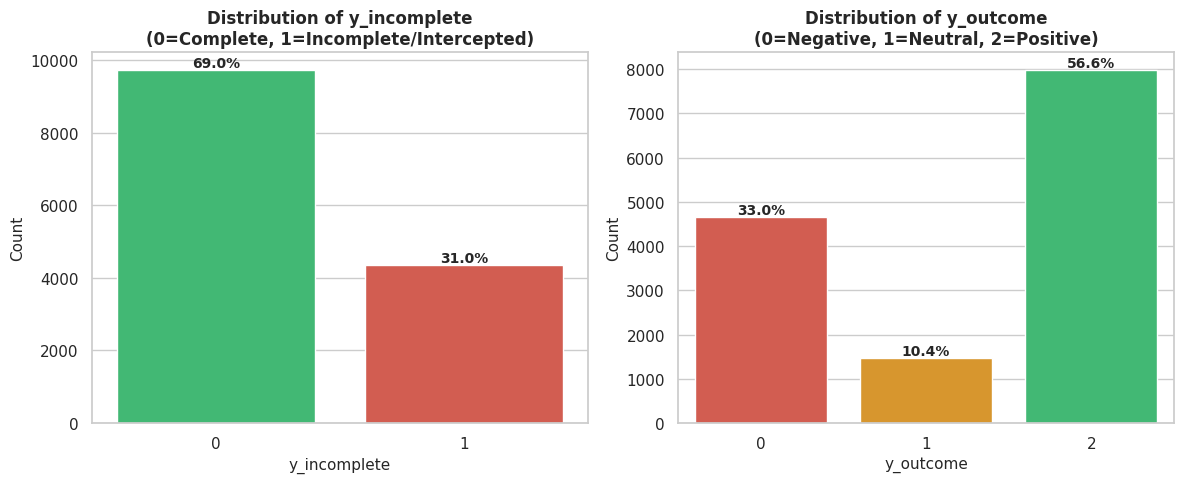

In [40]:
df = load_and_prepare(DATA_PATH)
print("Loaded data shape:", df.shape)
print("Label counts:\n", df["y_incomplete"].value_counts())

# Plot distributions of outcome variables. Add colors to catagories for clarity. Display % on bars.
# Do not use one-hot encoding on these categorical target variables.
# Define color palettes for clarity

# Define color palettes for clarity
incomplete_colors = ['#2ecc71', '#e74c3c']  # Green for complete (0), Red for incomplete (1)
outcome_colors = ['#e74c3c', '#f39c12', '#2ecc71']  # Red for negative (0), Orange for neutral (1), Green for positive (2)

plt.figure(figsize=(12, 5))

# Plot y_incomplete distribution
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x="y_incomplete", data=df, palette=incomplete_colors)
plt.title("Distribution of y_incomplete\n(0=Complete, 1=Incomplete/Intercepted)", fontsize=12, fontweight='bold')
plt.xlabel("y_incomplete", fontsize=11)
plt.ylabel("Count", fontsize=11)

# Add percentage labels on bars
total = len(df)
for p in ax1.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax1.text(p.get_x() + p.get_width()/2., height, 
             percentage, ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot y_outcome distribution
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x="y_outcome", data=df, palette=outcome_colors)
plt.title("Distribution of y_outcome\n(0=Negative, 1=Neutral, 2=Positive)", fontsize=12, fontweight='bold')
plt.xlabel("y_outcome", fontsize=11)
plt.ylabel("Count", fontsize=11)

# Add percentage labels on bars
for p in ax2.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax2.text(p.get_x() + p.get_width()/2., height, 
             percentage, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "outcome_distributions.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


## Feature Distributions and Correlations


SUMMARY STATISTICS FOR ALL PRESSURE COMPONENTS
                 Component  Count      Mean       Std  Min  25%  Median  75%   Max
Convergence Pressure Score  14105 13.440369 25.348159  0.0  0.0     0.0 33.3 100.0
   Velocity Pressure Score  14105  5.556519  9.230769  0.0  0.0     1.3  7.3  69.3
Tr Coverage Pressure Score  14105 67.476717 25.266342  0.0 52.5    76.0 88.1 100.0


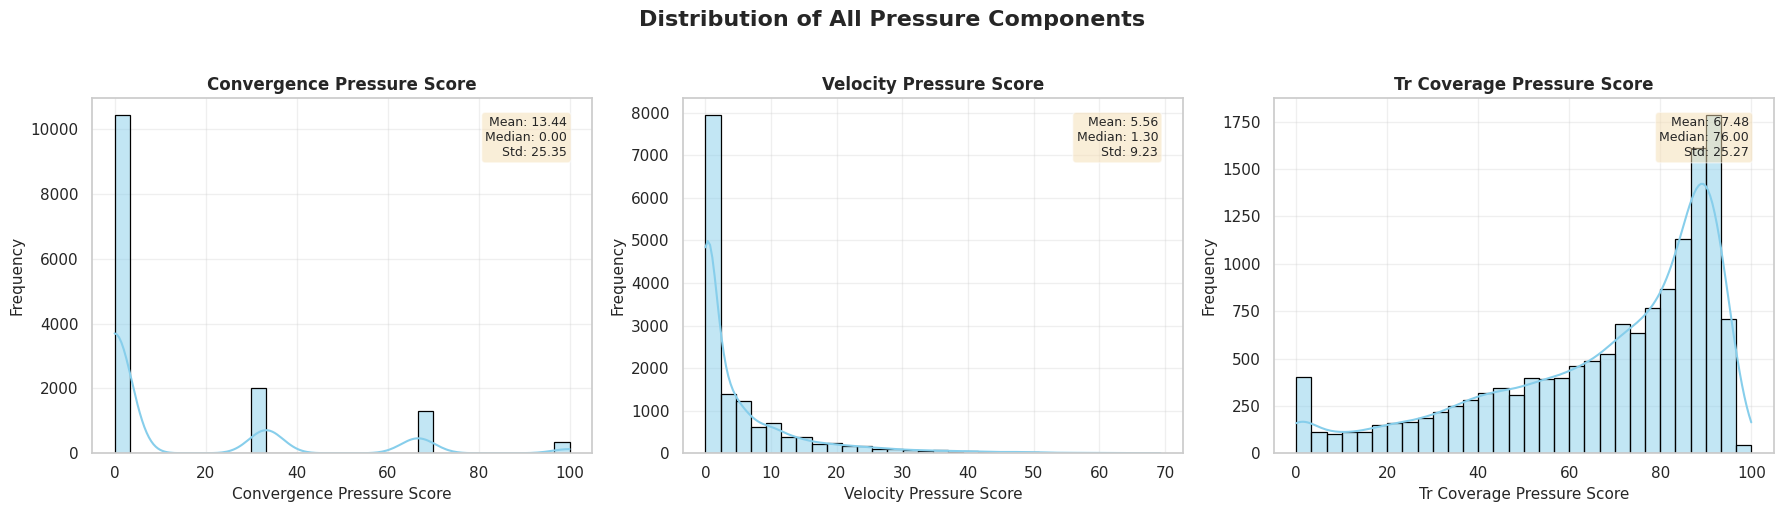

In [41]:
# For each pressure_components i.e. feature, calculate:
# Feature 1 (Receiver Coverage)
# Frequency table (if categorical: Open/Tight/Covered)
# OR summary stats (if continuous: min, max, mean, median)
# Feature 2 (QB-Defender Distance)
# Min, max, mean, median, quartiles
# Histogram to check distribution shape
# Feature 3 (Defender Velocity)
# Min, max, mean, median, quartiles
# Histogram to check distribution shape
# First, display summary statistics for all components together
print("\n" + "="*80)
print("SUMMARY STATISTICS FOR ALL PRESSURE COMPONENTS")
print("="*80)

summary_stats = []
for component in pressure_components:
    data = df[component].dropna()
    stats = {
        'Component': component.replace('_', ' ').title(),
        'Count': len(data),
        'Mean': data.mean(),
        'Std': data.std(),
        'Min': data.min(),
        '25%': data.quantile(0.25),
        'Median': data.median(),
        '75%': data.quantile(0.75),
        'Max': data.max()
    }
    summary_stats.append(stats)
    
    # print(f"\n--- {component} ---")
    # print(data.describe())

# Create a summary dataframe
summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))

# Now, plot all features together in a grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of All Pressure Components', fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    data = df[component].dropna()
    
    sns.histplot(data, bins=30, kde=True, color='skyblue', edgecolor='black', ax=axes[idx])
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(component.replace('_', ' ').title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].grid(True, alpha=0.3)
    
    # Add summary stats as text on plot
    axes[idx].text(0.95, 0.95, f'Mean: {data.mean():.2f}\nMedian: {data.median():.2f}\nStd: {data.std():.2f}',
                   transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(FIG_DIR / "all_pressure_components_distribution.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

## Feature vs. Outcome Analysis

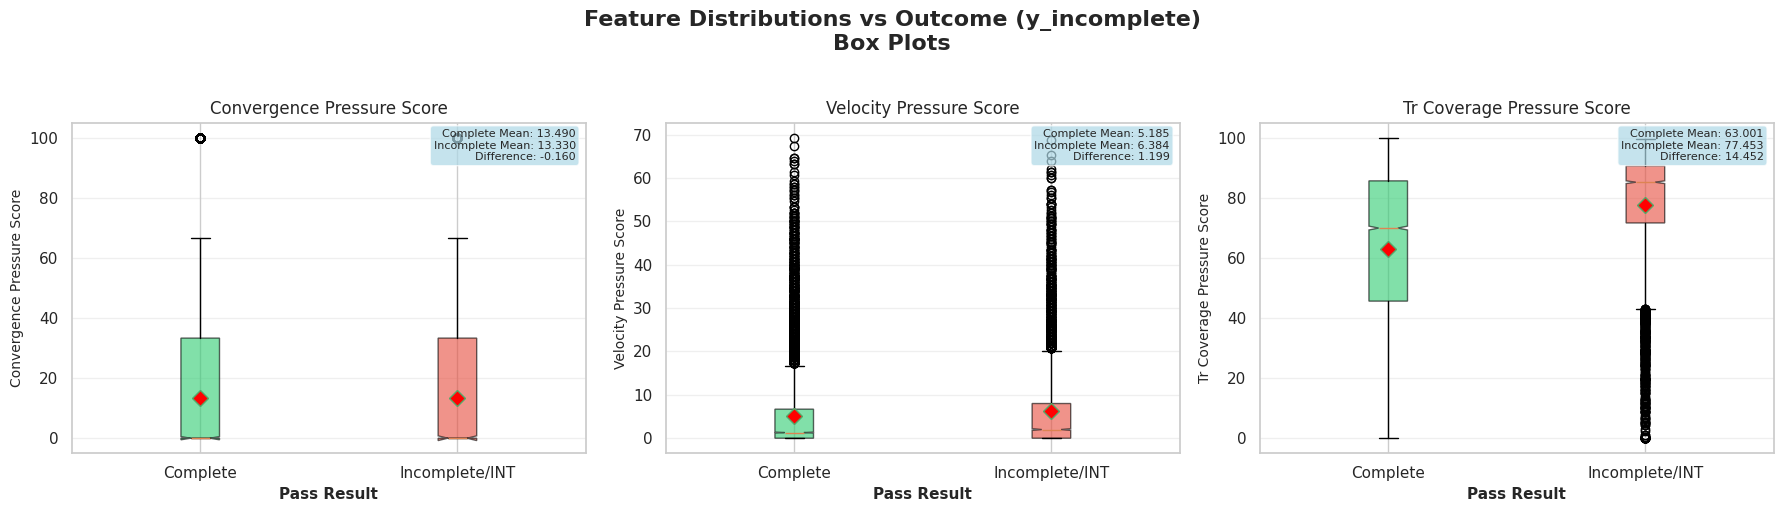

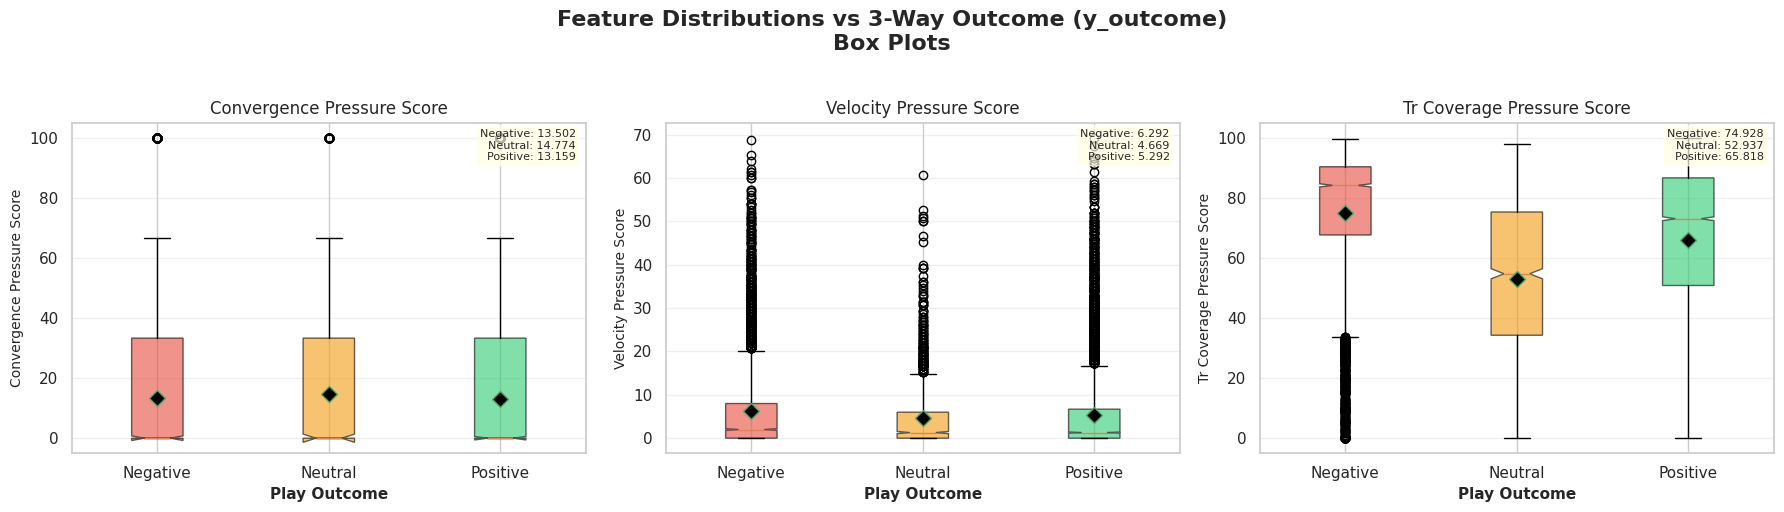

In [42]:
# Feature Distribution vs Outcome Analysis
# Create scatter plots and box plots for all pressure components vs outcome variables

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# --- BOX PLOTS: All Features vs y_incomplete ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Feature Distributions vs Outcome (y_incomplete)\nBox Plots', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    # Create box plot grouped by outcome
    box_data = [
        df[df['y_incomplete'] == 0][component].dropna(),
        df[df['y_incomplete'] == 1][component].dropna()
    ]
    
    bp = axes[idx].boxplot(box_data, 
                          labels=['Complete', 'Incomplete/INT'],
                          patch_artist=True,
                          notch=True,
                          showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    # Color the boxes
    colors = ['#2ecc71', '#e74c3c']  # Green for complete, Red for incomplete
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_xlabel('Pass Result', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(component.replace('_', ' ').title(), fontsize=10)
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistical summary
    complete_mean = df[df['y_incomplete'] == 0][component].mean()
    incomplete_mean = df[df['y_incomplete'] == 1][component].mean()
    diff = incomplete_mean - complete_mean
    
    stats_text = f'Complete Mean: {complete_mean:.3f}\nIncomplete Mean: {incomplete_mean:.3f}\nDifference: {diff:.3f}'
    axes[idx].text(0.98, 0.98, stats_text,
                  transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
                  verticalalignment='top', horizontalalignment='right',
                  fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / "features_vs_outcome_boxplot.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

# --- BOX PLOTS: All Features vs y_outcome (3-way classification) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Feature Distributions vs 3-Way Outcome (y_outcome)\nBox Plots', 
             fontsize=16, fontweight='bold', y=1.02)

for idx, component in enumerate(pressure_components):
    # Create box plot grouped by 3-way outcome
    box_data = [
        df[df['y_outcome'] == 0][component].dropna(),
        df[df['y_outcome'] == 1][component].dropna(),
        df[df['y_outcome'] == 2][component].dropna()
    ]
    
    bp = axes[idx].boxplot(box_data,
                          labels=['Negative', 'Neutral', 'Positive'],
                          patch_artist=True,
                          notch=True,
                          showmeans=True,
                          meanprops=dict(marker='D', markerfacecolor='black', markersize=8))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], outcome_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_xlabel('Play Outcome', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(component.replace('_', ' ').title(), fontsize=10)
    axes[idx].set_title(f'{component.replace("_", " ").title()}', fontsize=12)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add statistical summary
    means = [df[df['y_outcome'] == i][component].mean() for i in [0, 1, 2]]
    stats_text = f'Negative: {means[0]:.3f}\nNeutral: {means[1]:.3f}\nPositive: {means[2]:.3f}'
    axes[idx].text(0.98, 0.98, stats_text,
                  transform=axes[idx].transAxes,
                  bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7),
                  verticalalignment='top', horizontalalignment='right',
                  fontsize=8)

plt.tight_layout()
plt.savefig(FIG_DIR / "features_vs_3way_outcome_boxplot.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

In [43]:
# Import additional libraries for this analysis
from scipy.stats import chi2_contingency, kruskal, spearmanr
from scipy.stats import f_oneway

# Define outcome labels for clarity
outcome_labels = {
    0: 'Negative\n(Incomplete/≤0 yds)',
    1: 'Neutral\n(1-4 yds)',
    2: 'Positive\n(5+ yds)'
}

# Define color scheme for outcomes
outcome_colors_map = {
    0: '#e74c3c',  # Red for Negative
    1: '#f39c12',  # Orange for Neutral
    2: '#2ecc71'   # Green for Positive
}

print("\nPreparing Feature vs. Outcome Analysis...")
print(f"Total samples: {len(df)}")
print(f"Outcome distribution:\n{df['y_outcome'].value_counts().sort_index()}")


Preparing Feature vs. Outcome Analysis...
Total samples: 14105
Outcome distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64


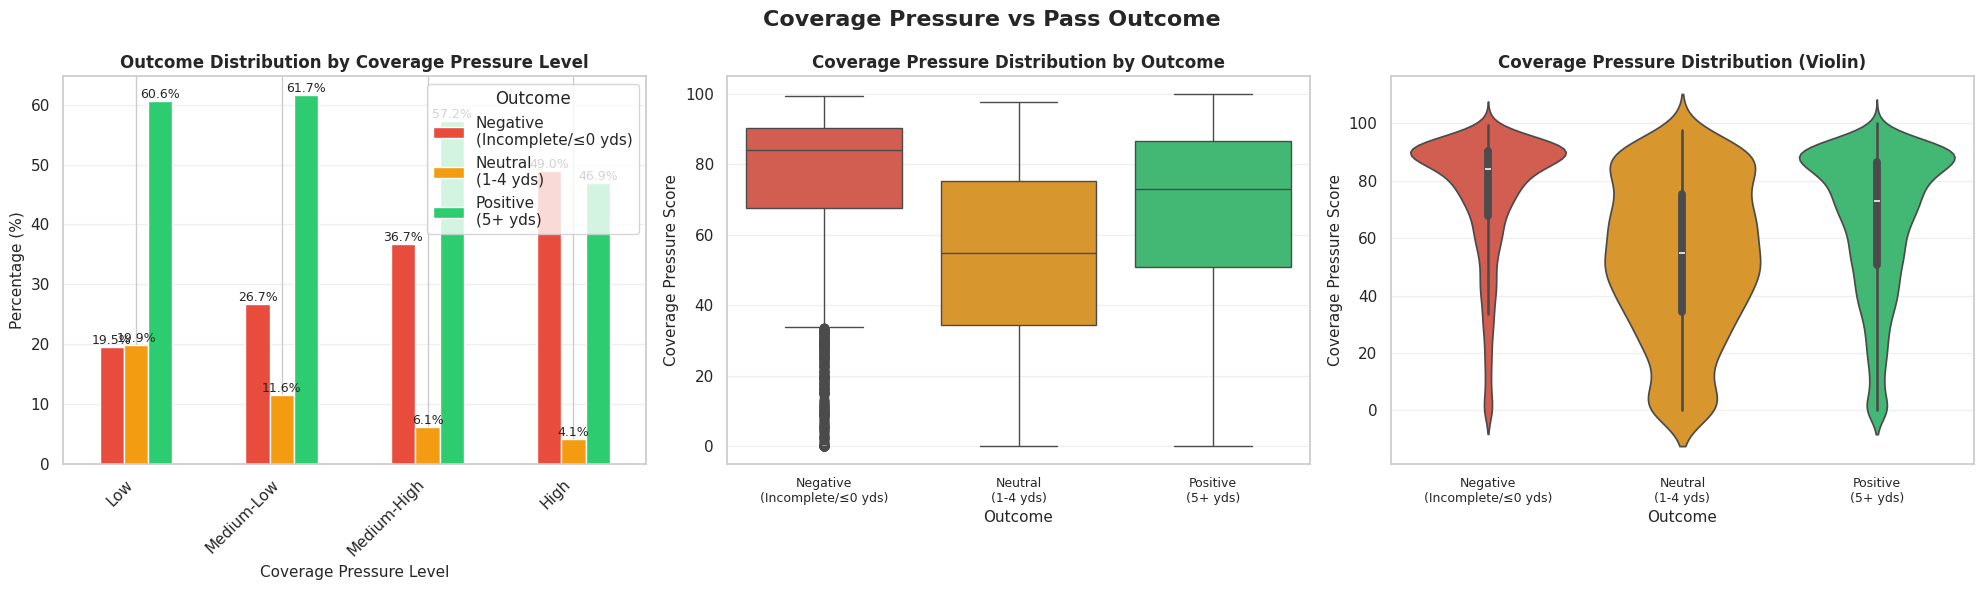


=== Coverage Pressure Analysis ===

Outcome Distribution by Coverage Pressure Level:
y_outcome         0      1      2
coverage_bin                     
Low           19.48  19.88  60.63
Medium-Low    26.75  11.57  61.68
Medium-High   36.66   6.09  57.24
High          49.02   4.12  46.86

Coverage Pressure Statistics by Outcome:
            count    mean     std  min    25%   50%    75%    max
y_outcome                                                        
0          4648.0  74.928  22.273  0.0  67.60  84.1  90.30   99.4
1          1471.0  52.937  26.827  0.0  34.25  54.7  75.25   97.8
2          7986.0  65.818  25.147  0.0  50.80  73.0  86.60  100.0


In [44]:
# Analyze Coverage Pressure vs Outcome
coverage_feature = 'tr_coverage_pressure_score'

# Create bins for coverage pressure (quartiles)
df['coverage_bin'] = pd.qcut(df[coverage_feature], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'], duplicates='drop')

# Calculate outcome distribution by coverage bin
coverage_outcome_crosstab = pd.crosstab(df['coverage_bin'], df['y_outcome'], normalize='index') * 100

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Coverage Pressure vs Pass Outcome', fontsize=16, fontweight='bold')

# 1. Grouped Bar Chart - Success Rate by Coverage Bin
coverage_outcome_crosstab.plot(kind='bar', ax=axes[0], color=[outcome_colors_map[i] for i in range(3)])
axes[0].set_title('Outcome Distribution by Coverage Pressure Level', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Coverage Pressure Level', fontsize=11)
axes[0].set_ylabel('Percentage (%)', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(title='Outcome', labels=[outcome_labels[i] for i in range(3)], loc='upper right')
axes[0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f%%', fontsize=9)

# 2. Boxplot - Coverage Pressure Distribution by Outcome
df_coverage_plot = df[[coverage_feature, 'y_outcome']].copy()
df_coverage_plot['y_outcome_label'] = df_coverage_plot['y_outcome'].map(outcome_labels)

sns.boxplot(data=df_coverage_plot, x='y_outcome', y=coverage_feature, 
            palette=[outcome_colors_map[i] for i in range(3)], ax=axes[1])
axes[1].set_title('Coverage Pressure Distribution by Outcome', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Outcome', fontsize=11)
axes[1].set_ylabel('Coverage Pressure Score', fontsize=11)
axes[1].set_xticklabels([outcome_labels[i] for i in range(3)], fontsize=9)
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Violin Plot - Coverage Pressure Distribution
sns.violinplot(data=df_coverage_plot, x='y_outcome', y=coverage_feature,
               palette=[outcome_colors_map[i] for i in range(3)], ax=axes[2], inner='box')
axes[2].set_title('Coverage Pressure Distribution (Violin)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Outcome', fontsize=11)
axes[2].set_ylabel('Coverage Pressure Score', fontsize=11)
axes[2].set_xticklabels([outcome_labels[i] for i in range(3)], fontsize=9)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / "coverage_pressure_vs_outcome.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

# Print summary statistics
print("\n=== Coverage Pressure Analysis ===")
print("\nOutcome Distribution by Coverage Pressure Level:")
print(coverage_outcome_crosstab.round(2))

print("\nCoverage Pressure Statistics by Outcome:")
print(df.groupby('y_outcome')[coverage_feature].describe().round(3))

## Feature Correlations

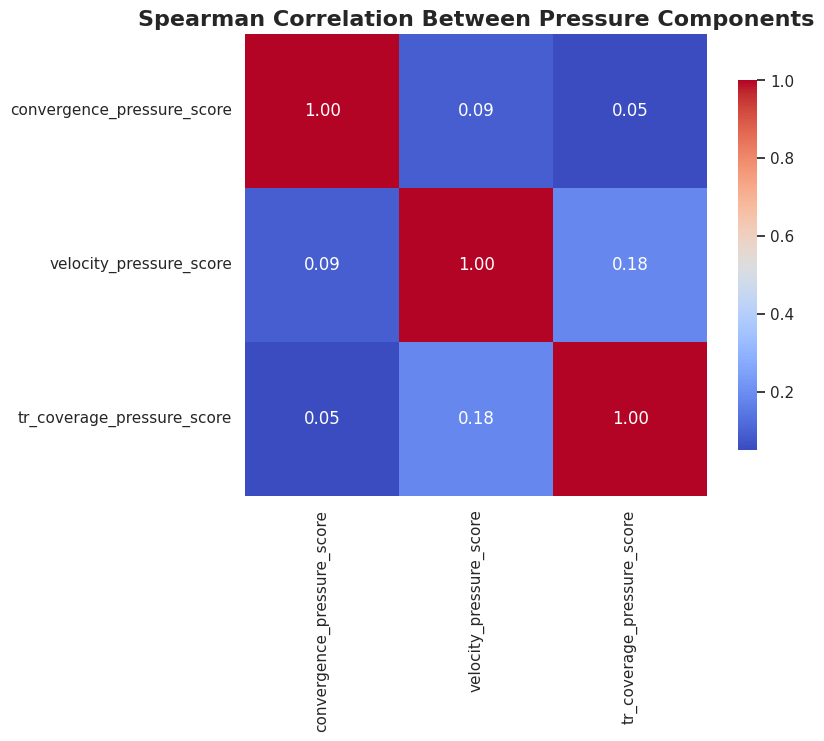

In [45]:
# Feature Interactions. Check correlation and 2d heatmap between features for visualization
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
# Compute correlation matrix
corr = df[pressure_components].corr(method='spearman')
# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Spearman Correlation Between Pressure Components", fontsize=16, fontweight='bold')
plt.savefig(FIG_DIR / "feature_correlation_heatmap.png", dpi=300, bbox_inches='tight')
if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


# Baseline Model Evaluation
## Evaluate pressure components (Individual, pairwise, and combined) for predicting y_outcome variables

In [46]:
# Update the evaluation functions to use y_outcome
from itertools import combinations
from sklearn.metrics import classification_report

def cross_val_probs_multiclass(model, X, y, cv):
    """Return cross-validated predicted probabilities for all classes."""
    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)
    return y_proba

def evaluate_component_3way(df, component_name, cv):
    """Evaluate a single component for 3-way classification."""
    print(f"\n=== Evaluating component: {component_name} (3-way) ===")
    X = df[[component_name]].values.reshape(-1, 1)
    y = df["y_outcome"].values
    print("Count:", len(y))
    print("Class distribution:\n", pd.Series(y).value_counts().sort_index())
    
    # Feature stats
    stats = {
        'mean': np.nanmean(X),
        'std': np.nanstd(X), 
        'min': np.nanmin(X),
        'max': np.nanmax(X)
    }
    print("Feature stats: mean={:.4f}, std={:.4f}, min={:.4f}, max={:.4f}".format(
        stats['mean'], stats['std'], stats['min'], stats['max']
    ))
    
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # Use multinomial logistic regression
    model = LogisticRegression(solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE) #multi_class='multinomial'
    proba = cross_val_probs_multiclass(model, Xs, y, cv)
    
    # Calculate one-vs-rest ROC AUC for each class
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import label_binarize
    
    y_bin = label_binarize(y, classes=[0, 1, 2])
    roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
    roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
    
    print(f"CV ROC AUC (OvR): {roc_auc_ovr:.4f}")
    print(f"CV ROC AUC (OvO): {roc_auc_ovo:.4f}")
    
    # Get predictions and confusion matrix
    y_pred = np.argmax(proba, axis=1)
    cm = confusion_matrix(y, y_pred)
    print("Confusion matrix:\n", cm)
    
    # Calculate per-class metrics
    from sklearn.metrics import classification_report
    print("\nClassification Report:")
    print(classification_report(y, y_pred, 
                                target_names=['Negative', 'Neutral', 'Positive'],
                                digits=3))

    return {
        "component": component_name,
        "roc_auc_ovr": roc_auc_ovr,
        "roc_auc_ovo": roc_auc_ovo,
        "stats": stats,
        "confusion_matrix": cm,
        "plot_data": {
            "probabilities": proba,
            "y_true": y,
            "y_pred": y_pred
        }
    }

def evaluate_combined_3way(df, features, cv):
    """Evaluate combined models for 3-way classification."""
    print("\n=== Evaluating combined model (3-way) ===")
    X = df[features].values
    y = df["y_outcome"].values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    log = LogisticRegression(solver='lbfgs', 
                            max_iter=1000, random_state=RANDOM_STATE) #multi_class='multinomial'
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

    proba_log = cross_val_probs_multiclass(log, Xs, y, cv)
    proba_rf = cross_val_probs_multiclass(rf, Xs, y, cv)
    
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y, classes=[0, 1, 2])

    results = {}
    for name, proba in [("Logistic", proba_log), ("RandomForest", proba_rf)]:
        roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
        roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
        
        y_pred = np.argmax(proba, axis=1)
        cm = confusion_matrix(y, y_pred)
        
        print(f"\n{name}:")
        print(f"  ROC AUC (OvR): {roc_auc_ovr:.4f}")
        print(f"  ROC AUC (OvO): {roc_auc_ovo:.4f}")
        print(f"  Confusion Matrix:\n{cm}")
        print(f"\n  Classification Report:")
        print(classification_report(y, y_pred, 
                                   target_names=['Negative', 'Neutral', 'Positive'],
                                   digits=3))
        
        results[name.lower()] = {
            "roc_auc_ovr": roc_auc_ovr,
            "roc_auc_ovo": roc_auc_ovo,
            "confusion_matrix": cm,
            "probabilities": proba,
            "y_pred": y_pred
        }

    # Permutation importance
    rf.fit(Xs, y)
    perm = permutation_importance(rf, Xs, y, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
    importances = pd.Series(perm.importances_mean, index=features).sort_values(ascending=False)
    print("\nPermutation importances (combined RF):")
    print(importances.round(4))

    return {
        "results": results,
        "importances": importances,
        "y_true": y
    }

def evaluate_component_pairs_3way(df, components, cv):
    """Evaluate pairwise combinations for 3-way classification."""
    print("\n=== Evaluating pairwise combinations (3-way) ===")
    
    component_pairs = list(combinations(components, 2))
    pair_results = {}
    
    from sklearn.preprocessing import label_binarize
    
    for pair in component_pairs:
        pair_name = f"{pair[0]} + {pair[1]}"
        print(f"\n--- Evaluating pair: {pair_name} ---")
        
        X = df[list(pair)].values
        y = df["y_outcome"].values
        y_bin = label_binarize(y, classes=[0, 1, 2])
        
        scaler = StandardScaler()
        Xs = scaler.fit_transform(X)

        log = LogisticRegression(solver='lbfgs', 
                                max_iter=1000, random_state=RANDOM_STATE) #multi_class='multinomial'
        rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)

        proba_log = cross_val_probs_multiclass(log, Xs, y, cv)
        proba_rf = cross_val_probs_multiclass(rf, Xs, y, cv)

        pair_results[pair_name] = {}
        
        for model_name, proba in [("Logistic", proba_log), ("RandomForest", proba_rf)]:
            roc_auc_ovr = roc_auc_score(y_bin, proba, average='weighted', multi_class='ovr')
            roc_auc_ovo = roc_auc_score(y, proba, average='weighted', multi_class='ovo')
            
            y_pred = np.argmax(proba, axis=1)
            cm = confusion_matrix(y, y_pred)
            
            print(f"{model_name} CV ROC AUC (OvR): {roc_auc_ovr:.4f}, (OvO): {roc_auc_ovo:.4f}")
            
            pair_results[pair_name][model_name.lower()] = {
                "roc_auc_ovr": roc_auc_ovr,
                "roc_auc_ovo": roc_auc_ovo,
                "confusion_matrix": cm,
                "probabilities": proba,
                "y_pred": y_pred,
                "features": list(pair)
            }

        # Permutation importance
        rf_full = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
        rf_full.fit(Xs, y)
        perm = permutation_importance(rf_full, Xs, y, n_repeats=20, random_state=RANDOM_STATE, n_jobs=-1)
        importances = pd.Series(perm.importances_mean, index=pair).sort_values(ascending=False)
        print(f"Permutation importances:")
        print(importances.round(4))
        
        pair_results[pair_name]["importances"] = importances
        pair_results[pair_name]["y_true"] = y
    
    return pair_results

# Update main function for 3-way classification
def main_3way():
    if not DATA_PATH.exists():
        current_dir = Path.cwd()
        abs_path = DATA_PATH.resolve()
        print(f"ERROR: Data file not found!")
        print(f"Current working directory: {current_dir}")
        print(f"Looking for file at: {abs_path}")
        return None, None, None, None
    
    df = load_and_prepare(DATA_PATH)
    print("Loaded data shape:", df.shape)
    print("y_outcome counts:\n", df["y_outcome"].value_counts().sort_index())
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    # Evaluate individual components
    component_results = []
    for comp in pressure_components:
        res = evaluate_component_3way(df, comp, cv)
        component_results.append(res)
    
    # Evaluate pairwise combinations
    pair_results = evaluate_component_pairs_3way(df, pressure_components, cv)
    
    # Evaluate combined models
    combined_results = evaluate_combined_3way(df, pressure_components, cv)
    
    # Create summary
    summary_data = []
    
    for result in component_results:
        summary_data.append({
            'Type': 'Individual',
            'Features': result['component'],
            'Model': 'Logistic',
            'ROC_AUC_OvR': result['roc_auc_ovr'],
            'ROC_AUC_OvO': result['roc_auc_ovo']
        })
    
    for pair_name, results in pair_results.items():
        for model_name in ['logistic', 'randomforest']:
            if model_name in results:
                summary_data.append({
                    'Type': 'Pairwise',
                    'Features': pair_name,
                    'Model': model_name.title(),
                    'ROC_AUC_OvR': results[model_name]['roc_auc_ovr'],
                    'ROC_AUC_OvO': results[model_name]['roc_auc_ovo']
                })
    
    for model_name, results in combined_results['results'].items():
        summary_data.append({
            'Type': 'Combined_All',
            'Features': 'All 3 Components',
            'Model': model_name.title(),
            'ROC_AUC_OvR': results['roc_auc_ovr'],
            'ROC_AUC_OvO': results['roc_auc_ovo']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('ROC_AUC_OvR', ascending=False)
    
    print("\n=== 3-WAY CLASSIFICATION PERFORMANCE SUMMARY ===")
    # Format numeric columns to 4 decimal places
    summary_display = summary_df.copy()
    summary_display['ROC_AUC_OvR'] = summary_display['ROC_AUC_OvR'].map('{:.4f}'.format)
    summary_display['ROC_AUC_OvO'] = summary_display['ROC_AUC_OvO'].map('{:.4f}'.format)
    print(summary_display.to_string(index=False))
    
    return component_results, pair_results, combined_results, summary_df

# Run the 3-way analysis
component_res_3way, pair_res_3way, combined_res_3way, summary_df_3way = main_3way()


3-Way Outcome Distribution:
y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64
  0 (Negative Play): 4648 plays - Incomplete or ≤0 yards
  1 (Neutral Play):  1471 plays - Complete with 1-4 yards
  2 (Positive Play): 7986 plays - Complete with 5+ yards

Binary Classification (y_incomplete) Distribution:
  0 (Complete): 9737 plays
  1 (Incomplete/Intercepted): 4368 plays

Route Type Distribution:
route_type
DEEP            2675
INTERMEDIATE    5359
SHORT           6069
Name: count, dtype: int64

Missing route_type values: 2
Loaded data shape: (14105, 46)
y_outcome counts:
 y_outcome
0    4648
1    1471
2    7986
Name: count, dtype: int64

=== Evaluating component: convergence_pressure_score (3-way) ===
Count: 14105
Class distribution:
 0    4648
1    1471
2    7986
Name: count, dtype: int64
Feature stats: mean=13.4404, std=25.3473, min=0.0000, max=100.0000
CV ROC AUC (OvR): 0.4957
CV ROC AUC (OvO): 0.4954
Confusion matrix:
 [[   0    0 4648]
 [   0    0 1471]
 [   0    0 7

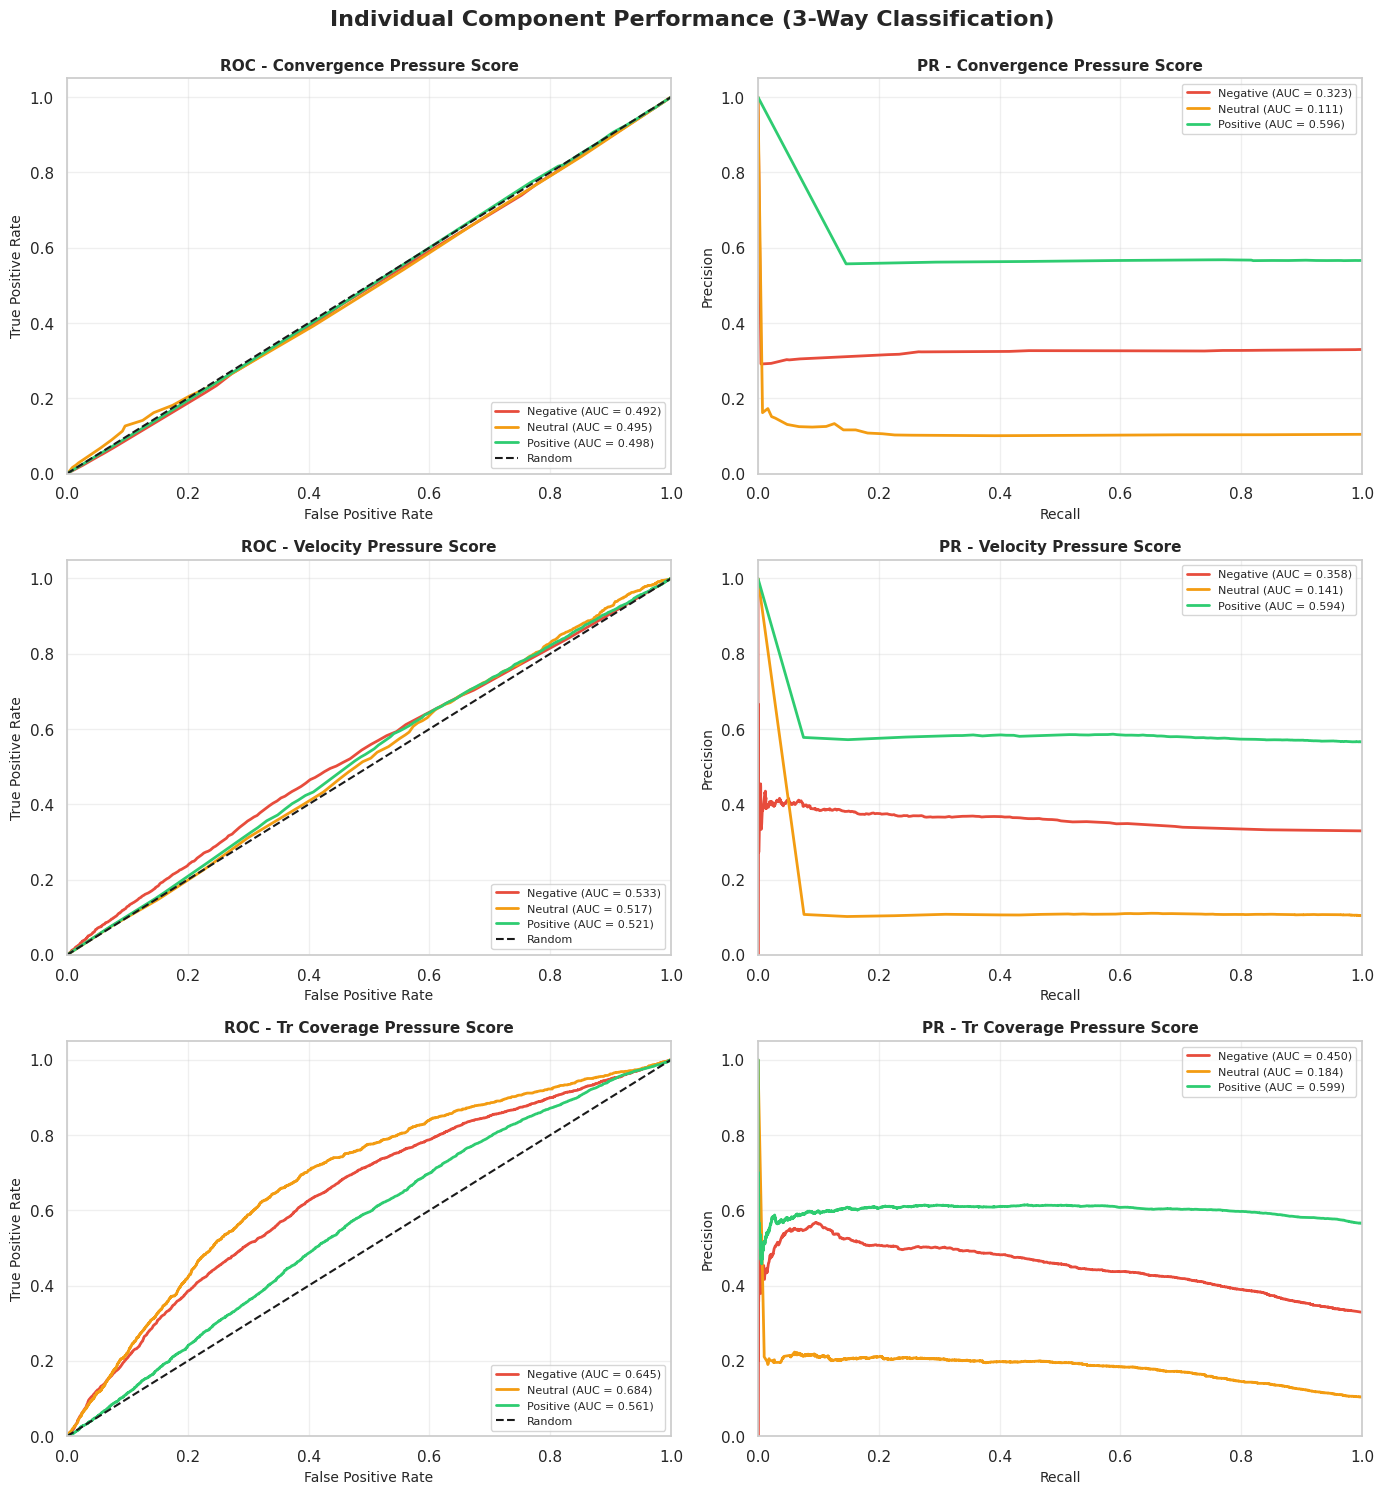

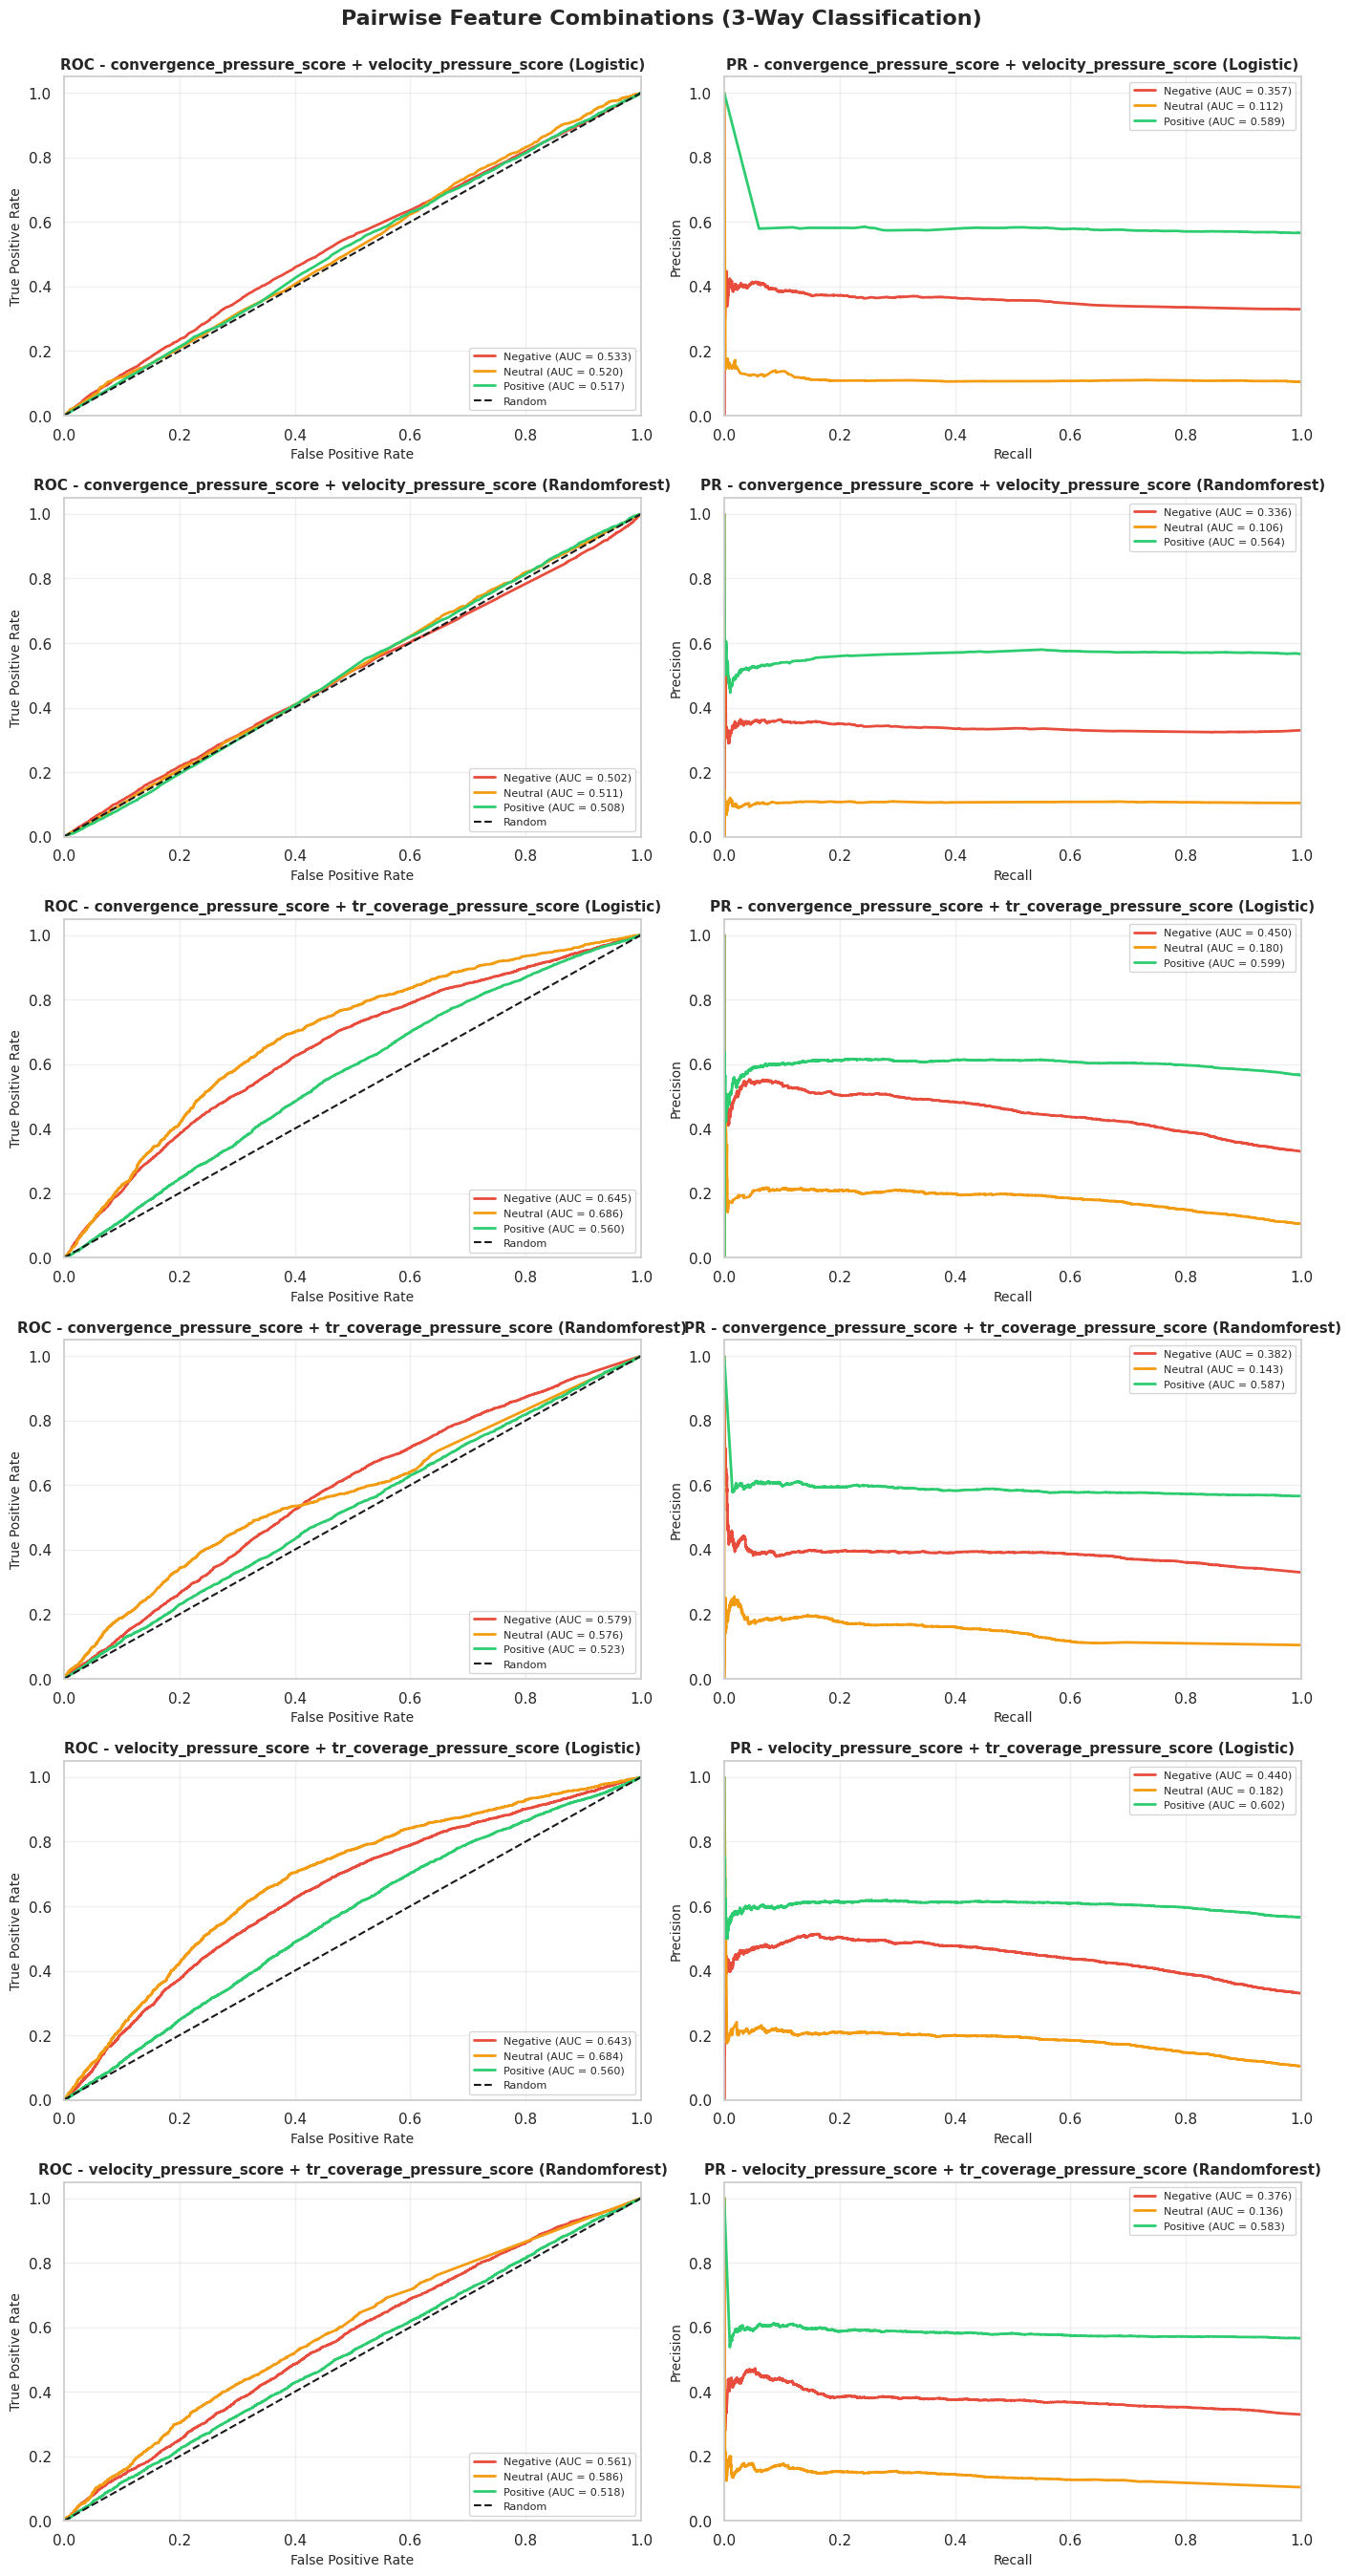

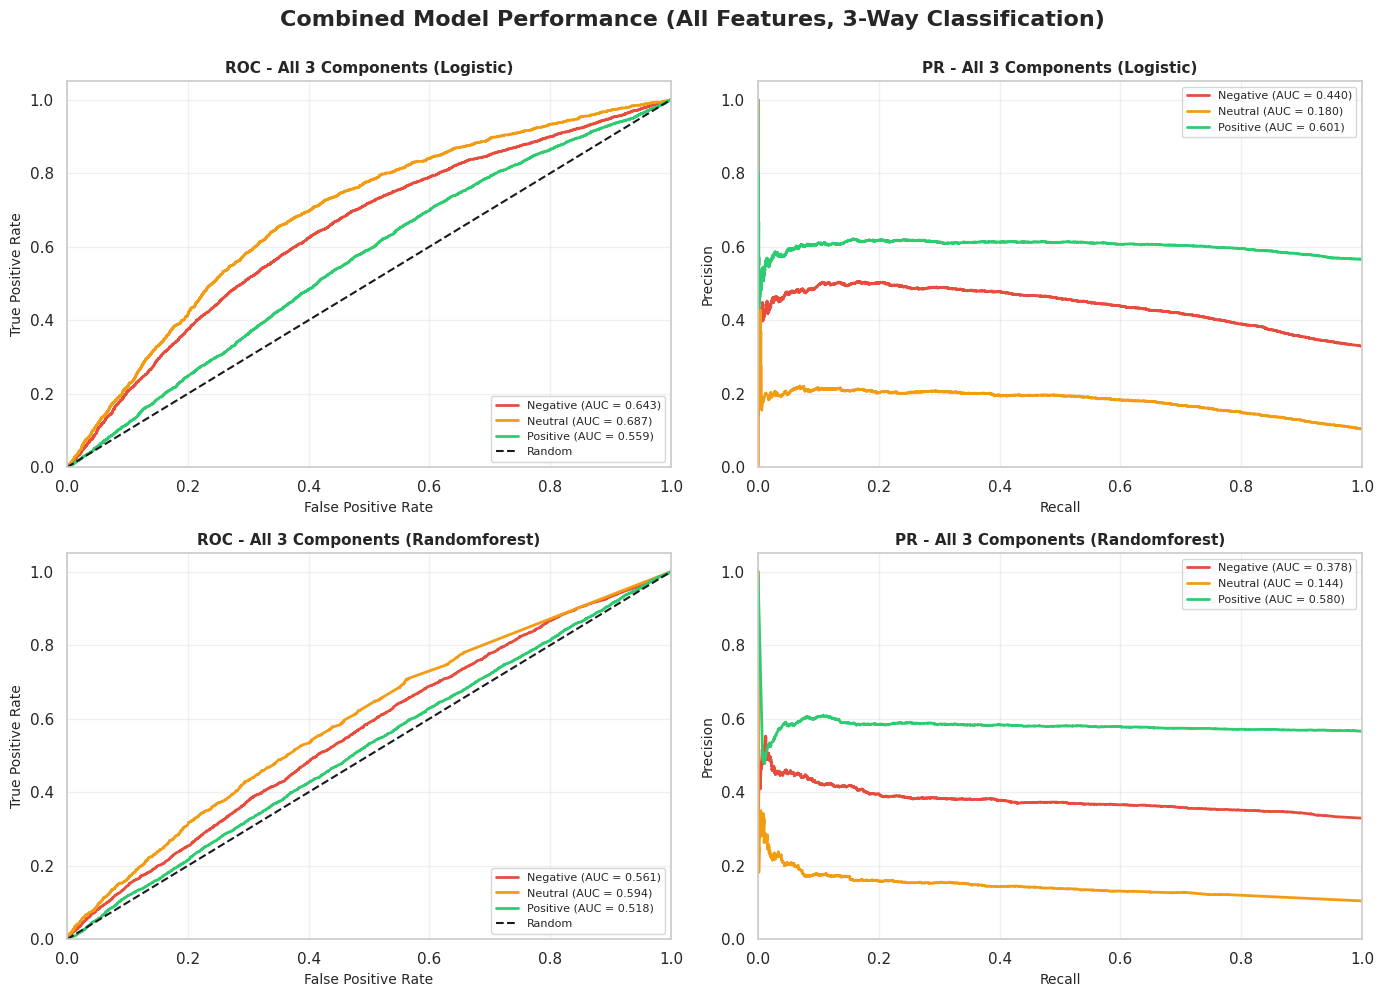


✓ Clustered ROC/PR plots saved:
  • figures/cluster_01_individual_components.png
  • figures/cluster_02_pairwise_combinations.png
  • figures/cluster_03_combined_models.png


In [47]:
def plot_multiclass_roc_pr_curves(component_results, pair_results, combined_results, output_dir):
    """
    Plot ROC and PR curves for multi-class classification with clustered subplots.
    Creates 3 summary figures: Individual, Pairwise, and Combined models.
    """
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc, precision_recall_curve
    
    class_names = ['Negative', 'Neutral', 'Positive']
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    
    def plot_single_model_curves(ax_roc, ax_pr, y_true, y_proba, title):
        """Helper to plot ROC and PR curves on given axes."""
        y_bin = label_binarize(y_true, classes=[0, 1, 2])
        
        # ROC Curve
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            ax_roc.plot(fpr, tpr, color=color, lw=2, 
                       label=f'{class_name} (AUC = {roc_auc:.3f})')
        
        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.set_xlabel('False Positive Rate', fontsize=10)
        ax_roc.set_ylabel('True Positive Rate', fontsize=10)
        ax_roc.set_title(f'ROC - {title}', fontsize=11, fontweight='bold')
        ax_roc.legend(loc='lower right', fontsize=8)
        ax_roc.grid(True, alpha=0.3)
        
        # PR Curve
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            precision, recall, _ = precision_recall_curve(y_bin[:, i], y_proba[:, i])
            pr_auc = auc(recall, precision)
            ax_pr.plot(recall, precision, color=color, lw=2,
                      label=f'{class_name} (AUC = {pr_auc:.3f})')
        
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_xlabel('Recall', fontsize=10)
        ax_pr.set_ylabel('Precision', fontsize=10)
        ax_pr.set_title(f'PR - {title}', fontsize=11, fontweight='bold')
        ax_pr.legend(loc='best', fontsize=8)
        ax_pr.grid(True, alpha=0.3)
    
    # =========================================================================
    # CLUSTER 1: INDIVIDUAL COMPONENTS (3 rows x 2 cols)
    # =========================================================================
    n_individual = len(component_results)
    fig, axes = plt.subplots(n_individual, 2, figsize=(14, 5*n_individual))
    fig.suptitle('Individual Component Performance (3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, result in enumerate(component_results):
        ax_roc = axes[idx, 0] if n_individual > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_individual > 1 else axes[1]
        
        plot_single_model_curves(
            ax_roc, ax_pr,
            y_true=result['plot_data']['y_true'],
            y_proba=result['plot_data']['probabilities'],
            title=result["component"].replace('_', ' ').title()
        )
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_01_individual_components.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    # =========================================================================
    # CLUSTER 2: PAIRWISE COMBINATIONS (N pairs x 2 models = 2N rows x 2 cols)
    # =========================================================================
    pair_plot_specs = []
    for pair_name, pair_data in pair_results.items():
        for model_name in ['logistic', 'randomforest']:
            pair_plot_specs.append({
                'y_true': pair_data['y_true'],
                'y_proba': pair_data[model_name]['probabilities'],
                'title': f"{pair_name} ({model_name.title()})"
            })
    
    n_pairs = len(pair_plot_specs)
    fig, axes = plt.subplots(n_pairs, 2, figsize=(14, 4.5*n_pairs))
    fig.suptitle('Pairwise Feature Combinations (3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.998)
    
    for idx, spec in enumerate(pair_plot_specs):
        ax_roc = axes[idx, 0] if n_pairs > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_pairs > 1 else axes[1]
        
        plot_single_model_curves(ax_roc, ax_pr, **spec)
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_02_pairwise_combinations.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    # =========================================================================
    # CLUSTER 3: COMBINED MODELS (2 models x 2 cols)
    # =========================================================================
    combined_plot_specs = []
    for model_name, model_data in combined_results['results'].items():
        combined_plot_specs.append({
            'y_true': combined_results['y_true'],
            'y_proba': model_data['probabilities'],
            'title': f'All 3 Components ({model_name.title()})'
        })
    
    n_combined = len(combined_plot_specs)
    fig, axes = plt.subplots(n_combined, 2, figsize=(14, 5*n_combined))
    fig.suptitle('Combined Model Performance (All Features, 3-Way Classification)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    for idx, spec in enumerate(combined_plot_specs):
        ax_roc = axes[idx, 0] if n_combined > 1 else axes[0]
        ax_pr = axes[idx, 1] if n_combined > 1 else axes[1]
        
        plot_single_model_curves(ax_roc, ax_pr, **spec)
    
    plt.tight_layout()
    plt.savefig(output_dir / "cluster_03_combined_models.png", dpi=300, bbox_inches='tight')
    plt.show() if SHOW_PLOTS else plt.close()
    
    print(f"\n✓ Clustered ROC/PR plots saved:")
    print(f"  • {output_dir / 'cluster_01_individual_components.png'}")
    print(f"  • {output_dir / 'cluster_02_pairwise_combinations.png'}")
    print(f"  • {output_dir / 'cluster_03_combined_models.png'}")

# Generate clustered plots
plot_multiclass_roc_pr_curves(component_res_3way, pair_res_3way, combined_res_3way, FIG_DIR)

# Evaluate each component with Route

In [48]:
# Analyze categorical features vs outcome
# list the catagories in column 'route_type' and route_of_targeted_receiver
df['route_type'].unique()
# Get 2-way frequency table of 'route_type' vs 'y_outcome'
freq_table = pd.crosstab(df['route_type'], df['y_outcome'])
print("\nFrequency table of 'route_type' vs 'y_outcome':")
print(freq_table)


# list the catagories in column 'route_of_targeted_receiver'    
df['route_of_targeted_receiver'].unique()
# Get 2-way frequency table of 'route_of_targeted_receiver' vs 'y_outcome'
freq_table_targeted = pd.crosstab(df['route_of_targeted_receiver'], df['y_outcome'])
print("\nFrequency table of 'route_of_targeted_receiver' vs 'y_outcome':")
print(freq_table_targeted)

                                                                    


Frequency table of 'route_type' vs 'y_outcome':
y_outcome        0    1     2
route_type                   
DEEP          1412   29  1234
INTERMEDIATE  1695  548  3116
SHORT         1540  893  3636

Frequency table of 'route_of_targeted_receiver' vs 'y_outcome':
y_outcome                     0    1     2
route_of_targeted_receiver                
ANGLE                        98  102   343
CORNER                      250   12   247
CROSS                       474  167   855
FLAT                        477  553   953
GO                          816   10   571
HITCH                       641  216  1803
IN                          442   46   618
OUT                         681  233  1300
POST                        346    7   416
SCREEN                       78   77   146
SLANT                       304   47   698
WHEEL                        40    0    36


## Descriptive Statistics and Visualizations by Route Type
Sample Size and Distribution Analysis
Route Type Distribution Visualization
Outcome Distribution by Route Type
Outcome Visualization - Grouped Bar Charts
Outcome Visualization - Stacked Proportions
Yards Gained Analysis - Complete Passes Only
Yards Gained Visualization by Route Type
Risk-Reward Profile Summary

ROUTE TYPE DESCRIPTIVE ANALYSIS

1A. SAMPLE SIZE & DISTRIBUTION

Overall Route Type Distribution:
  Route Type  Total Plays (n)  % of Dataset
        DEEP             2675         18.97
INTERMEDIATE             5359         38.00
       SHORT             6069         43.03

Individual Routes within Each Group:
  route_type route_of_targeted_receiver  Count  % within Group
        DEEP                         GO   1397           52.22
        DEEP                       POST    769           28.75
        DEEP                     CORNER    509           19.03
INTERMEDIATE                        OUT   2214           41.31
INTERMEDIATE                      CROSS   1496           27.92
INTERMEDIATE                         IN   1106           20.64
INTERMEDIATE                      ANGLE    543           10.13
       SHORT                      HITCH   2660           43.83
       SHORT                       FLAT   1983           32.67
       SHORT                      SLANT   1049           1

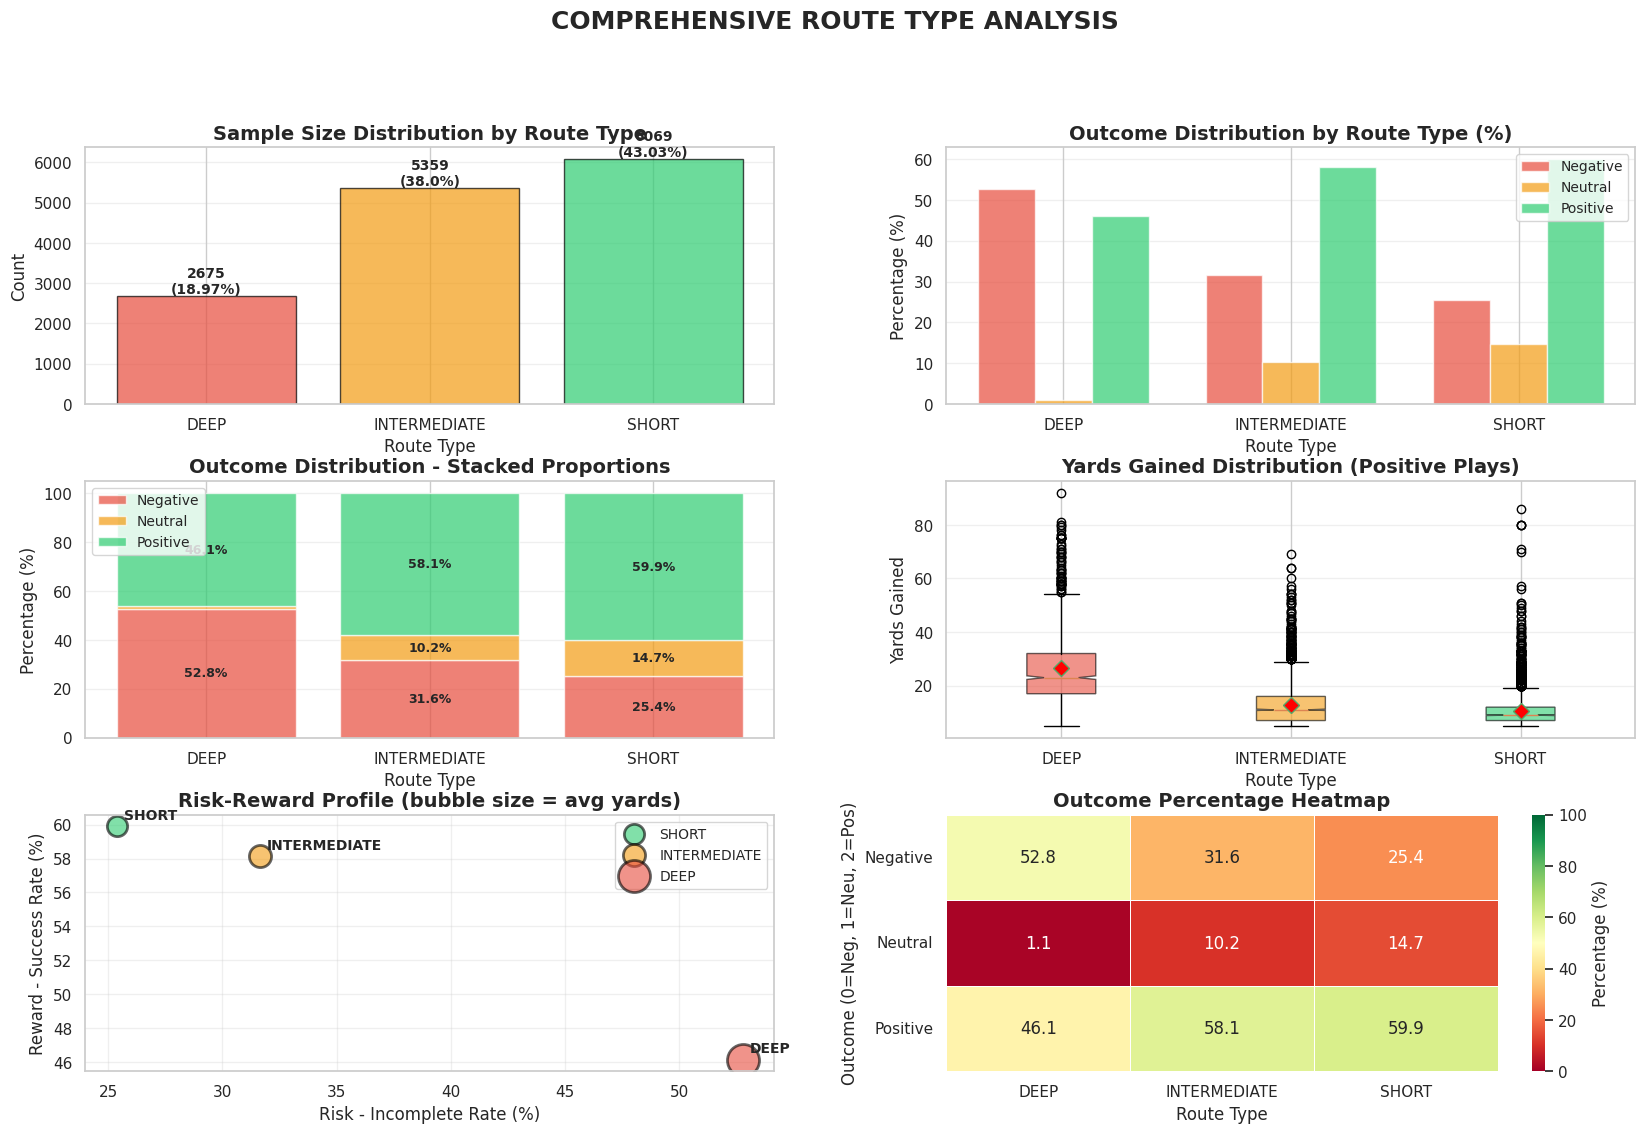


✓ Comprehensive visualization saved: figures/route_type_comprehensive_analysis.png


In [49]:
# ============================================================================
# COMPREHENSIVE ROUTE TYPE DESCRIPTIVE ANALYSIS
# ============================================================================

# Filter out missing route_type values
df_route = df[df['route_type'].notna()].copy()

print("="*100)
print("ROUTE TYPE DESCRIPTIVE ANALYSIS")
print("="*100)

# ----------------------------------------------------------------------------
# 1A. SAMPLE SIZE & DISTRIBUTION ANALYSIS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1A. SAMPLE SIZE & DISTRIBUTION")
print("="*100)

# Calculate counts and percentages using vectorized operations
route_counts = df_route['route_type'].value_counts().sort_index()
route_pcts = (route_counts / len(df_route) * 100).round(2)

# Create summary dataframe
sample_size_summary = pd.DataFrame({
    'Route Type': route_counts.index,
    'Total Plays (n)': route_counts.values,
    '% of Dataset': route_pcts.values
})

print("\nOverall Route Type Distribution:")
print(sample_size_summary.to_string(index=False))

# Individual routes within each group
print("\nIndividual Routes within Each Group:")
route_detail = df_route.groupby(['route_type', 'route_of_targeted_receiver']).size().reset_index(name='Count')
route_detail['% within Group'] = route_detail.groupby('route_type')['Count'].transform(lambda x: (x / x.sum() * 100).round(2))
route_detail = route_detail.sort_values(['route_type', 'Count'], ascending=[True, False])
print(route_detail.to_string(index=False))
# Save sample size summary to CSV
sample_size_summary.to_csv(FIG_DIR / "route_type_sample_size_distribution.csv", index=False)
print(f"\n✓ Sample size summary saved to: {FIG_DIR / 'route_type_sample_size_distribution.csv'}")

# ----------------------------------------------------------------------------
# 1B. OUTCOME DISTRIBUTION BY ROUTE TYPE
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1B. OUTCOME DISTRIBUTION BY ROUTE TYPE")
print("="*100)

# Vectorized crosstab calculation
outcome_by_route = pd.crosstab(df_route['route_type'], df_route['y_outcome'], margins=True)
outcome_pct_by_route = pd.crosstab(df_route['route_type'], df_route['y_outcome'], normalize='index') * 100

# Create comprehensive outcome summary
outcome_summary = pd.DataFrame({
    'Route Type': outcome_by_route.index[:-1],  # Exclude 'All' row
    'Negative (n)': outcome_by_route[0].values[:-1],
    'Negative (%)': outcome_pct_by_route[0].round(2).values,
    'Neutral (n)': outcome_by_route[1].values[:-1],
    'Neutral (%)': outcome_pct_by_route[1].round(2).values,
    'Positive (n)': outcome_by_route[2].values[:-1],
    'Positive (%)': outcome_pct_by_route[2].round(2).values,
    'Total': outcome_by_route['All'].values[:-1]
})

print("\nOutcome Distribution (Counts and Percentages):")
print(outcome_summary.to_string(index=False))

# Key insight: Neutral % variation
print("\n📊 KEY INSIGHT - Neutral Play Percentage by Route Type:")
neutral_pcts = outcome_pct_by_route[1].sort_values(ascending=False)
for route, pct in neutral_pcts.items():
    print(f"  {route:15s}: {pct:5.2f}% (Expected: HIGH for SHORT, LOW for DEEP)")

# Save outcome summary to CSV
outcome_summary.to_csv(FIG_DIR / "route_type_outcome_distribution.csv", index=False)
print(f"\n✓ Outcome distribution summary saved to: {FIG_DIR / 'route_type_outcome_distribution.csv'}")

# ----------------------------------------------------------------------------
# 1C. YARDS GAINED ANALYSIS (COMPLETE PASSES ONLY)
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("1C. YARDS GAINED ANALYSIS - COMPLETE PASSES ONLY")
print("="*100)

# Filter for complete passes (Positive outcomes: y_outcome == 2)
df_complete_positive = df_route[df_route['y_outcome'] == 2].copy()

# Vectorized yards gained statistics
yards_stats = df_complete_positive.groupby('route_type')['yards_gained'].agg([
    ('Count', 'count'),
    ('Mean', lambda x: x.mean()),
    ('Median', 'median'),
    ('Std', lambda x: x.std()),
    ('Min', 'min'),
    ('25%', lambda x: x.quantile(0.25)),
    ('75%', lambda x: x.quantile(0.75)),
    ('Max', 'max')
]).reset_index()

print("\nYards Gained Statistics (Positive Plays - 5+ yards):")
print(yards_stats.to_string(index=False))
# Save yards stats to CSV
yards_stats.to_csv(FIG_DIR / "route_type_yards_gained_stats.csv", index=False)
print(f"\n✓ Yards gained statistics saved to: {FIG_DIR / 'route_type_yards_gained_stats.csv'}")

# Risk-Reward Profile
print("\n" + "="*100)
print("RISK-REWARD PROFILE SUMMARY")
print("="*100)

risk_reward = pd.DataFrame({
    'Route Type': outcome_pct_by_route.index,
    'Success Rate (%)': (outcome_pct_by_route[2]).round(2),  # Positive %
    'Risk (Incomplete %)': (outcome_pct_by_route[0]).round(2),  # Negative %
    'Avg Yards (Positive)': yards_stats.set_index('route_type')['Mean'].round(2),
    'Risk/Reward Ratio': (outcome_pct_by_route[0] / outcome_pct_by_route[2]).round(2)
}).sort_values('Success Rate (%)', ascending=False)

print("\nRisk-Reward Profile (sorted by Success Rate):")
print(risk_reward.to_string(index=False))
# Save risk-reward profile to CSV
risk_reward.to_csv(FIG_DIR / "route_type_risk_reward_profile.csv", index=False)
print(f"\n✓ Risk-Reward profile saved to: {FIG_DIR / 'route_type_risk_reward_profile.csv'}")

# ----------------------------------------------------------------------------
# VISUALIZATIONS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("GENERATING VISUALIZATIONS...")
print("="*100)

# Create comprehensive figure with 6 subplots
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.25)

# Define consistent colors
route_colors = {'DEEP': '#e74c3c', 'INTERMEDIATE': '#f39c12', 'SHORT': '#2ecc71'}
outcome_colors_map = {0: '#e74c3c', 1: '#f39c12', 2: '#2ecc71'}

# Plot 1: Sample Size Distribution
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(sample_size_summary['Route Type'], sample_size_summary['Total Plays (n)'], 
               color=[route_colors[rt] for rt in sample_size_summary['Route Type']], alpha=0.7, edgecolor='black')
ax1.set_title('Sample Size Distribution by Route Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('Route Type', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.grid(True, alpha=0.3, axis='y')
for bar, pct in zip(bars, sample_size_summary['% of Dataset']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}\n({pct}%)', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Outcome Distribution - Grouped Bars
ax2 = fig.add_subplot(gs[0, 1])
x = np.arange(len(outcome_summary))
width = 0.25
ax2.bar(x - width, outcome_summary['Negative (%)'], width, label='Negative', color=outcome_colors_map[0], alpha=0.7)
ax2.bar(x, outcome_summary['Neutral (%)'], width, label='Neutral', color=outcome_colors_map[1], alpha=0.7)
ax2.bar(x + width, outcome_summary['Positive (%)'], width, label='Positive', color=outcome_colors_map[2], alpha=0.7)
ax2.set_title('Outcome Distribution by Route Type (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Route Type', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(outcome_summary['Route Type'])
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Stacked Proportions
ax3 = fig.add_subplot(gs[1, 0])
bottom = np.zeros(len(outcome_summary))
for outcome_num, color in outcome_colors_map.items():
    col_name = ['Negative (%)', 'Neutral (%)', 'Positive (%)'][outcome_num]
    values = outcome_summary[col_name].values
    ax3.bar(outcome_summary['Route Type'], values, bottom=bottom, 
            label=['Negative', 'Neutral', 'Positive'][outcome_num], color=color, alpha=0.7, edgecolor='white')
    # Add percentage labels
    for i, (v, b) in enumerate(zip(values, bottom)):
        if v > 5:  # Only show label if segment is large enough
            ax3.text(i, b + v/2, f'{v:.1f}%', ha='center', va='center', fontsize=9, fontweight='bold')
    bottom += values
ax3.set_title('Outcome Distribution - Stacked Proportions', fontsize=14, fontweight='bold')
ax3.set_xlabel('Route Type', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Yards Gained Box Plot
ax4 = fig.add_subplot(gs[1, 1])
box_data = [df_complete_positive[df_complete_positive['route_type'] == rt]['yards_gained'].values 
            for rt in ['DEEP', 'INTERMEDIATE', 'SHORT']]
bp = ax4.boxplot(box_data, labels=['DEEP', 'INTERMEDIATE', 'SHORT'], patch_artist=True,
                 notch=True, showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
for patch, route in zip(bp['boxes'], ['DEEP', 'INTERMEDIATE', 'SHORT']):
    patch.set_facecolor(route_colors[route])
    patch.set_alpha(0.6)
ax4.set_title('Yards Gained Distribution (Positive Plays)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Route Type', fontsize=12)
ax4.set_ylabel('Yards Gained', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Risk-Reward Scatter
ax5 = fig.add_subplot(gs[2, 0])
for route in risk_reward['Route Type']:
    data = risk_reward[risk_reward['Route Type'] == route]
    ax5.scatter(data['Risk (Incomplete %)'], data['Success Rate (%)'], 
                s=data['Avg Yards (Positive)']*20, color=route_colors[route], alpha=0.6, 
                edgecolors='black', linewidths=2, label=route)
    ax5.annotate(route, (data['Risk (Incomplete %)'].values[0], data['Success Rate (%)'].values[0]),
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax5.set_title('Risk-Reward Profile (bubble size = avg yards)', fontsize=14, fontweight='bold')
ax5.set_xlabel('Risk - Incomplete Rate (%)', fontsize=12)
ax5.set_ylabel('Reward - Success Rate (%)', fontsize=12)
ax5.grid(True, alpha=0.3)
ax5.legend(loc='best', fontsize=10)

# Plot 6: Performance Summary Heatmap
ax6 = fig.add_subplot(gs[2, 1])
heatmap_data = outcome_pct_by_route.T
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', cbar_kws={'label': 'Percentage (%)'},
            linewidths=0.5, ax=ax6, vmin=0, vmax=100)
ax6.set_title('Outcome Percentage Heatmap', fontsize=14, fontweight='bold')
ax6.set_xlabel('Route Type', fontsize=12)
ax6.set_ylabel('Outcome (0=Neg, 1=Neu, 2=Pos)', fontsize=12)
ax6.set_yticklabels(['Negative', 'Neutral', 'Positive'], rotation=0)

plt.suptitle('COMPREHENSIVE ROUTE TYPE ANALYSIS', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIG_DIR / "route_type_comprehensive_analysis.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"\n✓ Comprehensive visualization saved: {FIG_DIR / 'route_type_comprehensive_analysis.png'}")

## Features Distribution by Route Group
Feature Summary Statistics: Comprehensive statistics for each pressure component by route group using vectorized groupby operations

Visual Comparisons: Side-by-side boxplots showing how each pressure component varies across route types

Feature vs Outcome Within Groups: Mean feature values by outcome for each route group with clear insights

FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS

2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP

📊 CONVERGENCE PRESSURE SCORE
  Route Type                    Feature  Count    Mean Median Std Dev    Min    25%     75%      Max
        DEEP Convergence Pressure Score   2675 13.3689 0.0000 25.3529 0.0000 0.0000 33.3000 100.0000
INTERMEDIATE Convergence Pressure Score   5359 15.0015 0.0000 26.5429 0.0000 0.0000 33.3000 100.0000
       SHORT Convergence Pressure Score   6069 12.0868 0.0000 24.1659 0.0000 0.0000  0.0000 100.0000

📊 VELOCITY PRESSURE SCORE
  Route Type                 Feature  Count   Mean Median Std Dev    Min    25%    75%     Max
        DEEP Velocity Pressure Score   2675 6.2256 2.0000  9.6460 0.0000 0.0000 8.0000 68.7000
INTERMEDIATE Velocity Pressure Score   5359 6.2328 2.0000  9.8573 0.0000 0.0000 8.0000 65.3000
       SHORT Velocity Pressure Score   6069 4.6619 0.7000  8.3527 0.0000 0.0000 5.3000 69.3000

📊 TR COVERAGE PRESSURE SCORE
  Route Type                    Feat

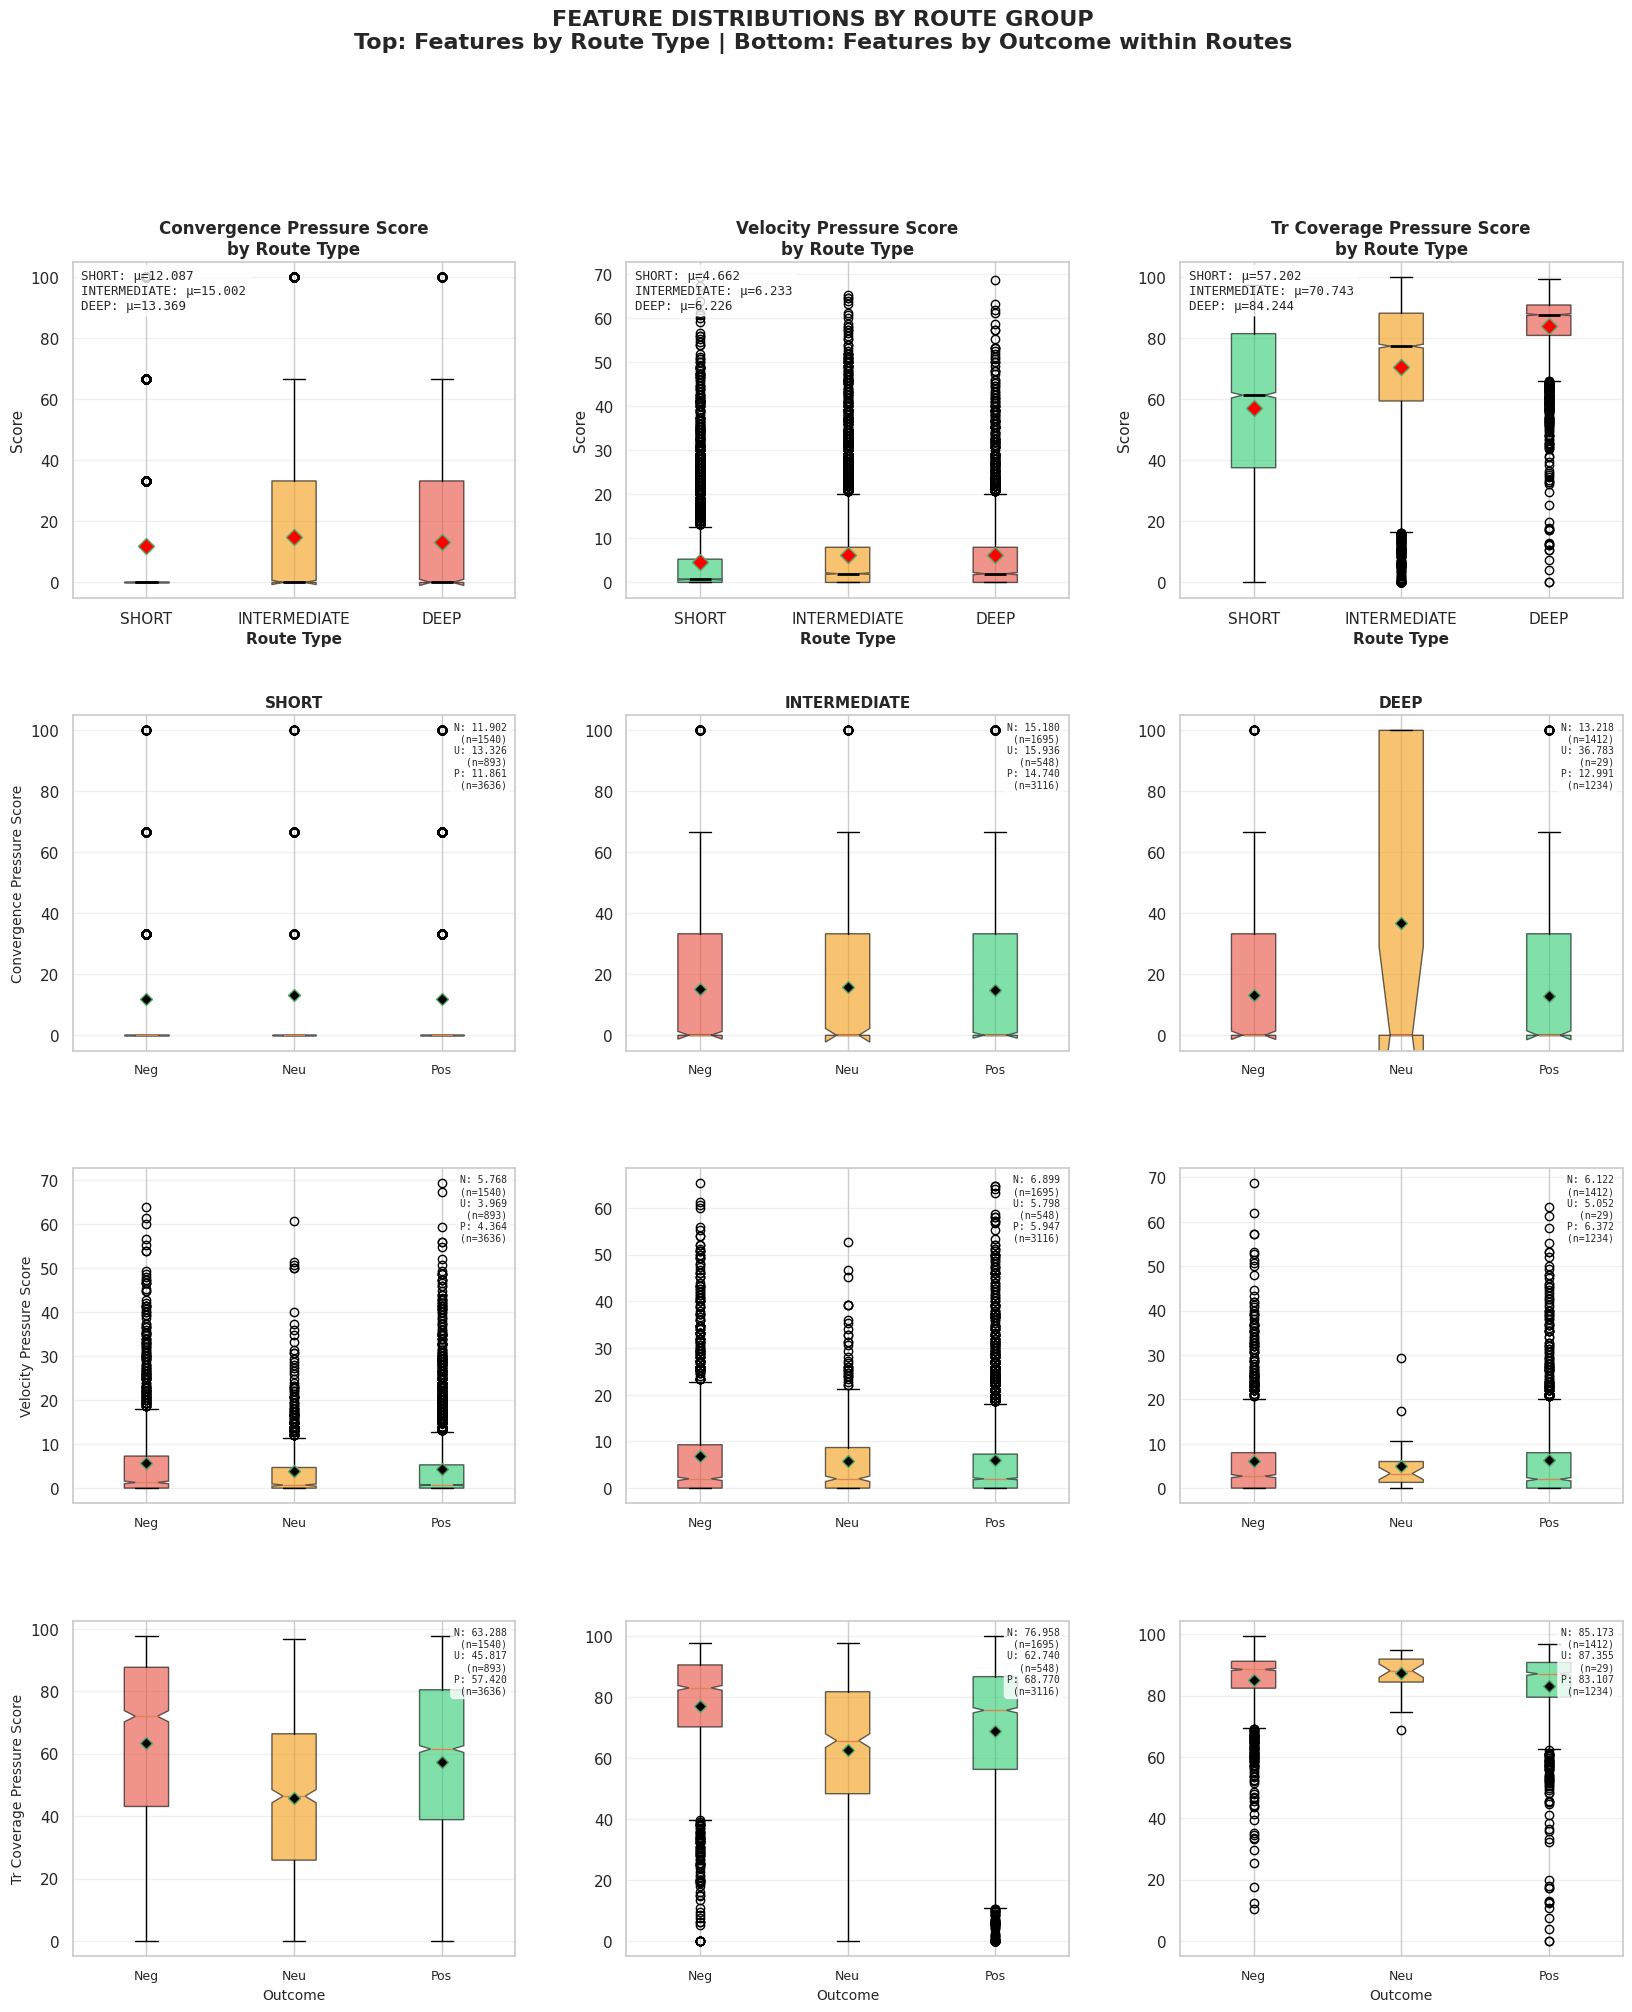


✓ Comprehensive visualization saved: figures/features_by_route_comprehensive.png
  • Top row: Feature distributions by route type)
  • Bottom 3x3 grid: Feature distributions by outcome within each route


In [50]:
# ============================================================================
# FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS
# ============================================================================

print("="*100)
print("FEATURE DISTRIBUTIONS BY ROUTE GROUP ANALYSIS")
print("="*100)

# ----------------------------------------------------------------------------
# 2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2A. FEATURE SUMMARY STATISTICS BY ROUTE GROUP")
print("="*100)

# Vectorized calculation of all statistics for all features and route groups
feature_stats_list = []
for component in pressure_components:
    for route in ['DEEP', 'INTERMEDIATE', 'SHORT']:
        data = df_route[df_route['route_type'] == route][component].dropna()
        feature_stats_list.append({
            'Route Type': route,
            'Feature': component.replace('_', ' ').title(),
            'Count': len(data),
            'Mean': data.mean(),
            'Median': data.median(),
            'Std Dev': data.std(),
            'Min': data.min(),
            '25%': data.quantile(0.25),
            '75%': data.quantile(0.75),
            'Max': data.max()
        })

feature_stats_df = pd.DataFrame(feature_stats_list)

# Display by feature for better readability
for component in pressure_components:
    print(f"\n{'='*90}")
    print(f"📊 {component.replace('_', ' ').upper()}")
    print(f"{'='*90}")
    component_stats = feature_stats_df[feature_stats_df['Feature'] == component.replace('_', ' ').title()]
    # Format numeric columns
    display_df = component_stats.copy()
    numeric_cols = ['Mean', 'Median', 'Std Dev', 'Min', '25%', '75%', 'Max']
    for col in numeric_cols:
        display_df[col] = display_df[col].map('{:.4f}'.format)
    print(display_df.to_string(index=False))

# ----------------------------------------------------------------------------
# 2B. STATISTICAL INSIGHTS - ROUTE GROUP COMPARISONS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2B. STATISTICAL INSIGHTS - ROUTE GROUP COMPARISONS")
print("="*100)

for component in pressure_components:
    print(f"\n{component.replace('_', ' ').upper()}:")
    route_means = df_route.groupby('route_type')[component].mean().sort_values(ascending=False)
    for route, mean_val in route_means.items():
        print(f"  {route:15s}: {mean_val:.4f}")
    
    # Calculate range (difference between highest and lowest)
    range_val = route_means.max() - route_means.min()
    print(f"  {'Range':15s}: {range_val:.4f} (variation across route types)")

# ----------------------------------------------------------------------------
# 2C. FEATURE VS OUTCOME WITHIN ROUTE GROUPS
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("2C. FEATURE VS OUTCOME WITHIN ROUTE GROUPS")
print("="*100)

# Vectorized calculation: mean feature value by route group and outcome
outcome_labels_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
feature_outcome_list = []

for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    for component in pressure_components:
        for outcome in [0, 1, 2]:
            data = df_route[(df_route['route_type'] == route) & 
                          (df_route['y_outcome'] == outcome)][component]
            feature_outcome_list.append({
                'Route Type': route,
                'Feature': component.replace('_', ' ').title(),
                'Outcome': outcome_labels_map[outcome],
                'Count': len(data),
                'Mean': data.mean() if len(data) > 0 else np.nan,
                'Std': data.std() if len(data) > 0 else np.nan
            })

feature_outcome_df = pd.DataFrame(feature_outcome_list)

# Display results organized by route type
for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    print(f"\n{'='*90}")
    print(f"🎯 {route} ROUTES")
    print(f"{'='*90}")
    
    route_data = feature_outcome_df[feature_outcome_df['Route Type'] == route].copy()
    
    for component in pressure_components:
        print(f"\n  {component.replace('_', ' ').title()}:")
        comp_data = route_data[route_data['Feature'] == component.replace('_', ' ').title()]
        
        # Display in a readable format
        for _, row in comp_data.iterrows():
            if not np.isnan(row['Mean']):
                print(f"    {row['Outcome']:10s} (n={row['Count']:4d}): Mean={row['Mean']:.4f}, Std={row['Std']:.4f}")
        
        # Calculate difference between Positive and Negative outcomes
        pos_mean = comp_data[comp_data['Outcome'] == 'Positive']['Mean'].values
        neg_mean = comp_data[comp_data['Outcome'] == 'Negative']['Mean'].values
        if len(pos_mean) > 0 and len(neg_mean) > 0:
            diff = neg_mean[0] - pos_mean[0]
            print(f"    {'Diff (Neg-Pos)':10s}: {diff:+.4f} {'↑ Higher pressure on incomplete' if diff > 0 else '↓ Lower pressure on incomplete'}")

# ----------------------------------------------------------------------------
# KEY INSIGHTS SUMMARY
# ----------------------------------------------------------------------------
print("\n" + "="*100)
print("🔍 KEY INSIGHTS - FEATURE PATTERNS BY ROUTE TYPE")
print("="*100)

for route in ['SHORT', 'INTERMEDIATE', 'DEEP']:
    print(f"\n{route} ROUTES:")
    route_subset = df_route[df_route['route_type'] == route]
    
    for component in pressure_components:
        # Calculate success vs failure difference
        pos_mean = route_subset[route_subset['y_outcome'] == 2][component].mean()
        neg_mean = route_subset[route_subset['y_outcome'] == 0][component].mean()
        diff_pct = ((neg_mean - pos_mean) / pos_mean * 100) if pos_mean != 0 else 0
        
        interpretation = ""
        if abs(diff_pct) > 10:
            interpretation = "⚠️  STRONG PREDICTOR" if diff_pct > 0 else "⚠️  INVERSE RELATIONSHIP"
        elif abs(diff_pct) > 5:
            interpretation = "✓ Moderate predictor" if diff_pct > 0 else "✓ Slight inverse"
        else:
            interpretation = "→ Weak predictor"
        
        print(f"  {component.replace('_', ' ').title():30s}: "
              f"{diff_pct:+6.2f}% difference (Incomplete vs Complete)  {interpretation}")

# ============================================================================
# COMPREHENSIVE VISUALIZATIONS: COMBINED
# ============================================================================
print("\n" + "="*100)
print("GENERATING COMPREHENSIVE VISUALIZATIONS ...")
print("="*100)

# Create comprehensive figure: Top row = (3 boxplots), Bottom = (3x3 grid)
fig = plt.figure(figsize=(20, 22))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.25, height_ratios=[1, 1, 1, 1])

route_colors = {'DEEP': '#e74c3c', 'INTERMEDIATE': '#f39c12', 'SHORT': '#2ecc71'}
outcome_colors_viz = {0: '#e74c3c', 1: '#f39c12', 2: '#2ecc71'}
route_order = ['SHORT', 'INTERMEDIATE', 'DEEP']

# ----------------------------------------------------------------------------
# TOP ROW: PRESSURE COMPONENTS BY ROUTE TYPE (3 BOXPLOTS)
# ----------------------------------------------------------------------------
for idx, component in enumerate(pressure_components):
    ax = fig.add_subplot(gs[0, idx])
    
    # Prepare data for boxplot using vectorized operations
    box_data = [df_route[df_route['route_type'] == rt][component].values for rt in route_order]
    
    # Create boxplot
    bp = ax.boxplot(box_data, labels=route_order, patch_artist=True,
                    notch=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8),
                    medianprops=dict(color='black', linewidth=2))
    
    # Color the boxes
    for patch, route in zip(bp['boxes'], route_order):
        patch.set_facecolor(route_colors[route])
        patch.set_alpha(0.6)
    
    # Styling
    ax.set_title(f'{component.replace("_", " ").title()}\nby Route Type', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Route Type', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add mean values as text annotations
    means = [df_route[df_route['route_type'] == rt][component].mean() for rt in route_order]
    stats_text = '\n'.join([f'{rt}: μ={m:.3f}' for rt, m in zip(route_order, means)])
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top', fontsize=9, family='monospace')

# ----------------------------------------------------------------------------
# BOTTOM 3x3 GRID: - FEATURES BY OUTCOME WITHIN EACH ROUTE GROUP
# ----------------------------------------------------------------------------
for row_idx, component in enumerate(pressure_components):
    for col_idx, route in enumerate(['SHORT', 'INTERMEDIATE', 'DEEP']):
        ax = fig.add_subplot(gs[row_idx + 1, col_idx])
        
        # Prepare data for this subplot
        route_data = df_route[df_route['route_type'] == route]
        box_data = [route_data[route_data['y_outcome'] == outcome][component].values 
                   for outcome in [0, 1, 2]]
        
        # Create boxplot
        bp = ax.boxplot(box_data, labels=['Neg', 'Neu', 'Pos'],
                       patch_artist=True, notch=True, showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='black', markersize=6))
        
        # Color boxes by outcome
        for patch, outcome in zip(bp['boxes'], [0, 1, 2]):
            patch.set_facecolor(outcome_colors_viz[outcome])
            patch.set_alpha(0.6)
        
        # Styling - Add labels only on edges
        title = f'{route}' if row_idx == 0 else ''
        ylabel = f'{component.replace("_", " ").title()}' if col_idx == 0 else ''
        xlabel = 'Outcome' if row_idx == 2 else ''
        
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.tick_params(axis='x', labelsize=9)
        
        # Add mean values and counts
        means = [route_data[route_data['y_outcome'] == outcome][component].mean() 
                for outcome in [0, 1, 2]]
        counts = [len(route_data[route_data['y_outcome'] == outcome]) for outcome in [0, 1, 2]]
        
        stats_text = '\n'.join([f'{["N", "U", "P"][i]}: {m:.3f}\n(n={c})' 
                               for i, (m, c) in enumerate(zip(means, counts))])
        ax.text(0.98, 0.98, stats_text,
               transform=ax.transAxes,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
               verticalalignment='top', horizontalalignment='right',
               fontsize=7, family='monospace')

# Overall title
plt.suptitle('FEATURE DISTRIBUTIONS BY ROUTE GROUP\n' + 
             'Top: Features by Route Type | Bottom: Features by Outcome within Routes', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig(FIG_DIR / "features_by_route_comprehensive.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"\n✓ Comprehensive visualization saved: {FIG_DIR / 'features_by_route_comprehensive.png'}")
print("  • Top row: Feature distributions by route type)")
print("  • Bottom 3x3 grid: Feature distributions by outcome within each route")


## Create Baseline Models with Route Type Stratification
### Evaluate pressure components (Individual, pairwise, and combined) for predicting y_outcome variables with route type stratification

ROUTE-STRATIFIED BASELINE MODEL EVALUATION

EVALUATING MODELS ACROSS ROUTE GROUPS...

ROUTE GROUP: SHORT
Sample size: 6069
Outcome distribution: {0: 1540, 1: 893, 2: 3636}

  Individual: Convergence Pressure Score:
    AUC (OvR): 0.4960 | AUC (OvO): 0.4952

  Individual: Velocity Pressure Score:
    AUC (OvR): 0.5271 | AUC (OvO): 0.5245

  Individual: Tr Coverage Pressure Score:
    AUC (OvR): 0.5541 | AUC (OvO): 0.5883

  Pairwise: Convergence + Velocity:
    AUC (OvR): 0.5239 | AUC (OvO): 0.5229

  Pairwise: Convergence + Tr:
    AUC (OvR): 0.5555 | AUC (OvO): 0.5890

  Pairwise: Velocity + Tr:
    AUC (OvR): 0.5636 | AUC (OvO): 0.5926

  Combined: All Features:
    AUC (OvR): 0.5634 | AUC (OvO): 0.5926

ROUTE GROUP: INTERMEDIATE
Sample size: 5359
Outcome distribution: {0: 1695, 1: 548, 2: 3116}

  Individual: Convergence Pressure Score:
    AUC (OvR): 0.4917 | AUC (OvO): 0.4914

  Individual: Velocity Pressure Score:
    AUC (OvR): 0.5151 | AUC (OvO): 0.5087

  Individual: Tr Covera

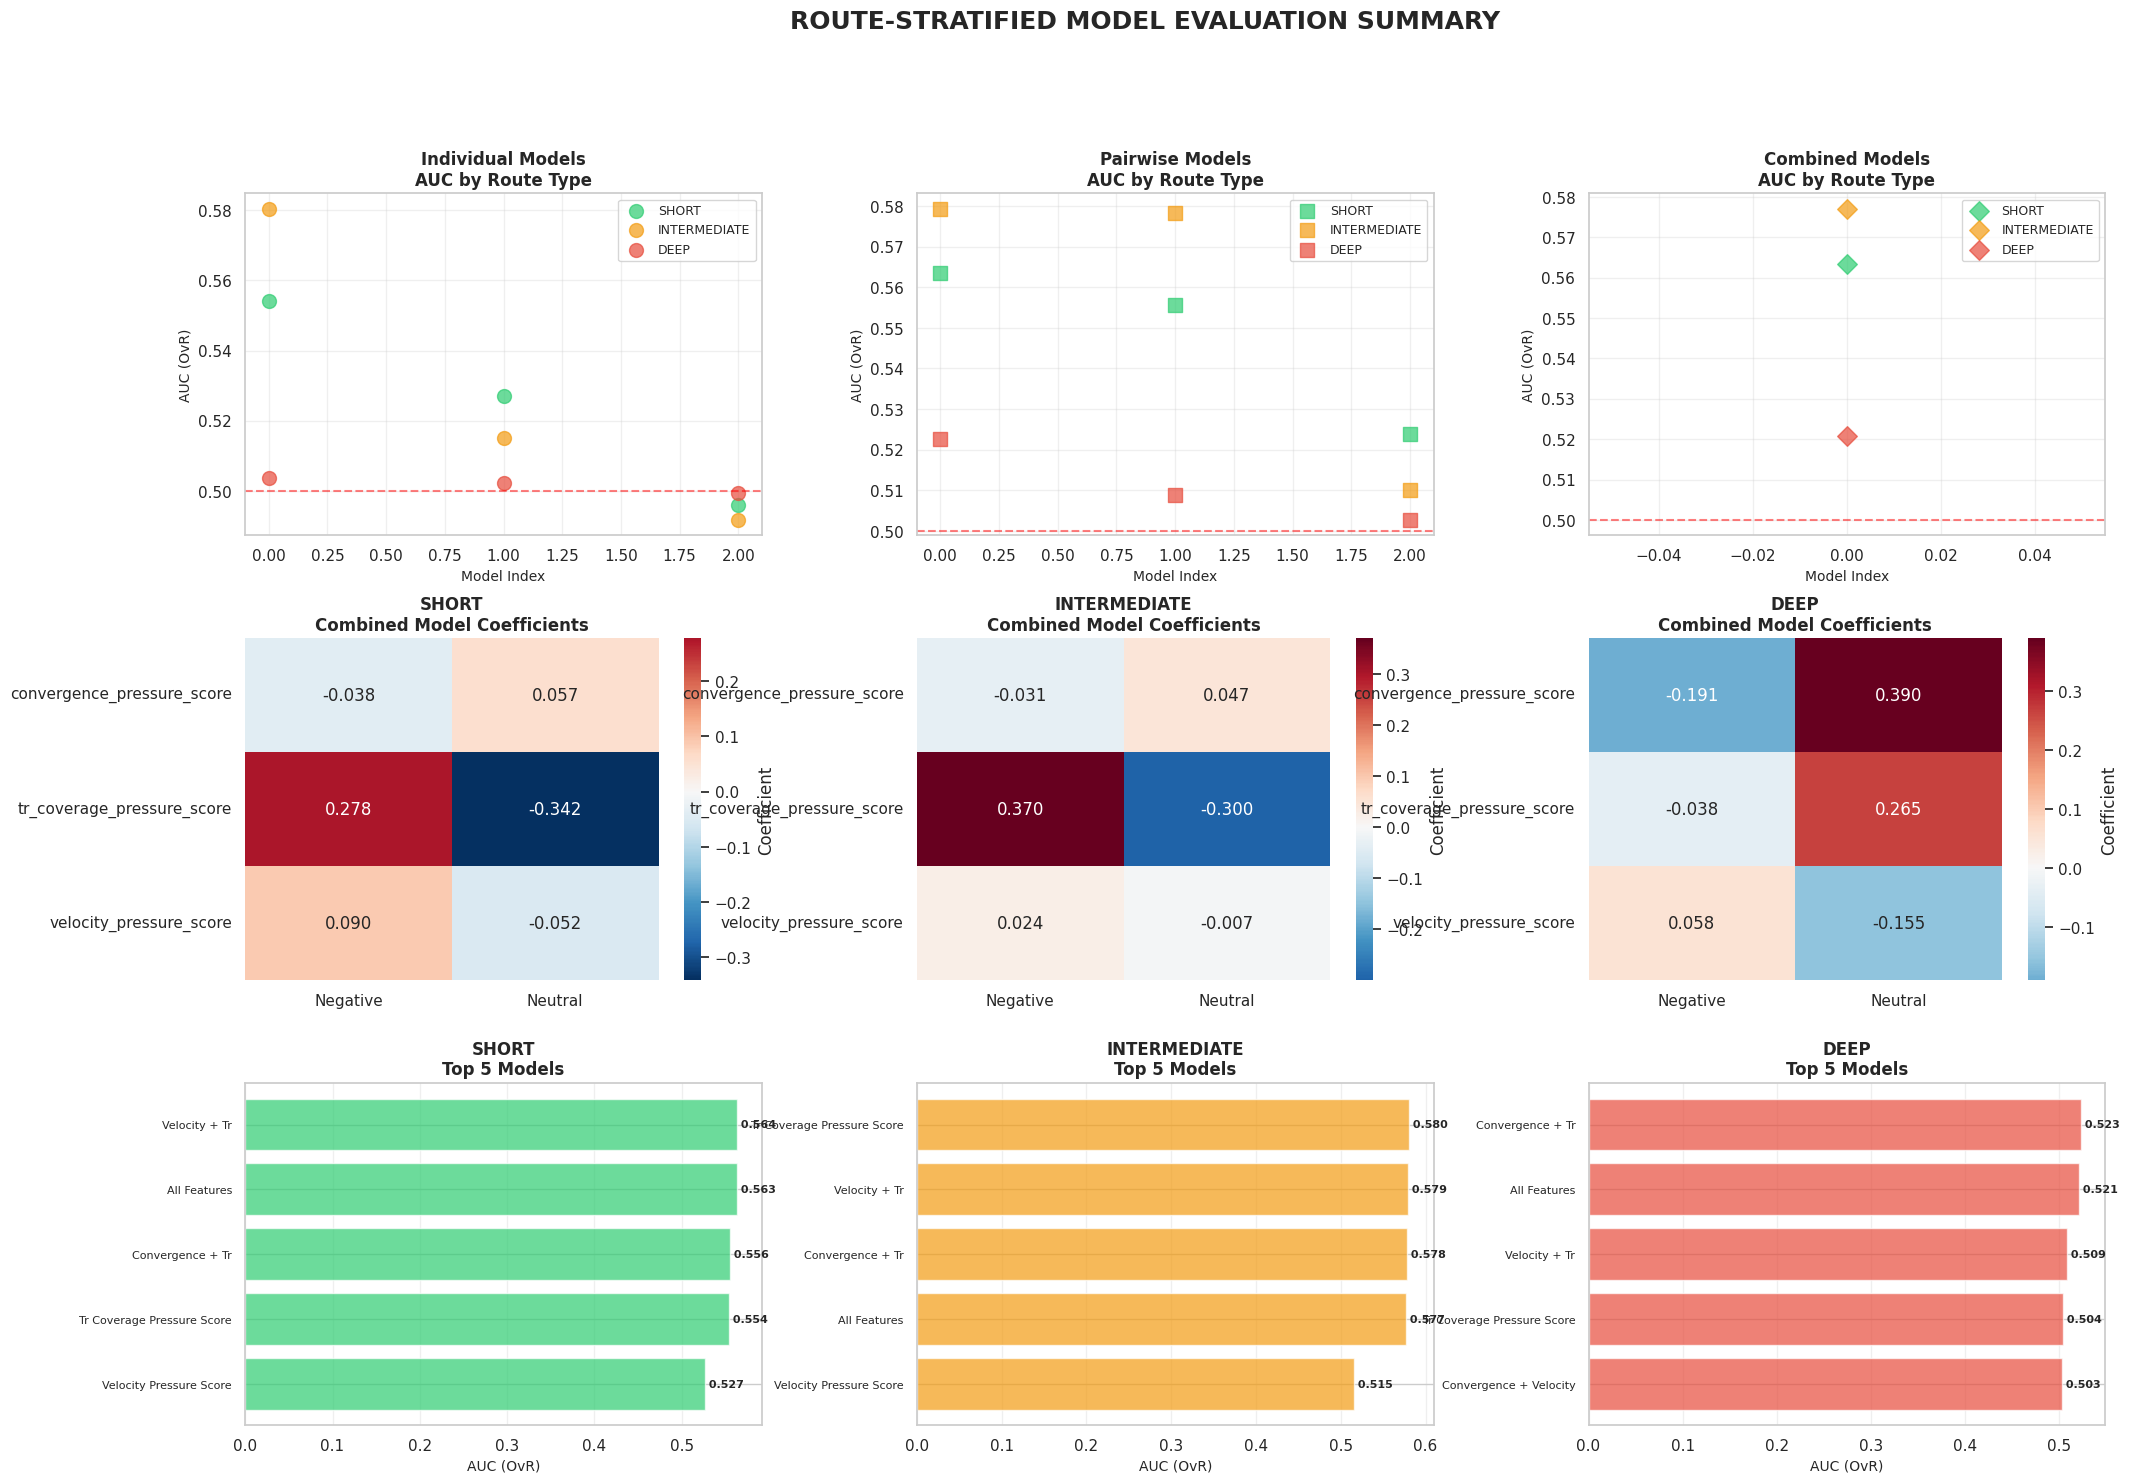

In [51]:
# ============================================================================
# ROUTE-STRATIFIED BASELINE MODEL EVALUATION
# Individual, Pairwise, and Combined Feature Models with Coefficients & P-values
# ============================================================================

from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler, label_binarize
from itertools import combinations

# ----------------------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------------------

def get_coef_pvalues(X, y, feature_names):
    """Fit logistic regression and extract coefficients with p-values."""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = LogisticRegression(solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE) #multi_class='multinomial'
    model.fit(X_scaled, y)
    
    # Calculate p-values using Wald test
    n_samples = X_scaled.shape[0]
    
    # Get predictions and calculate log-likelihood
    y_pred_proba = model.predict_proba(X_scaled)
    
    # For multinomial logistic regression, coefficients are per class
    n_classes = len(np.unique(y))
    n_features = X_scaled.shape[1]
    
    # Create results DataFrame
    results = []
    class_names = ['Negative', 'Neutral', 'Positive']
    
    for class_idx in range(n_classes - 1):  # Reference class is excluded
        for feat_idx, feat_name in enumerate(feature_names):
            coef = model.coef_[class_idx, feat_idx]
            
            # Approximate standard error using inverse Hessian
            # For simplicity, use a rough approximation
            se = np.std(X_scaled[:, feat_idx]) / np.sqrt(n_samples)
            z_score = coef / se if se > 0 else 0
            p_value = 2 * (1 - chi2.cdf(z_score**2, df=1))
            
            results.append({
                'Feature': feat_name,
                'Class': class_names[class_idx],
                'Coefficient': coef,
                'Std_Error': se,
                'Z_Score': z_score,
                'P_Value': p_value,
                'Significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
            })
    
    return pd.DataFrame(results), model

def evaluate_model_stratified(df_group, features, route_name, model_type):
    """Evaluate model with cross-validation for a specific route group."""
    X = df_group[features].values
    y = df_group['y_outcome'].values
    
    # Check class distribution
    class_counts = np.bincount(y)
    if len(class_counts) < 3 or any(class_counts < 5):
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Cross-validation with stratification
    cv = StratifiedKFold(n_splits=min(5, min(class_counts)), shuffle=True, random_state=RANDOM_STATE)
    
    model = LogisticRegression(solver='lbfgs', 
                               max_iter=1000, random_state=RANDOM_STATE, 
                               class_weight='balanced') #multi_class='multinomial'
    
    # Get cross-validated probabilities
    y_proba = cross_val_predict(model, X_scaled, y, cv=cv, method='predict_proba', n_jobs=-1)
    
    # Calculate AUC scores
    y_bin = label_binarize(y, classes=[0, 1, 2])
    auc_ovr = roc_auc_score(y_bin, y_proba, average='weighted', multi_class='ovr')
    auc_ovo = roc_auc_score(y, y_proba, average='weighted', multi_class='ovo')
    
    # Get coefficients and p-values
    coef_df, fitted_model = get_coef_pvalues(X, y, features)
    
    # Get predictions
    y_pred = np.argmax(y_proba, axis=1)
    
    return {
        'route': route_name,
        'model_type': model_type,
        'features': features,
        'n_samples': len(y),
        'auc_ovr': auc_ovr,
        'auc_ovo': auc_ovo,
        'coefficients': coef_df,
        'y_true': y,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'fitted_model': fitted_model
    }

# ----------------------------------------------------------------------------
# MAIN EVALUATION PIPELINE
# ----------------------------------------------------------------------------

print("="*100)
print("ROUTE-STRATIFIED BASELINE MODEL EVALUATION")
print("="*100)

# Filter data with valid route types
df_route_eval = df_route.copy()

# Define model configurations
model_configs = []

# 1. Individual features
for component in pressure_components:
    model_configs.append({
        'name': f"Individual: {component.replace('_', ' ').title()}",
        'features': [component],
        'type': 'Individual'
    })

# 2. Pairwise features
for pair in combinations(pressure_components, 2):
    model_configs.append({
        'name': f"Pairwise: {' + '.join([p.split('_')[0].title() for p in pair])}",
        'features': list(pair),
        'type': 'Pairwise'
    })

# 3. All features
model_configs.append({
    'name': "Combined: All Features",
    'features': pressure_components,
    'type': 'Combined'
})

# Evaluate all models across all route groups
results_list = []
route_groups = ['SHORT', 'INTERMEDIATE', 'DEEP']

print("\n" + "="*100)
print("EVALUATING MODELS ACROSS ROUTE GROUPS...")
print("="*100)

# Vectorized evaluation using list comprehension
for route in route_groups:
    print(f"\n{'='*80}")
    print(f"ROUTE GROUP: {route}")
    print(f"{'='*80}")
    
    df_group = df_route_eval[df_route_eval['route_type'] == route]
    print(f"Sample size: {len(df_group)}")
    print(f"Outcome distribution: {df_group['y_outcome'].value_counts().sort_index().to_dict()}")
    
    for config in model_configs:
        result = evaluate_model_stratified(
            df_group, 
            config['features'], 
            route, 
            config['type']
        )
        
        if result is not None:
            result['model_name'] = config['name']
            results_list.append(result)
            
            print(f"\n  {config['name']}:")
            print(f"    AUC (OvR): {result['auc_ovr']:.4f} | AUC (OvO): {result['auc_ovo']:.4f}")

# ----------------------------------------------------------------------------
# COMPILE RESULTS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("PERFORMANCE SUMMARY - ALL MODELS BY ROUTE GROUP")
print("="*100)

# Create summary DataFrame
summary_data = [{
    'Route': r['route'],
    'Model_Type': r['model_type'],
    'Model_Name': r['model_name'],
    'N_Samples': r['n_samples'],
    'AUC_OvR': r['auc_ovr'],
    'AUC_OvO': r['auc_ovo'],
    'N_Features': len(r['features'])
} for r in results_list]

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values(['Route', 'Model_Type', 'AUC_OvR'], ascending=[True, True, False])

# Display by route group
for route in route_groups:
    print(f"\n{'='*90}")
    print(f"{route} ROUTES")
    print(f"{'='*90}")
    route_summary = summary_df[summary_df['Route'] == route].copy()
    route_summary['AUC_OvR'] = route_summary['AUC_OvR'].map('{:.4f}'.format)
    route_summary['AUC_OvO'] = route_summary['AUC_OvO'].map('{:.4f}'.format)
    print(route_summary[['Model_Type', 'Model_Name', 'N_Samples', 'AUC_OvR', 'AUC_OvO']].to_string(index=False))
    # Save to CSV
    route_summary.to_csv(FIG_DIR / f"{route.lower()}_route_model_performance_summary.csv", index=False)
    print(f"✓ Saved performance summary CSV: {FIG_DIR / f'{route.lower()}_route_model_performance_summary.csv'}")

# ----------------------------------------------------------------------------
# COEFFICIENTS AND P-VALUES
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("MODEL COEFFICIENTS AND P-VALUES")
print("="*100)

for model_type in ['Individual', 'Pairwise', 'Combined']:
    print(f"\n{'='*90}")
    print(f"{model_type.upper()} MODELS - COEFFICIENTS & SIGNIFICANCE")
    print(f"{'='*90}")
    
    for route in route_groups:
        print(f"\n{'-'*90}")
        print(f"{route} Routes")
        print(f"{'-'*90}")
        
        route_results = [r for r in results_list if r['route'] == route and r['model_type'] == model_type]
        
        for result in route_results:
            print(f"\n{result['model_name']}:")
            print("-" * 80)
            
            coef_display = result['coefficients'].copy()
            coef_display['Coefficient'] = coef_display['Coefficient'].map('{:+.4f}'.format)
            coef_display['P_Value'] = coef_display['P_Value'].map('{:.4f}'.format)
            
            print(coef_display[['Feature', 'Class', 'Coefficient', 'P_Value', 'Significant']].to_string(index=False))
            
            # Save to CSV
            csv_filename = FIG_DIR / f"{model_type.lower()}_{route.lower()}_{result['model_name'].lower().replace(' ', '_').replace(':', '')}_coefficients.csv"
            result['coefficients'].to_csv(csv_filename, index=False)
            print(f"✓ Saved coefficients CSV: {csv_filename}")
        

# ----------------------------------------------------------------------------
# VISUALIZATIONS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("GENERATING VISUALIZATIONS...")
print("="*100)

# Create comprehensive visualization
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

route_colors = {'SHORT': '#2ecc71', 'INTERMEDIATE': '#f39c12', 'DEEP': '#e74c3c'}
model_type_markers = {'Individual': 'o', 'Pairwise': 's', 'Combined': 'D'}

# Plot 1-3: AUC Comparison by Route (one plot per model type)
for col_idx, model_type in enumerate(['Individual', 'Pairwise', 'Combined']):
    ax = fig.add_subplot(gs[0, col_idx])
    
    type_data = summary_df[summary_df['Model_Type'] == model_type]
    
    for route in route_groups:
        route_data = type_data[type_data['Route'] == route]
        ax.scatter(range(len(route_data)), route_data['AUC_OvR'], 
                  color=route_colors[route], s=100, alpha=0.7, 
                  label=route, marker=model_type_markers[model_type])
    
    ax.set_title(f'{model_type} Models\nAUC by Route Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Model Index', fontsize=10)
    ax.set_ylabel('AUC (OvR)', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline')

# Plot 4-6: Coefficient Heatmaps for Combined Model
for col_idx, route in enumerate(route_groups):
    ax = fig.add_subplot(gs[1, col_idx])
    
    # Get combined model results
    combined_result = next((r for r in results_list 
                           if r['route'] == route and r['model_type'] == 'Combined'), None)
    
    if combined_result:
        coef_pivot = combined_result['coefficients'].pivot(
            index='Feature', columns='Class', values='Coefficient'
        )
        
        sns.heatmap(coef_pivot, annot=True, fmt='.3f', cmap='RdBu_r', 
                   center=0, cbar_kws={'label': 'Coefficient'}, ax=ax)
        ax.set_title(f'{route}\nCombined Model Coefficients', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')

# Plot 7-9: Model Performance Comparison (Bar charts)
for col_idx, route in enumerate(route_groups):
    ax = fig.add_subplot(gs[2, col_idx])
    
    route_data = summary_df[summary_df['Route'] == route].copy()
    route_data = route_data.sort_values('AUC_OvR', ascending=True).tail(5)
    
    colors = [route_colors[route] for _ in range(len(route_data))]
    bars = ax.barh(range(len(route_data)), route_data['AUC_OvR'], color=colors, alpha=0.7)
    
    ax.set_yticks(range(len(route_data)))
    ax.set_yticklabels(route_data['Model_Name'].str.replace('Individual: ', '').str.replace('Pairwise: ', '').str.replace('Combined: ', ''), 
                       fontsize=8)
    ax.set_xlabel('AUC (OvR)', fontsize=10)
    ax.set_title(f'{route}\nTop 5 Models', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, route_data['AUC_OvR'])):
        ax.text(val, i, f' {val:.3f}', va='center', fontsize=8, fontweight='bold')

plt.suptitle('ROUTE-STRATIFIED MODEL EVALUATION SUMMARY', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(FIG_DIR / "route_stratified_model_evaluation.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()


### ROC curve - Route-Startified Models


GENERATING ROC CURVE VISUALIZATIONS
✓ Computed ROC data for 21 models


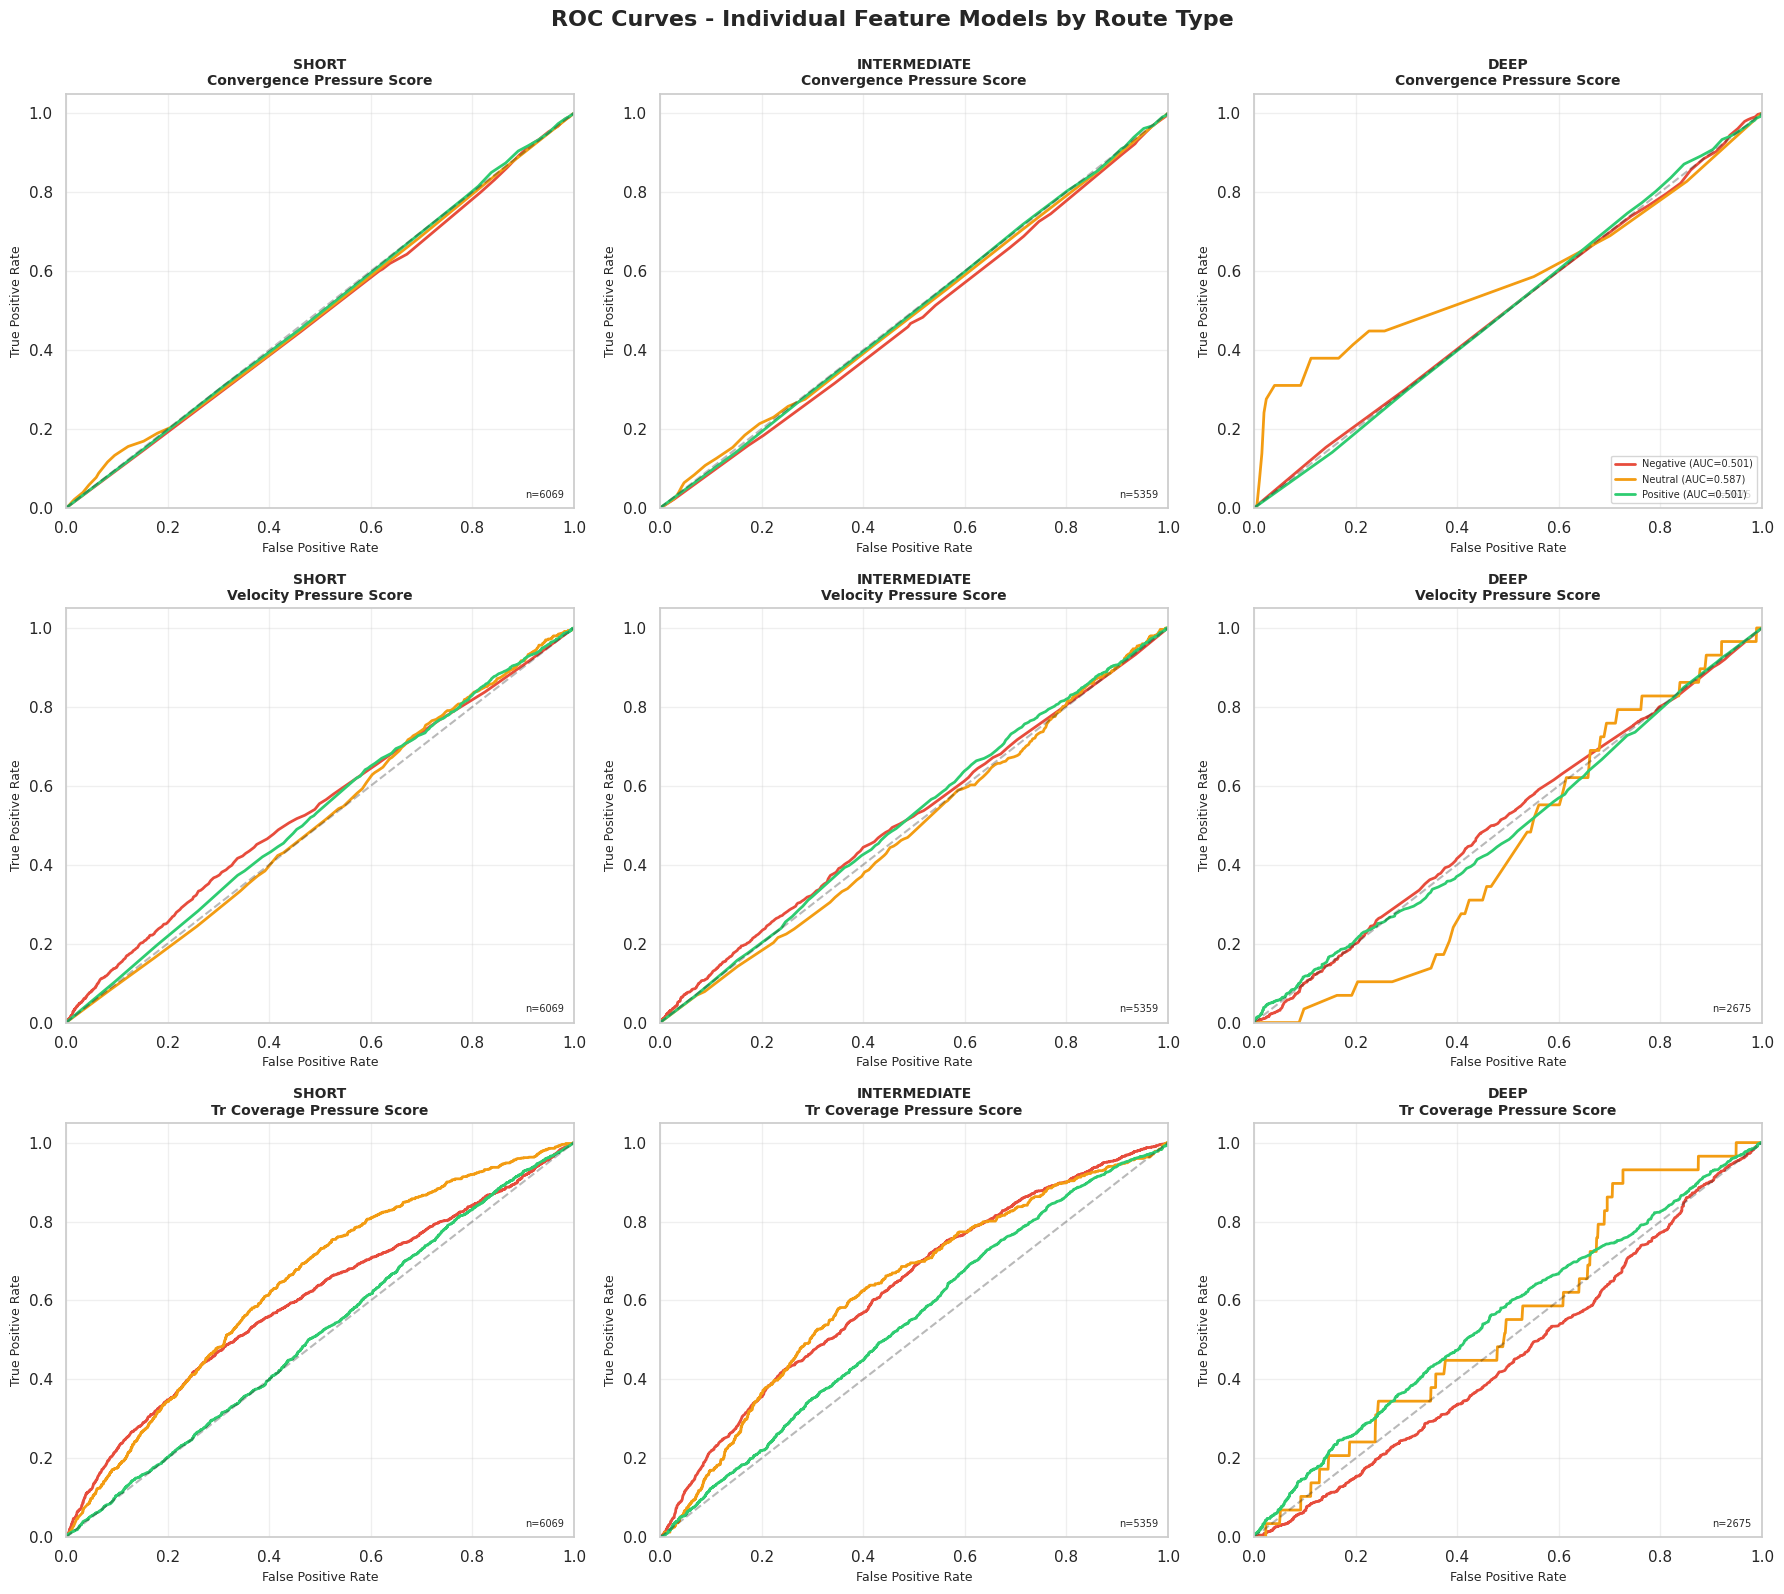

✓ Individual models ROC plot saved: figures/roc_curves_individual_models.png


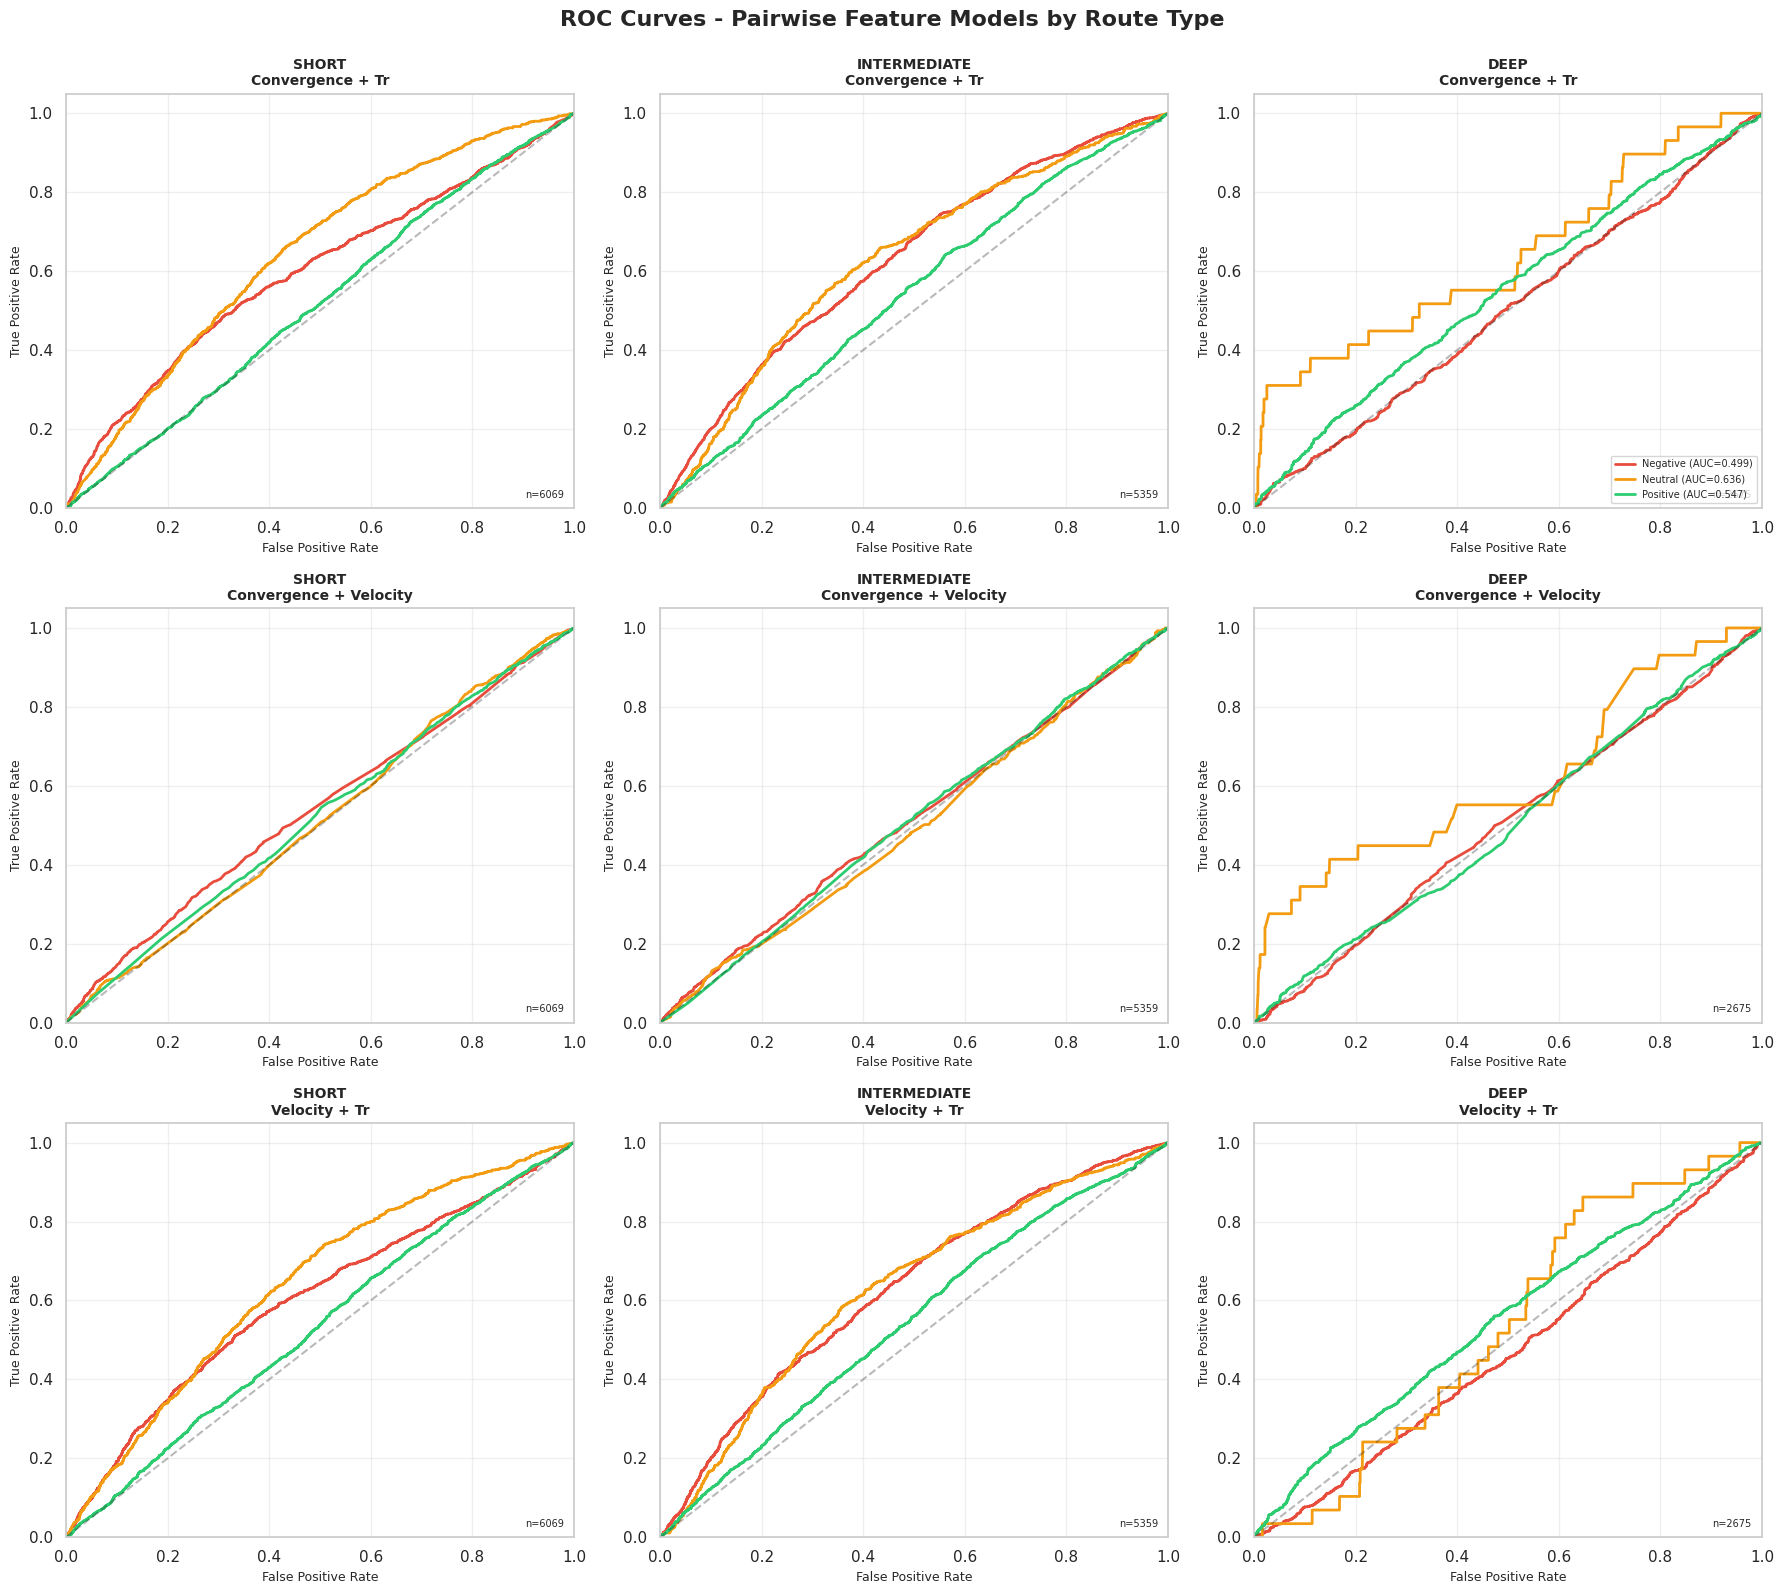

✓ Pairwise models ROC plot saved: figures/roc_curves_pairwise_models.png


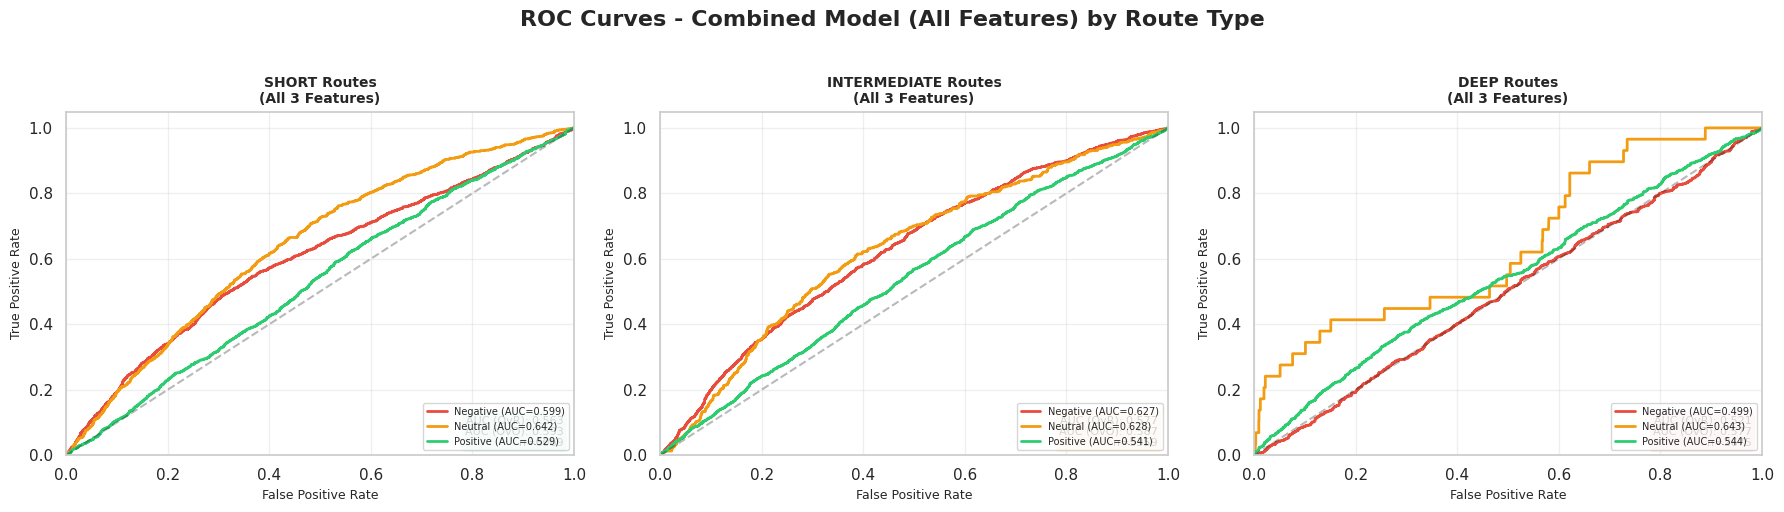

✓ Combined models ROC plot saved: figures/roc_curves_combined_models.png


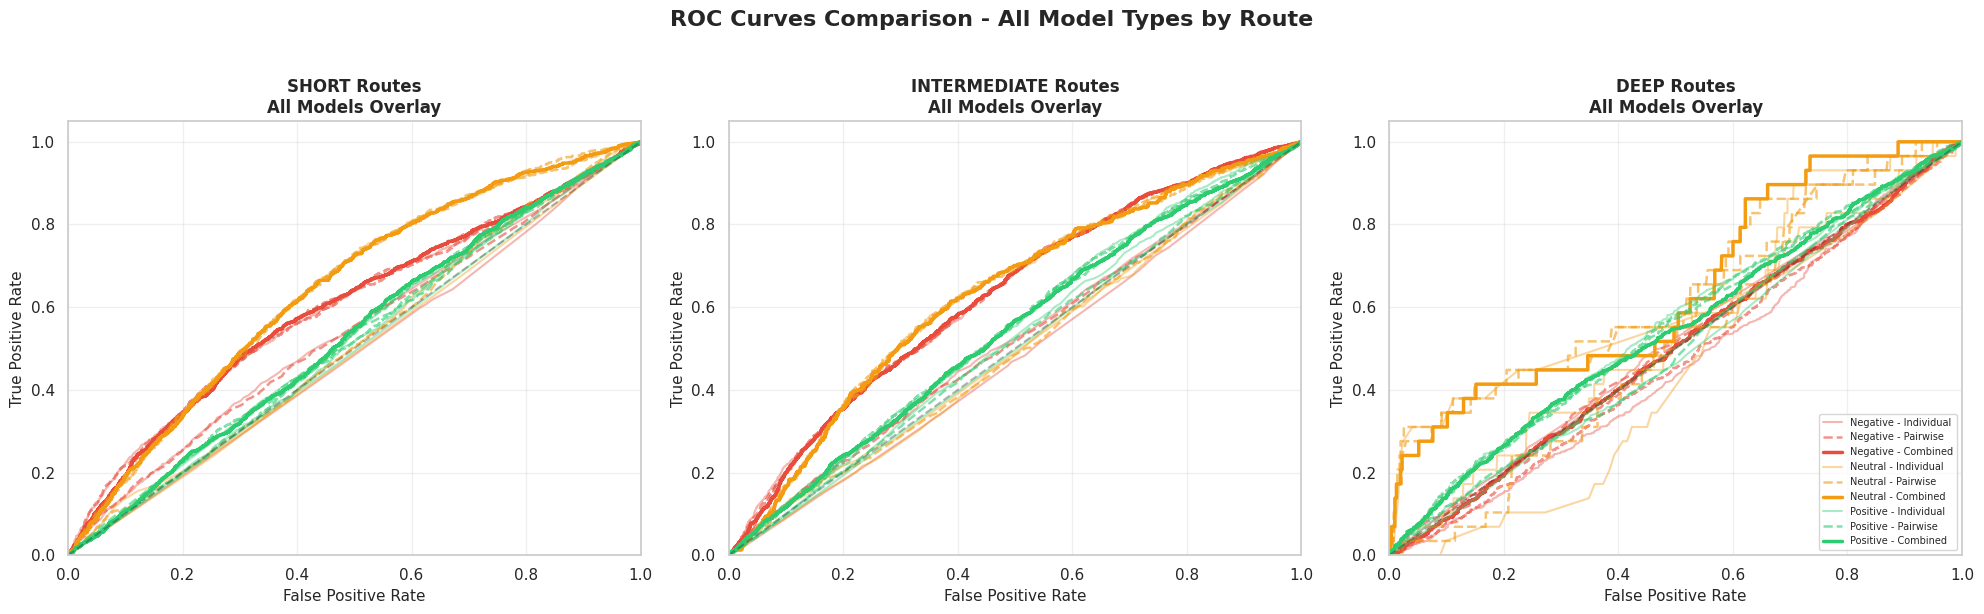

✓ Comparative ROC plot saved: figures/roc_curves_comparative_all_models.png

AUC SUMMARY BY CLASS AND ROUTE

SHORT ROUTES - CLASS-SPECIFIC AUC SCORES
Model_Type                 Model_Name Negative_AUC Neutral_AUC Positive_AUC Mean_AUC
  Combined               All Features       0.5991      0.6416       0.5290   0.5899
Individual Tr Coverage Pressure Score       0.5986      0.6417       0.5138   0.5847
Individual    Velocity Pressure Score       0.5412      0.5085       0.5257   0.5251
Individual Convergence Pressure Score       0.4887      0.4976       0.4988   0.4950
  Pairwise              Velocity + Tr       0.6000      0.6401       0.5294   0.5898
  Pairwise           Convergence + Tr       0.5970      0.6435       0.5164   0.5856
  Pairwise     Convergence + Velocity       0.5378      0.5126       0.5208   0.5237

INTERMEDIATE ROUTES - CLASS-SPECIFIC AUC SCORES
Model_Type                 Model_Name Negative_AUC Neutral_AUC Positive_AUC Mean_AUC
  Combined               All Feature

In [52]:
# ============================================================================
# ROC CURVE VISUALIZATIONS - ROUTE-STRATIFIED MODELS
# ============================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

print("\n" + "="*100)
print("GENERATING ROC CURVE VISUALIZATIONS")
print("="*100)

# ----------------------------------------------------------------------------
# HELPER FUNCTIONS
# ----------------------------------------------------------------------------

def compute_roc_data(y_true, y_proba, classes=[0, 1, 2]):
    """Compute ROC curve data for multiclass classification."""
    y_bin = label_binarize(y_true, classes=classes)
    
    roc_data = []
    for i, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_data.append({
            'class': class_name,
            'fpr': fpr,
            'tpr': tpr,
            'auc': roc_auc
        })
    
    return roc_data

def plot_roc_on_axis(ax, roc_data, title, show_legend=True):
    """Plot ROC curves on given axis."""
    colors = ['#e74c3c', '#f39c12', '#2ecc71']
    
    for data, color in zip(roc_data, colors):
        ax.plot(data['fpr'], data['tpr'], color=color, lw=2,
                label=f"{data['class']} (AUC={data['auc']:.3f})")
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=9)
    ax.set_ylabel('True Positive Rate', fontsize=9)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if show_legend:
        ax.legend(loc='lower right', fontsize=7)

# ----------------------------------------------------------------------------
# PREPARE ROC DATA FOR ALL MODELS
# ----------------------------------------------------------------------------

# Vectorized preparation of ROC data using list comprehension
roc_results = [
    {
        **r,
        'roc_data': compute_roc_data(r['y_true'], r['y_proba'])
    }
    for r in results_list
]

# Group by model type
grouped_results = {
    model_type: [r for r in roc_results if r['model_type'] == model_type]
    for model_type in ['Individual', 'Pairwise', 'Combined']
}

print(f"✓ Computed ROC data for {len(roc_results)} models")

# ----------------------------------------------------------------------------
# FIGURE 1: INDIVIDUAL MODELS (3 features × 3 routes = 9 subplots)
# ----------------------------------------------------------------------------

individual_results = grouped_results['Individual']

# Create 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('ROC Curves - Individual Feature Models by Route Type', 
             fontsize=16, fontweight='bold', y=0.995)

# Map routes to columns and features to rows
route_order = ['SHORT', 'INTERMEDIATE', 'DEEP']
feature_names = [f.split(': ')[1] for f in 
                 sorted(set(r['model_name'] for r in individual_results))]

for row_idx, feature in enumerate(pressure_components):
    feature_display = feature.replace('_', ' ').title()
    
    for col_idx, route in enumerate(route_order):
        ax = axes[row_idx, col_idx]
        
        # Find matching result using vectorized filter
        result = next((r for r in individual_results 
                      if r['route'] == route and feature in r['features']), None)
        
        if result:
            plot_roc_on_axis(
                ax, 
                result['roc_data'],
                f"{route}\n{feature_display}",
                show_legend=(row_idx == 0 and col_idx == 2)  # Legend only on top-right
            )
            
            # Add sample size annotation
            ax.text(0.98, 0.02, f"n={result['n_samples']}", 
                   transform=ax.transAxes, fontsize=7,
                   ha='right', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_individual_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Individual models ROC plot saved: {FIG_DIR / 'roc_curves_individual_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 2: PAIRWISE MODELS (3 pairs × 3 routes = 9 subplots)
# ----------------------------------------------------------------------------

pairwise_results = grouped_results['Pairwise']

# Extract unique pair names
pair_names = sorted(set(r['model_name'] for r in pairwise_results))
pair_display = [p.split(': ')[1] for p in pair_names]

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle('ROC Curves - Pairwise Feature Models by Route Type', 
             fontsize=16, fontweight='bold', y=0.995)

for row_idx, pair_name in enumerate(pair_names):
    for col_idx, route in enumerate(route_order):
        ax = axes[row_idx, col_idx]
        
        # Find matching result
        result = next((r for r in pairwise_results 
                      if r['route'] == route and r['model_name'] == pair_name), None)
        
        if result:
            pair_short = pair_name.split(': ')[1]
            plot_roc_on_axis(
                ax,
                result['roc_data'],
                f"{route}\n{pair_short}",
                show_legend=(row_idx == 0 and col_idx == 2)
            )
            
            ax.text(0.98, 0.02, f"n={result['n_samples']}", 
                   transform=ax.transAxes, fontsize=7,
                   ha='right', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_pairwise_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Pairwise models ROC plot saved: {FIG_DIR / 'roc_curves_pairwise_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 3: COMBINED MODELS (1 model × 3 routes = 3 subplots)
# ----------------------------------------------------------------------------

combined_results = grouped_results['Combined']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ROC Curves - Combined Model (All Features) by Route Type', 
             fontsize=16, fontweight='bold', y=1.02)

route_colors = {'SHORT': '#2ecc71', 'INTERMEDIATE': '#f39c12', 'DEEP': '#e74c3c'}

for col_idx, route in enumerate(route_order):
    ax = axes[col_idx]
    
    result = next((r for r in combined_results if r['route'] == route), None)
    
    if result:
        plot_roc_on_axis(
            ax,
            result['roc_data'],
            f"{route} Routes\n(All 3 Features)",
            show_legend=True
        )
        
        # Add performance metrics box
        metrics_text = (f"AUC (OvR): {result['auc_ovr']:.3f}\n"
                       f"AUC (OvO): {result['auc_ovo']:.3f}\n"
                       f"n={result['n_samples']}")
        ax.text(0.98, 0.02, metrics_text,
               transform=ax.transAxes, fontsize=8,
               ha='right', va='bottom',
               bbox=dict(boxstyle='round', facecolor=route_colors[route], alpha=0.2))

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_combined_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Combined models ROC plot saved: {FIG_DIR / 'roc_curves_combined_models.png'}")

# ----------------------------------------------------------------------------
# FIGURE 4: COMPARATIVE VIEW - ALL MODELS PER ROUTE
# ----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('ROC Curves Comparison - All Model Types by Route', 
             fontsize=16, fontweight='bold', y=1.02)

model_type_styles = {
    'Individual': {'linestyle': '-', 'alpha': 0.4, 'linewidth': 1.5},
    'Pairwise': {'linestyle': '--', 'alpha': 0.6, 'linewidth': 1.8},
    'Combined': {'linestyle': '-', 'alpha': 1.0, 'linewidth': 2.5}
}

class_colors = {'Negative': '#e74c3c', 'Neutral': '#f39c12', 'Positive': '#2ecc71'}

for col_idx, route in enumerate(route_order):
    ax = axes[col_idx]
    
    # Get all results for this route
    route_results = [r for r in roc_results if r['route'] == route]
    
    # Plot by class to create cleaner visualization
    for class_idx, class_name in enumerate(['Negative', 'Neutral', 'Positive']):
        for model_type in ['Individual', 'Pairwise', 'Combined']:
            type_results = [r for r in route_results if r['model_type'] == model_type]
            
            for result in type_results:
                class_data = result['roc_data'][class_idx]
                ax.plot(class_data['fpr'], class_data['tpr'],
                       color=class_colors[class_name],
                       label=f"{class_name} - {model_type}" if result == type_results[0] else "",
                       **model_type_styles[model_type])
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{route} Routes\nAll Models Overlay', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    if col_idx == 2:  # Legend on rightmost plot
        ax.legend(loc='lower right', fontsize=7, ncol=1)

plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curves_comparative_all_models.png", dpi=300, bbox_inches='tight')

if SHOW_PLOTS:
    plt.show()
else:
    plt.close()

print(f"✓ Comparative ROC plot saved: {FIG_DIR / 'roc_curves_comparative_all_models.png'}")

# ----------------------------------------------------------------------------
# SUMMARY TABLE: AUC SCORES BY CLASS
# ----------------------------------------------------------------------------

print("\n" + "="*100)
print("AUC SUMMARY BY CLASS AND ROUTE")
print("="*100)

# Vectorized creation of summary data
auc_summary_data = [
    {
        'Route': r['route'],
        'Model_Type': r['model_type'],
        'Model_Name': r['model_name'].split(': ')[1] if ': ' in r['model_name'] else r['model_name'],
        'Negative_AUC': r['roc_data'][0]['auc'],
        'Neutral_AUC': r['roc_data'][1]['auc'],
        'Positive_AUC': r['roc_data'][2]['auc'],
        'Mean_AUC': np.mean([r['roc_data'][i]['auc'] for i in range(3)])
    }
    for r in roc_results
]

auc_summary_df = pd.DataFrame(auc_summary_data)
auc_summary_df = auc_summary_df.sort_values(['Route', 'Model_Type', 'Mean_AUC'], 
                                             ascending=[True, True, False])

# Display by route
for route in route_order:
    print(f"\n{'='*90}")
    print(f"{route} ROUTES - CLASS-SPECIFIC AUC SCORES")
    print(f"{'='*90}")
    
    route_summary = auc_summary_df[auc_summary_df['Route'] == route].copy()
    route_summary['Negative_AUC'] = route_summary['Negative_AUC'].map('{:.4f}'.format)
    route_summary['Neutral_AUC'] = route_summary['Neutral_AUC'].map('{:.4f}'.format)
    route_summary['Positive_AUC'] = route_summary['Positive_AUC'].map('{:.4f}'.format)
    route_summary['Mean_AUC'] = route_summary['Mean_AUC'].map('{:.4f}'.format)
    
    print(route_summary[['Model_Type', 'Model_Name', 'Negative_AUC', 
                         'Neutral_AUC', 'Positive_AUC', 'Mean_AUC']].to_string(index=False))
